In [226]:
# Importamos los paquetes necesarios
import pandas as pd
import plotnine as p9
import numpy as np
import matplotlib.pyplot as plt
from optbinning import OptimalBinning

# tests de hipótesis (punto 3)
import statsmodels.api as sm
from scipy.stats import shapiro, ttest_ind, chi2_contingency
import statsmodels.formula.api as smf

# Libreria Propia
import utils as ut

import importlib

## 1. Carga y revisión del dataset

In [227]:
data_path = '../data/diabetes_prediction_dataset.csv'
data = pd.read_csv(data_path, sep=',')
data.head()

gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0

Por último, tenemos _blood\_glucose\_level_ que a pesar de ser una variable entera, se considera como una variable contínua, debido al gran número de categorías que harían falta para describirla si no. El resto de variables son variables contínuas de por sçi (aunque la edad se podría de nuevo considerar categórica, pero esto no sería útil).  

Observando los estadisticos del `.describe()`, podemos intuir la proporción de individuos con problemas cardíacos con un $3.94\%$, aquellos con diabetes conforman el $8.5\%$ y los que tienen hipertensión son el $7.49\%$.

## 1.1 Inspección inicial

In [228]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  str    
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  str    
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), str(2)
memory usage: 6.9 MB


Creamos una lista con las variables numéricas, dejando de lado a diabetes ya que es nuestra variable objetivo y otro con las variables categóricas.

In [229]:
numeric_var = data.select_dtypes(include='number').columns.tolist()
numeric_var.remove('diabetes')
numeric_var

['age',
 'hypertension',
 'heart_disease',
 'bmi',
 'HbA1c_level',
 'blood_glucose_level']

In [230]:
categoric_var = [var for var in data.columns.tolist() if var not in numeric_var]
categoric_var

['gender', 'smoking_history', 'diabetes']

### 1.2 Revisión de duplicados

In [231]:
data.duplicated().sum()

np.int64(3854)

In [232]:
df_dup = data[data.duplicated(keep=False)]

# Cuenta duplicados exactos y su frecuencia y los agrupa en un conteo
df_dup.groupby(list(df_dup.columns)).size().value_counts()

2    2523
3     431
4      85
5      29
6       9
7       5
9       2
8       1
Name: count, dtype: int64

3854 filas exactamente iguales, decidimos mantener los registros y asumiremos que son personas diferentes con la misma información recopilada.

#### Primeras impresiones

Tenemos un dataset con 100.000 observaciones, se ve que sólo existen dos columnas que no son numéricas, estas son el **género y el historial como fumador (o no)**. Estas dos columnas serán tratadas como variables categóricas, asi como también la variable objetivo.

- **No hay missing values explícitos** -> PERO no garantiza ausencia de “missing lógicos”

En primer lugar vamos a observar el tipo de datos que tenemos en búsqueda de errores de formato, _missing values_ u otro tipo de inconsistencias en el _data frame_.

## 2. Análisis de variables
### 2.1 Análisis univariante, variables numéricas.

### Age

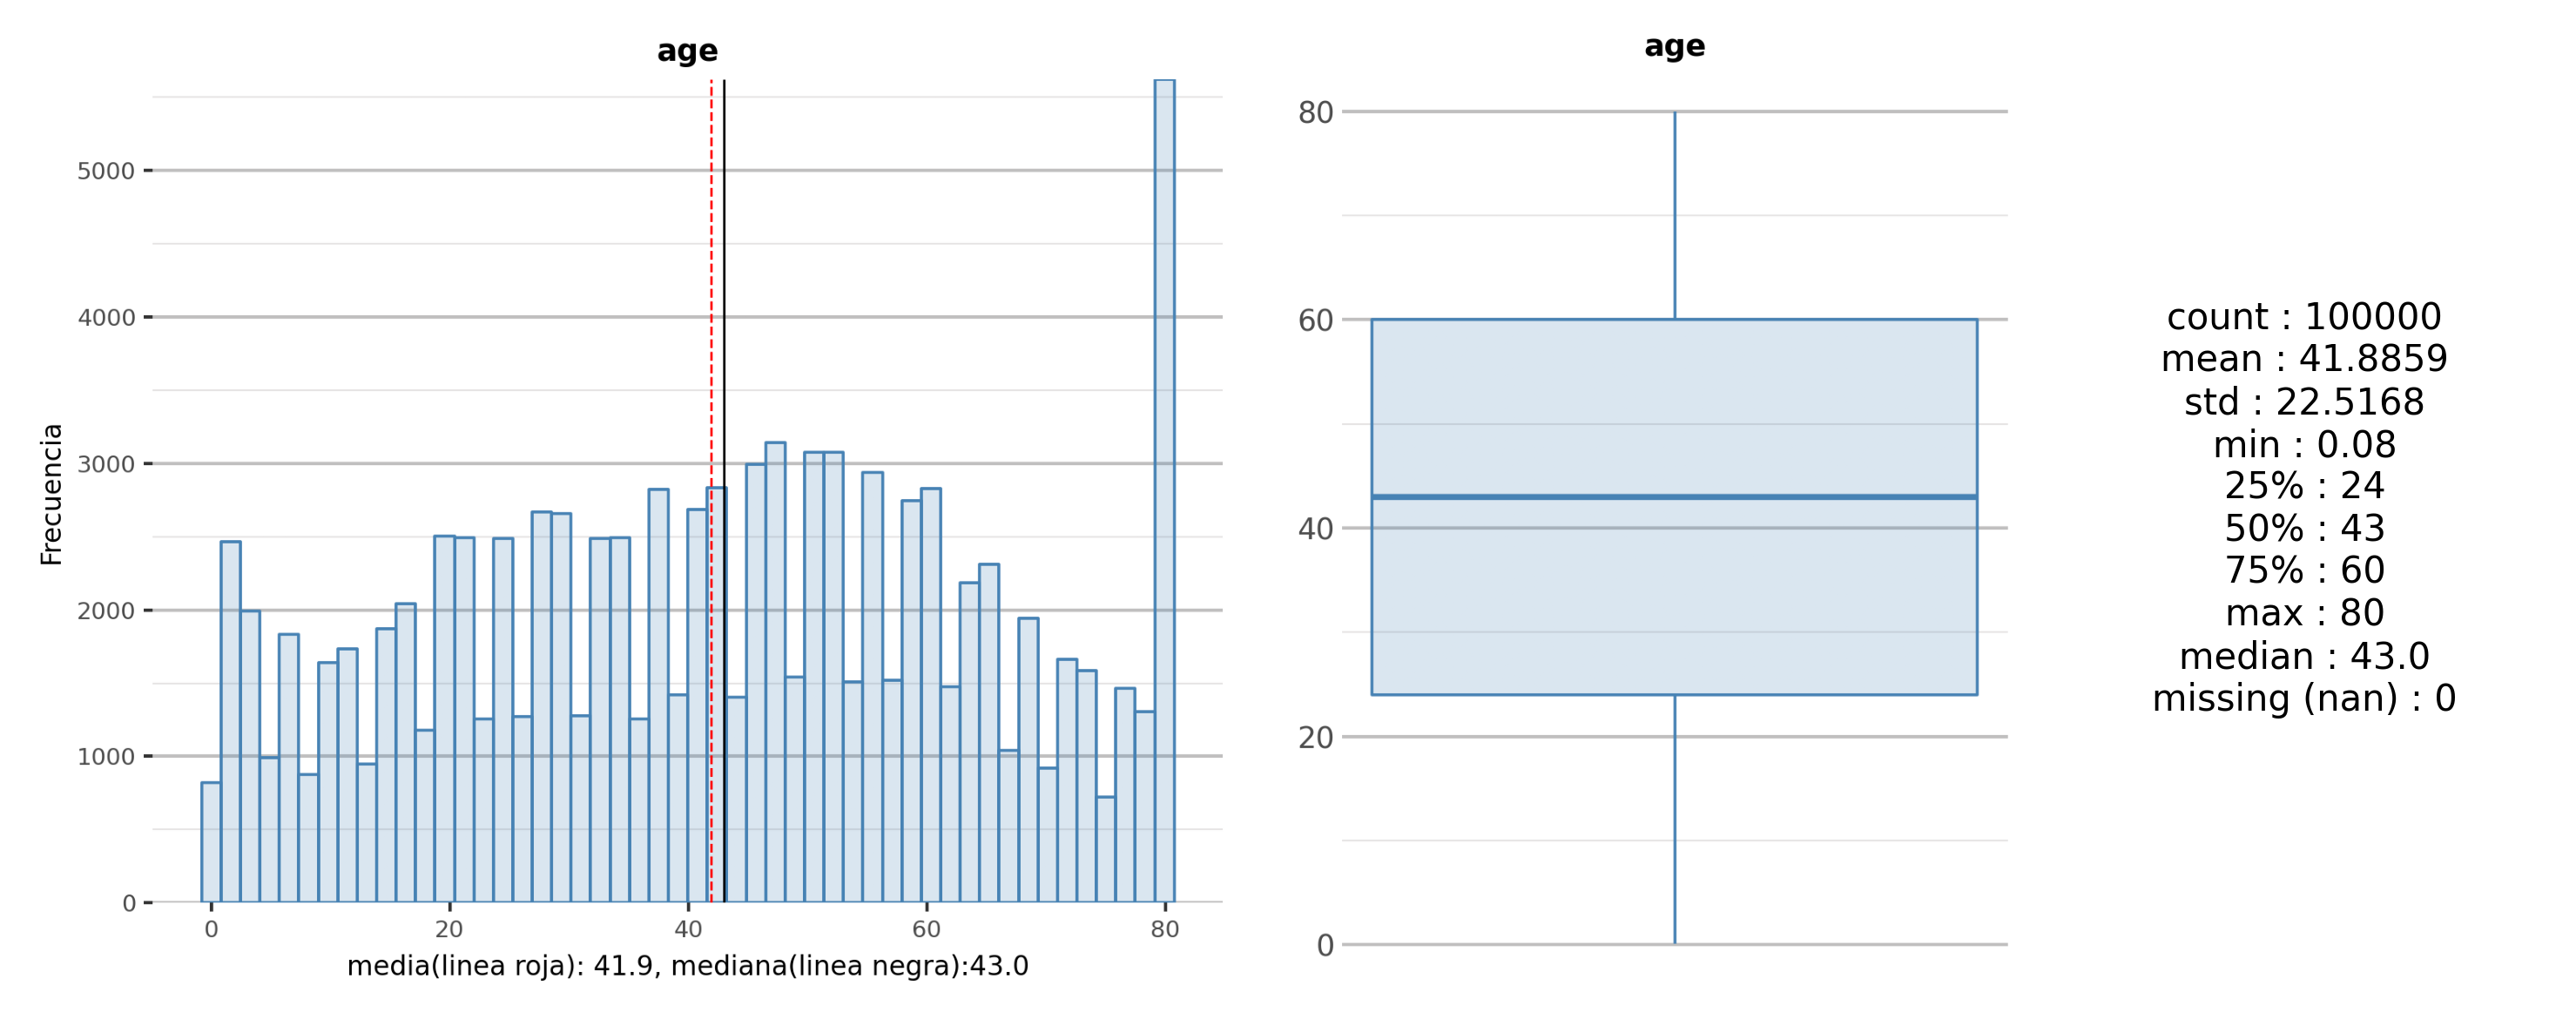

In [233]:
col = numeric_var[0]
histogram_plot = ut.histogram_plot(data,col,color_general='steelblue',
                                   color_mean='red',color_median='black',
                                   fig_size_histogram = (5,4))

box_plot = ut.box_plot(data,col,color_general='steelblue',
                       fig_size_box_plot=(3,4))

desc_text = ut.desc_plot(data,col)
plot_var_cuantitative = ut.join_plots([histogram_plot,box_plot,desc_text],
                                      [(5,4),(3,4),(2,4)])
plt.tight_layout()
plt.show()

Observamos con estas gráficas cómo la distribución de la variable edad, aunque en el *boxplot* no se observa ningún *outlier*, sí que podemos observar como el número de cuentas del rango de edad con $80$ años es muy grande, mucho myor que el de cualquier otro grupo de edad. Esto puede ser importante a la hora de hacer un modelo ya que al tener tantas observaciones de ese grupo, las conclusiones estarán sesgadas para predecir especialmente bien en dicho grupo.


- La edad presenta un rango amplio (0.08–80 años), coherente con una población general que incluye desde recién nacidos hasta adultos mayores.
- La media (≈41.8) y la mediana (43) son muy próximas, lo que indica ausencia de asimetrías extremas.
- La distribución es relativamente homogénea, sin picos anómalos ni concentraciones artificiales.
- No se detectan outliers extremos ni valores clínicamente imposibles.
- La variabilidad observada es elevada (std ≈22.5), esperable dada la heterogeneidad de edades.
- La variable no requiere tratamiento previo para el análisis bi-variante

### hypertension

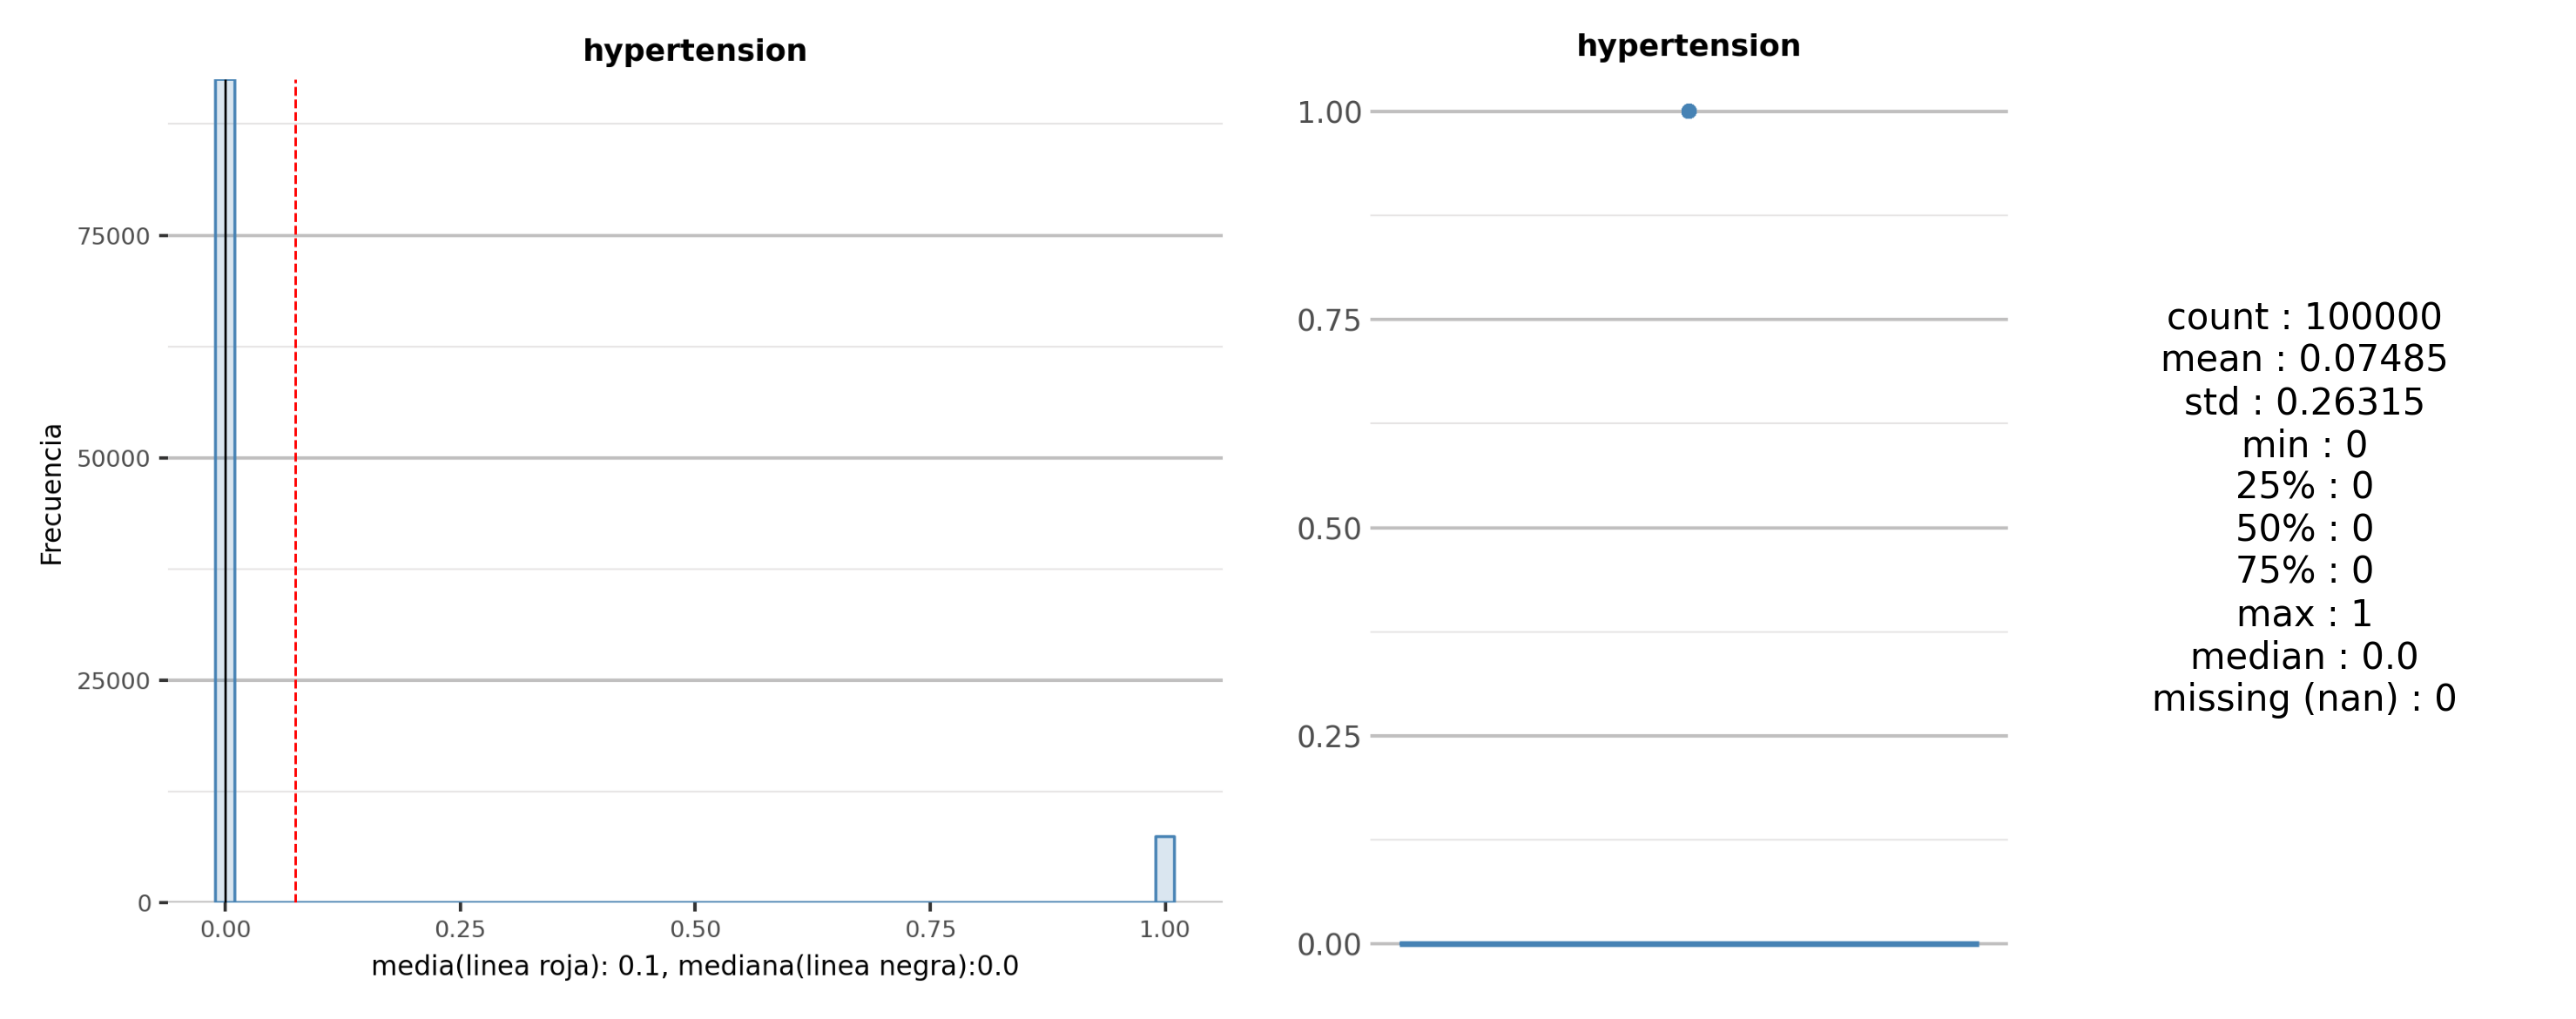

In [234]:
col = numeric_var[1]
histogram_plot = ut.histogram_plot(data,col,color_general='steelblue',
                                   color_mean='red',color_median='black',
                                   fig_size_histogram = (5,4))

box_plot = ut.box_plot(data,col,color_general='steelblue',
                       fig_size_box_plot=(3,4))

desc_text = ut.desc_plot(data,col)
plot_var_cuantitative = ut.join_plots([histogram_plot,box_plot,desc_text],
                                      [(5,4),(3,4),(2,4)])
plt.tight_layout()
plt.show()

_hypertension_ es numérica pero solo toma los valores de $(0,1)$,  o `False`/`True`, en consecuencia de ahora en adelante se tratara como una variable categórica.

### heart_disease

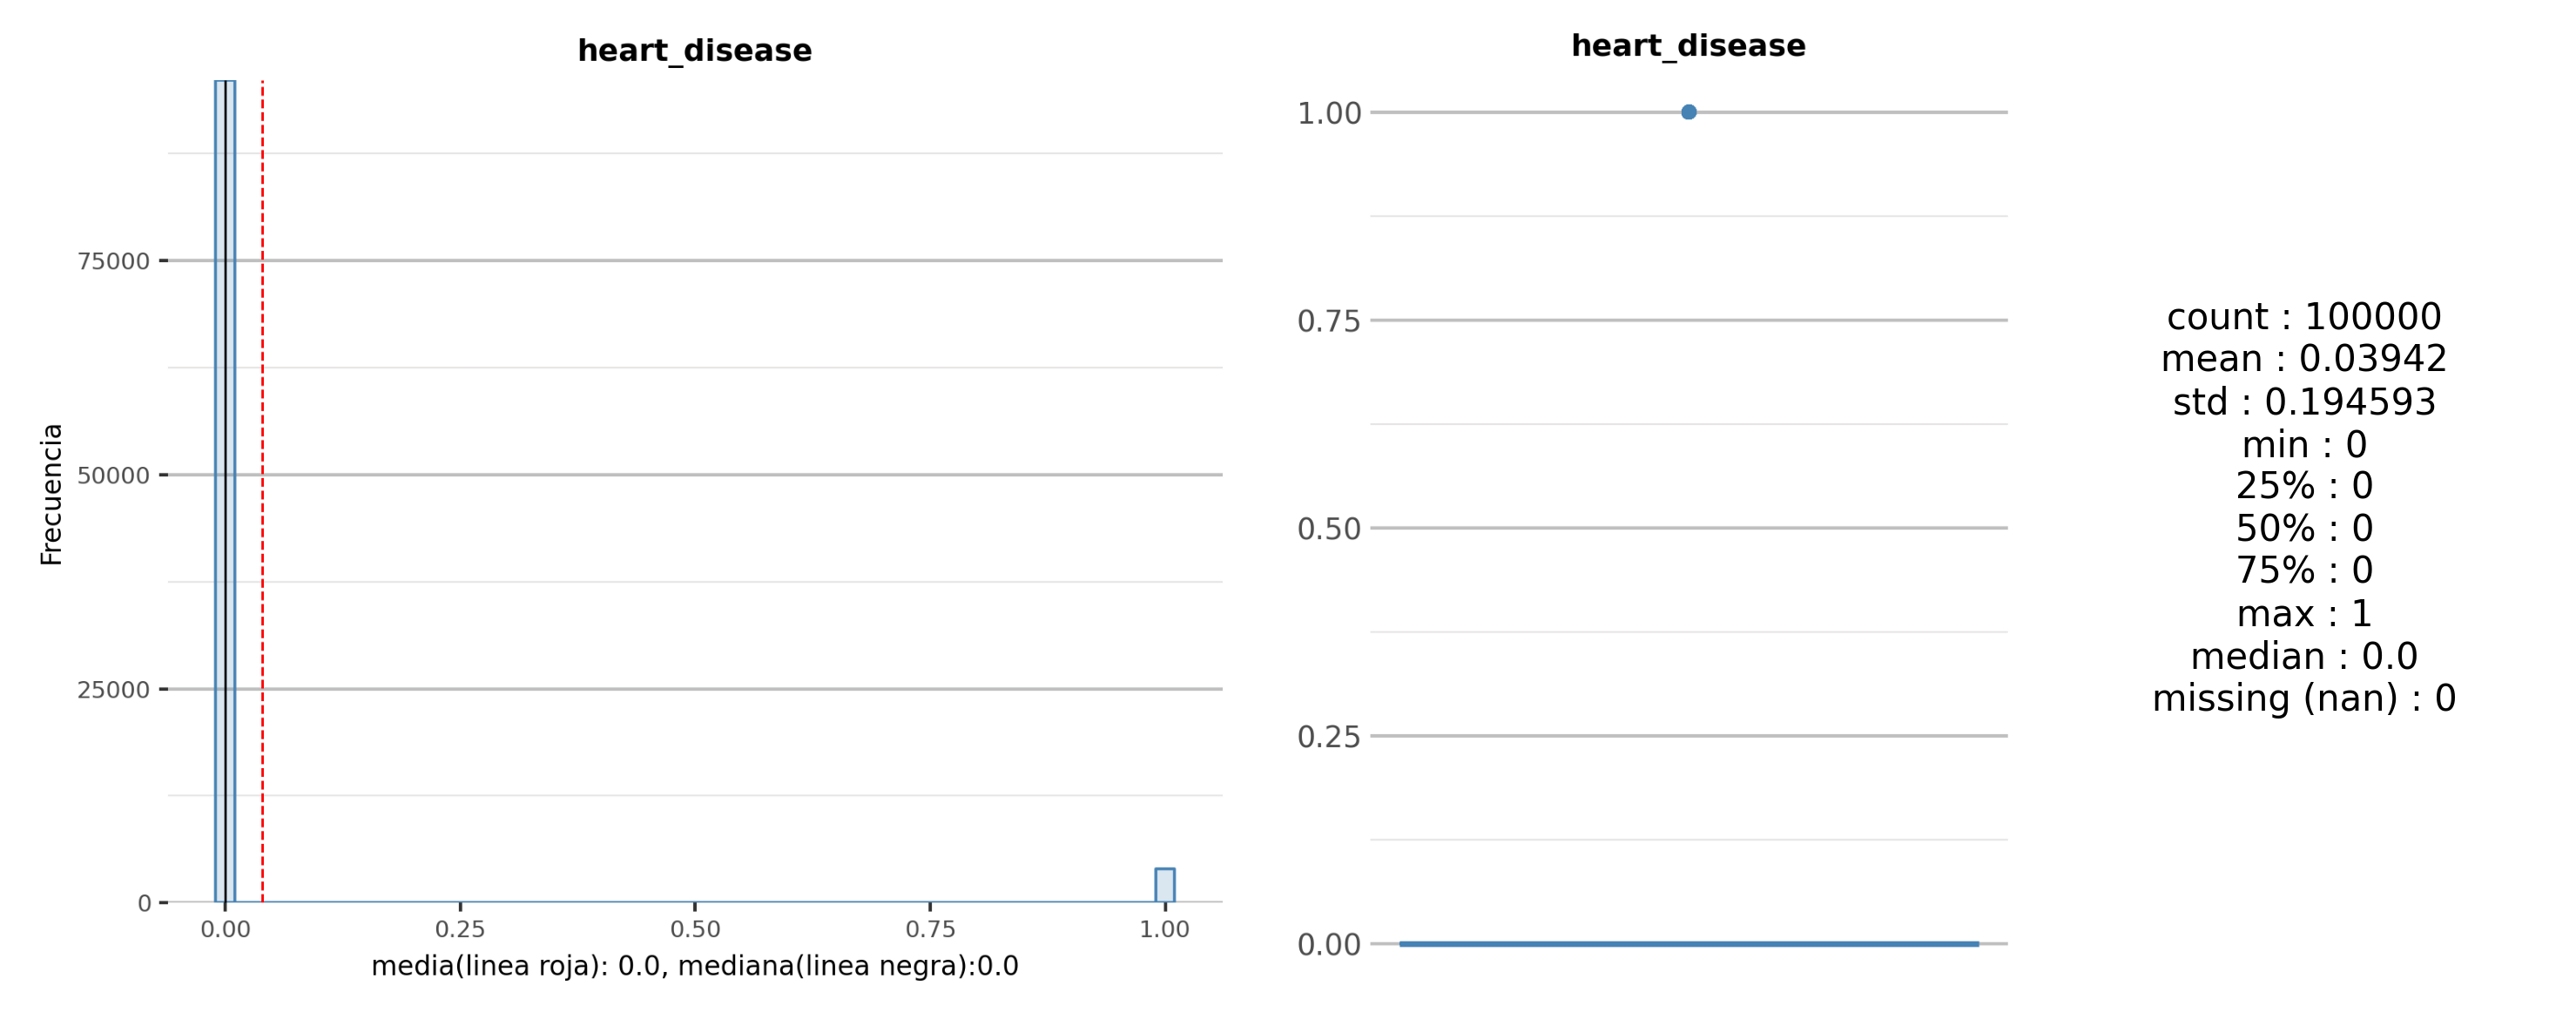

In [235]:
col = numeric_var[2]
histogram_plot = ut.histogram_plot(data,col,color_general='steelblue',
                                   color_mean='red',color_median='black',
                                   fig_size_histogram = (5,4))

box_plot = ut.box_plot(data,col,color_general='steelblue',
                       fig_size_box_plot=(3,4))

desc_text = ut.desc_plot(data,col)
plot_var_cuantitative = ut.join_plots([histogram_plot,box_plot,desc_text],
                                      [(5,4),(3,4),(2,4)])
plt.tight_layout()
plt.show()

_heart_disease_ es numérica pero solo toma los valores de $(0,1)$,  o `False`/`True`, en consecuencia de ahora en adelante de tratara como una variable categórica.

### bmi

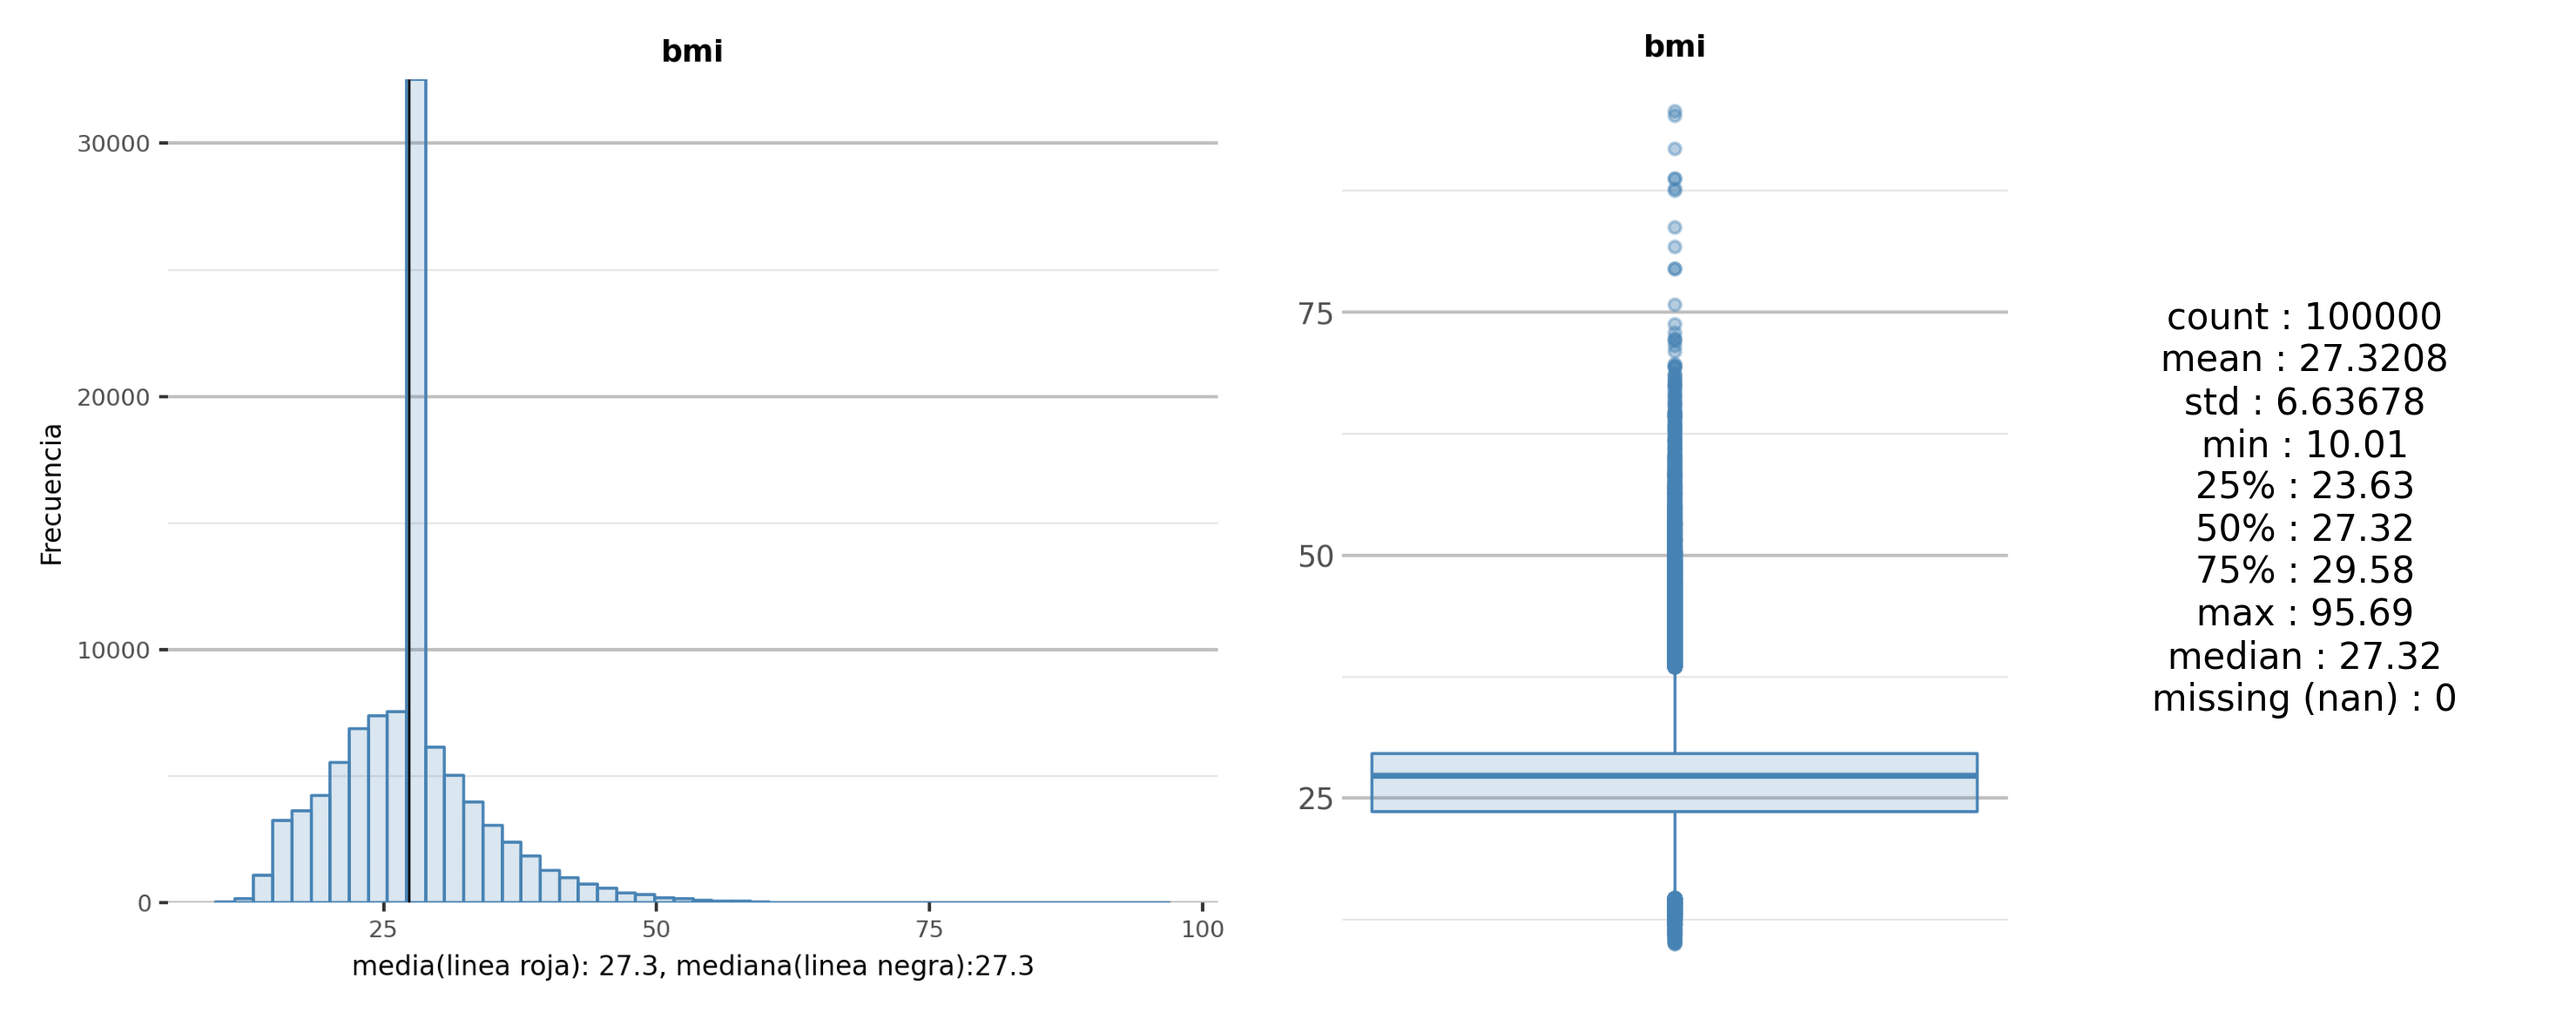

In [236]:
col = numeric_var[3]
histogram_plot = ut.histogram_plot(data,col,color_general='steelblue',
                                   color_mean='red',color_median='black',
                                   fig_size_histogram = (5,4))

box_plot = ut.box_plot(data,col,color_general='steelblue',
                       fig_size_box_plot=(3,4))

desc_text = ut.desc_plot(data,col)
plot_var_cuantitative = ut.join_plots([histogram_plot,box_plot,desc_text],
                                      [(5,4),(3,4),(2,4)])
plt.tight_layout()
plt.show()

La variable sigue una distribución normal en su histograma,alrededor de 27.3 hay una explosión en el conteo, quizás porque es un valor típico de esta variable en la población general. Existen una serie de *outliers* tanto por encima de la distribución como por debajo.

BMI presenta una distribución concentrada en valores clínicamente plausibles, pero con una cola derecha pronunciada y outliers extremos, que deberán ser tratados en fases posteriores para evitar distorsiones en el análisis.

### HbA1c_level

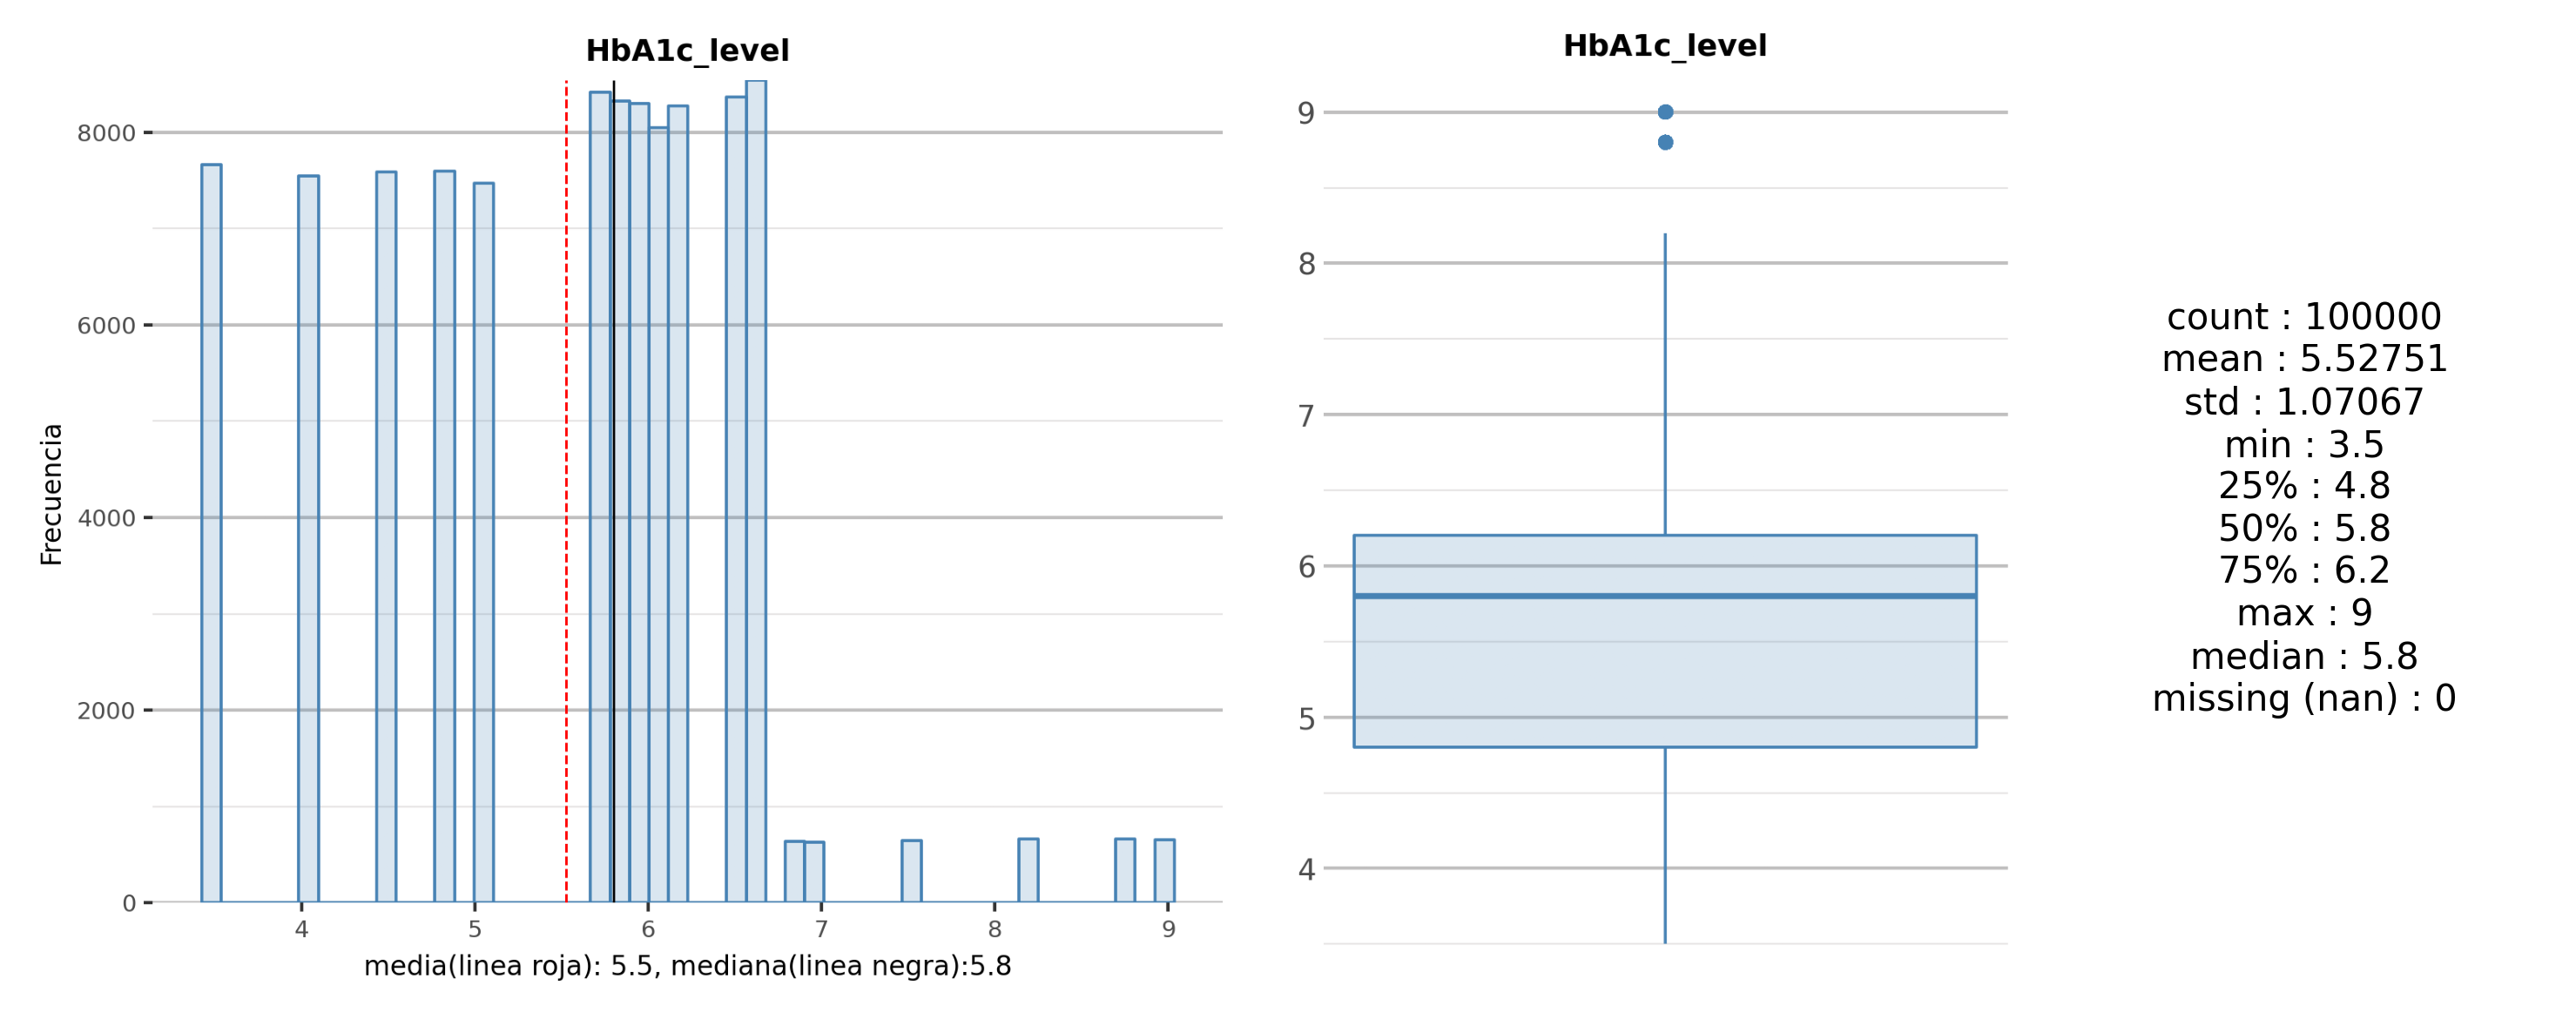

In [237]:
col = numeric_var[4]
histogram_plot = ut.histogram_plot(data,col,color_general='steelblue',
                                   color_mean='red',color_median='black',
                                   fig_size_histogram = (5,4))

box_plot = ut.box_plot(data,col,color_general='steelblue',
                       fig_size_box_plot=(3,4))

desc_text = ut.desc_plot(data,col)
plot_var_cuantitative = ut.join_plots([histogram_plot,box_plot,desc_text],
                                      [(5,4),(3,4),(2,4)])
plt.tight_layout()
plt.show()

La distribución de esta variable no es continua, ya que solo toma ciertos valores puntuales.

- La variable presenta un rango 3.5–9.0, plenamente coherente con valores clínicos reales.
- La mediana (5.8) es superior a la media (≈5.53), indicando una ligera asimetría a la izquierda.
- La mayor concentración de observaciones se sitúa entre 4.8 y 6.2, rango compatible con población no diabética y prediabética.
- Existen valores altos (≥7) poco frecuentes, compatibles con perfiles diabéticos, sin considerarse outliers erróneos.
- La dispersión es moderada (std ≈1.07), lo que sugiere buena capacidad discriminativa.
- Como consecuencia de que solo toma valores puntuales, procederemos a discretizar la variable, utilizando arboles de decisión.

### blood_glucose_level

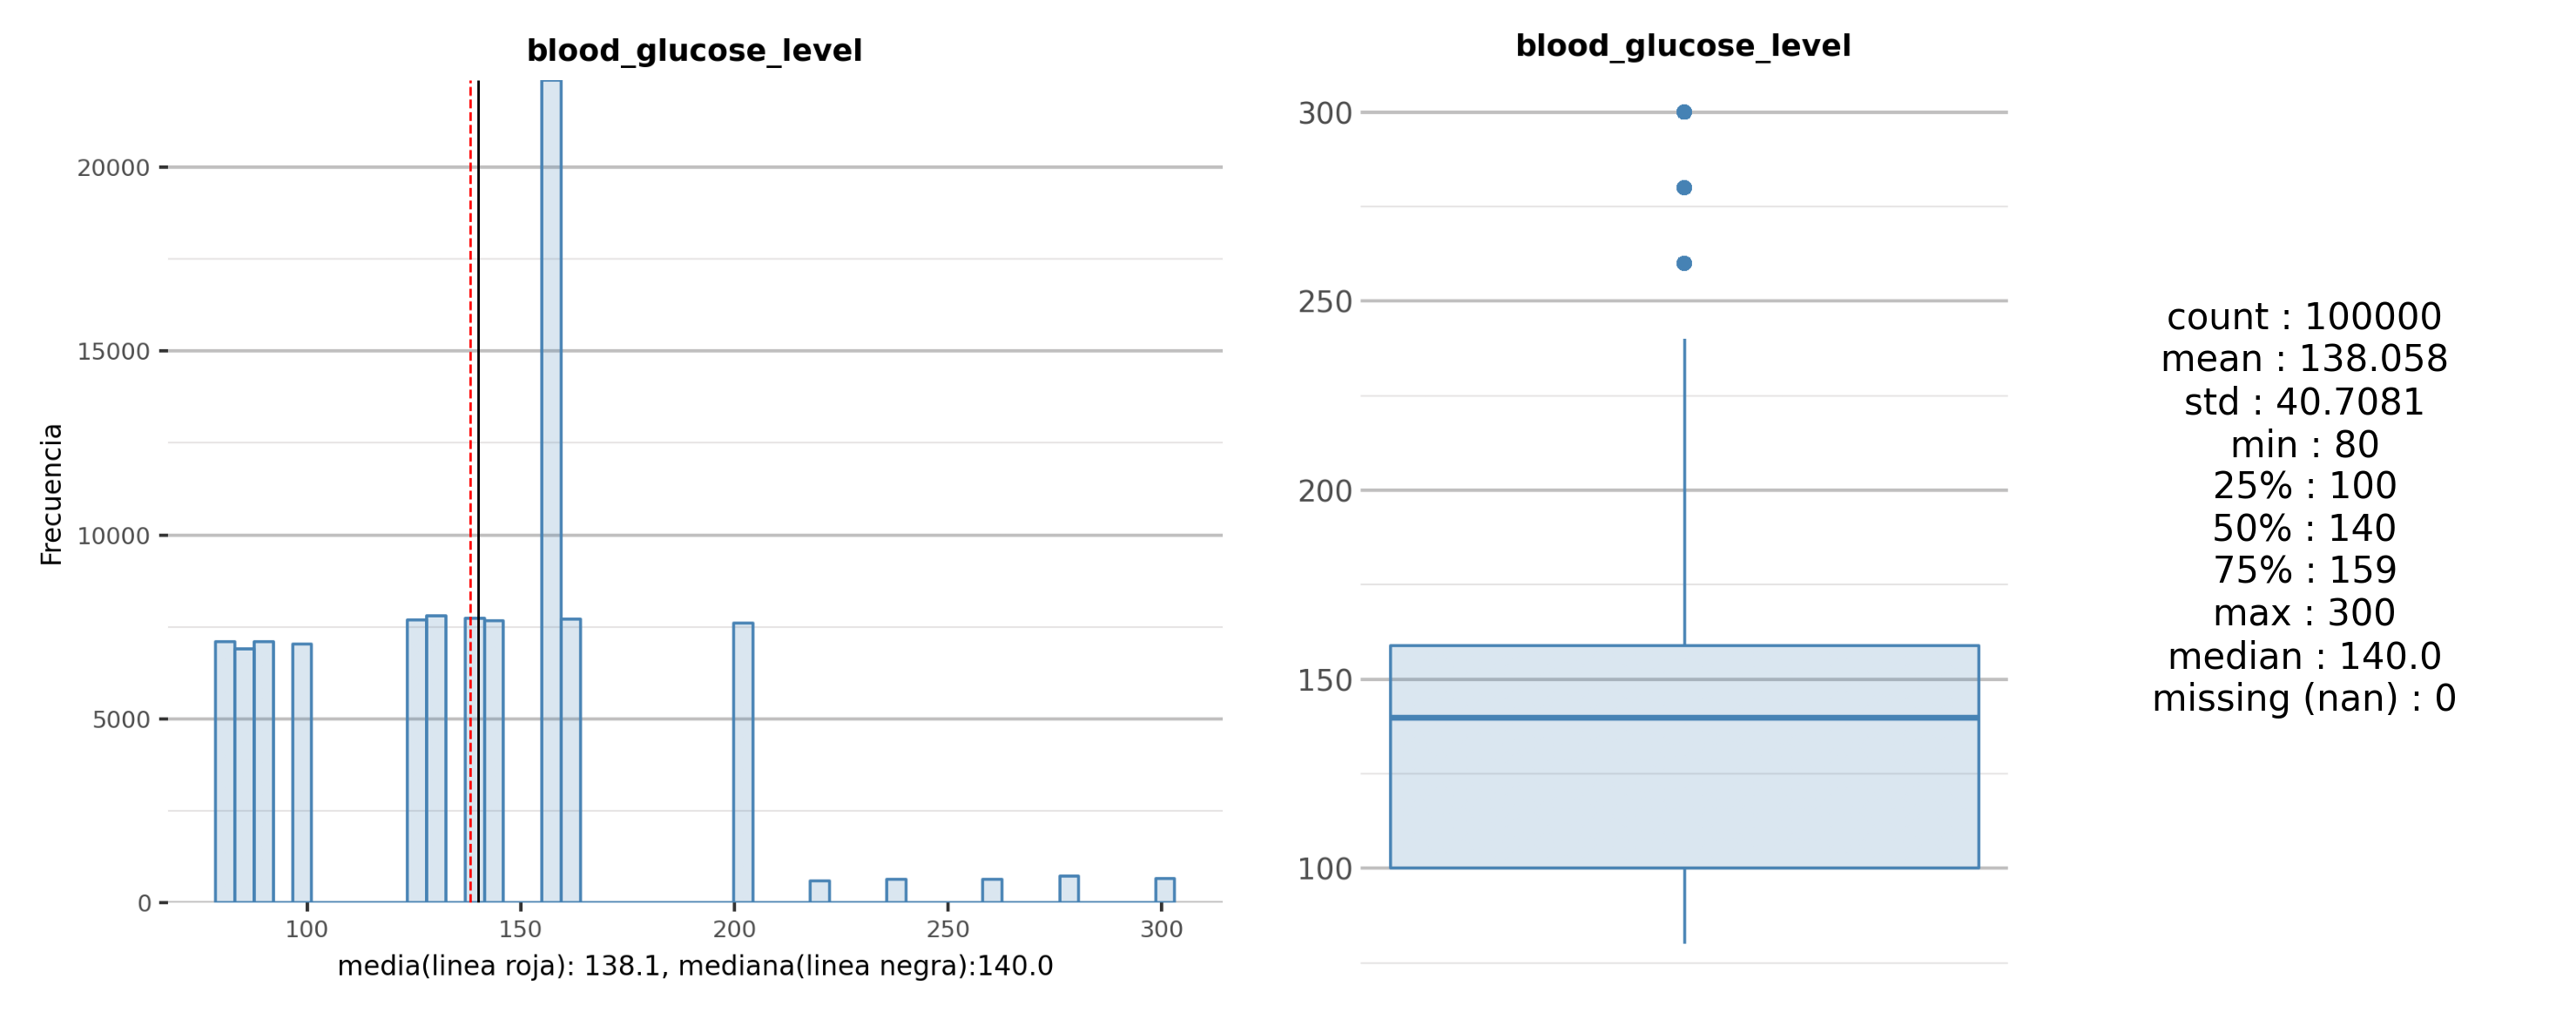

In [238]:
col = numeric_var[5]
histogram_plot = ut.histogram_plot(data,col,color_general='steelblue',
                                   color_mean='red',color_median='black',
                                   fig_size_histogram = (5,4))

box_plot = ut.box_plot(data,col,color_general='steelblue',
                       fig_size_box_plot=(3,4))

desc_text = ut.desc_plot(data,col)
plot_var_cuantitative = ut.join_plots([histogram_plot,box_plot,desc_text],
                                      [(5,4),(3,4),(2,4)])
plt.tight_layout()
plt.show()

La distribución de esta variable no es continua, ya que solo toma ciertos valores puntuales.

- La variable presenta un rango 80–300, compatible con valores clínicos reales en mediciones puntuales de glucosa.
- La mediana (140) es ligeramente superior a la media (≈138), indicando ligera asimetría a la izquierda.
- La mayor concentración de observaciones se sitúa entre 100 y 160, rango típico de población general y prediabética.
- Existen valores altos (≥200) poco frecuentes, coherentes con episodios hiperglucémicos y perfiles diabéticos.
- La dispersión es elevada (std ≈40.9), lo que sugiere heterogeneidad metabólica en la muestra.
- No se detectan valores imposibles; los extremos observados no se consideran errores, sino casos clínicamente plausibles.

Decisiones posterior al análisis univariante de variables continuas.
- hypertension y heart_disease, serán tratadas de ahora en adelante como variables categóricas binarias (0,1).

In [239]:
categoric_var.append('hypertension')
numeric_var.remove('hypertension')
categoric_var.append('heart_disease')
numeric_var.remove('heart_disease')

### 2.2 Detección de valores atípicos

In [240]:
desc_num = (
    data[numeric_var]
    .describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
    .T
)

desc_num

count        mean        std    min     1%     5%  \
age                  100000.0   41.885856  22.516840   0.08   1.08   4.00   
bmi                  100000.0   27.320767   6.636783  10.01  14.60  16.82   
HbA1c_level          100000.0    5.527507   1.070672   3.50   3.50   3.50   
blood_glucose_level  100000.0  138.058060  40.708136  80.00  80.00  80.00   

                        25%     50%     75%     95%       99%     max  
age                   24.00   43.00   60.00   80.00   80.0000   80.00  
bmi                   23.63   27.32   29.58   39.49   48.7901   95.69  
HbA1c_level            4.80    5.80    6.20    6.60    8.8000    9.00  
blood_glucose_level  100.00  140.00  159.00  200.00  280.0000  300.00

- En la variable edad, los percentiles superiores coinciden con el valor máximo (80 años), situándose dentro de un rango plausible y mostrando una distribución acotada sin valores extremos aislados.
- En BMI, aunque el percentil 99 se sitúa en torno a 48.8, el valor máximo alcanza 95.7, superando claramente los rangos habitualmente considerados plausibles en población adulta (aprox. 10–65) y sugiriendo la presencia de casos extremos que requieren validación contextual.
- En HbA1c_level, la distribución se concentra en rangos clínicamente plausibles, con una cola derecha limitada.
- En blood_glucose_level, se observa una cola derecha marcada, con valores elevados que, aunque extremos, se mantienen dentro de rangos clínicamente plausibles.

#### Validación contextual de valores extremos en BMI

In [241]:
bmi_extreme = data['bmi'] >= 65
data.loc[bmi_extreme, numeric_var].sort_values('bmi', ascending=False)

age    bmi  HbA1c_level  blood_glucose_level
87843   7.0  95.69          6.1                  130
76093  16.0  95.22          4.5                   90
69549  38.0  91.82          6.0                  160
96066  80.0  88.76          6.2                  140
4551   45.0  88.72          7.0                  300
90043  34.0  87.70          6.0                  126
22454  19.0  87.51          3.5                   85
24186  49.0  83.74          6.8                  155
71485  48.0  81.73          6.5                  130
20591  39.0  79.48          4.8                  155
58318  36.0  79.46          6.2                  220
54336  25.0  75.78          6.1                  100
20355  55.0  73.77          6.6                  160
28645  42.0  72.89          6.8                  280
21960  47.0  72.28          4.5                   90
82244  52.0  72.21          6.6                  220
71090  44.0  72.03          6.5                   85
78960  42.0  71.55          5.7                  130
63048  39.0  70.96          6.6                   85
7480   38.0  69.66          8.8                  300
32041  36.0  69.55          6.2                   85
3530   46.0  69.39          5.7                  159
562    43.0  69.37          7.5                  130
39593  54.0  69.32          5.7                  220
25914  62.0  68.61          6.6                  130
29324  32.0  68.53          4.8                   85
55036  38.0  68.47          5.8                  160
3229   67.0  68.10          6.2                  159
41272  38.0  68.00          5.8                  158
57195  60.0  67.92          6.0                  130
22027  60.0  67.54          4.0                   85
20536  68.0  67.53          9.0                  220
93844  23.0  67.49          6.0                  130
43398  68.0  67.39          6.1                  155
57728  56.0  67.27          5.7                  280
16227  39.0  66.88          6.5                  126
87270  26.0  66.84          6.2                  130
16427  12.0  66.48          4.8                  100
70226  45.0  66.37          6.2                  200
63144  39.0  66.36          6.6                  158
2072   18.0  65.93          6.0                  200
54816  35.0  65.91          6.6                  155
62421  62.0  65.59          5.7                  140
2173   41.0  65.56          4.5                  200
32849  70.0  65.45          6.5                  145
62812  40.0  65.36          7.0                  240
79599  36.0  65.11          4.5                   85

In [242]:
tab = pd.DataFrame({
    'global': data[['diabetes','hypertension','heart_disease']].mean(),
    'bmi_ge_65': data.loc[bmi_extreme, ['diabetes','hypertension','heart_disease']].mean()
})

display((tab*100).round(2).rename_axis('variable').rename(index=lambda v: f'{v}=1 (%)'))

global  bmi_ge_65
variable                              
diabetes=1 (%)         8.50      31.91
hypertension=1 (%)     7.48      17.02
heart_disease=1 (%)    3.94       6.38

### Decisión sobre el tratamiento de valores extremos en BMI

El análisis de los valores extremos de BMI (≥ 65) identifica un subconjunto muy reducido de observaciones (47 casos sobre 100.000), claramente separado del resto de la distribución (p99 ≈ 48.8). Estos valores no forman una cola continua, sino casos altamente aislados con potencial influencia desproporcionada en el análisis.

Este grupo presenta una elevada heterogeneidad en edad (entre 7 y 80 años), lo que dificulta la interpretación directa del BMI, especialmente en población infantil. Además, aunque la proporción de diabetes es notablemente superior a la del conjunto global (≈32% frente a 8.5%), el tamaño muestral extremadamente limitado impide extraer conclusiones robustas y generalizables.

Adicionalmente, no se observa una coherencia clínica uniforme, ya que algunos individuos con BMI muy elevado muestran valores de HbA1c y glucosa dentro de rangos moderados. En conjunto, su carácter excepcional y la elevada incertidumbre asociada justifican la exclusión de estas observaciones del análisis posterior para preservar la estabilidad y capacidad de generalización de los modelos.

In [243]:
data = data[data['bmi'] < 65]

### 2.3 Análisis univariante, variables categóricas.

### gender

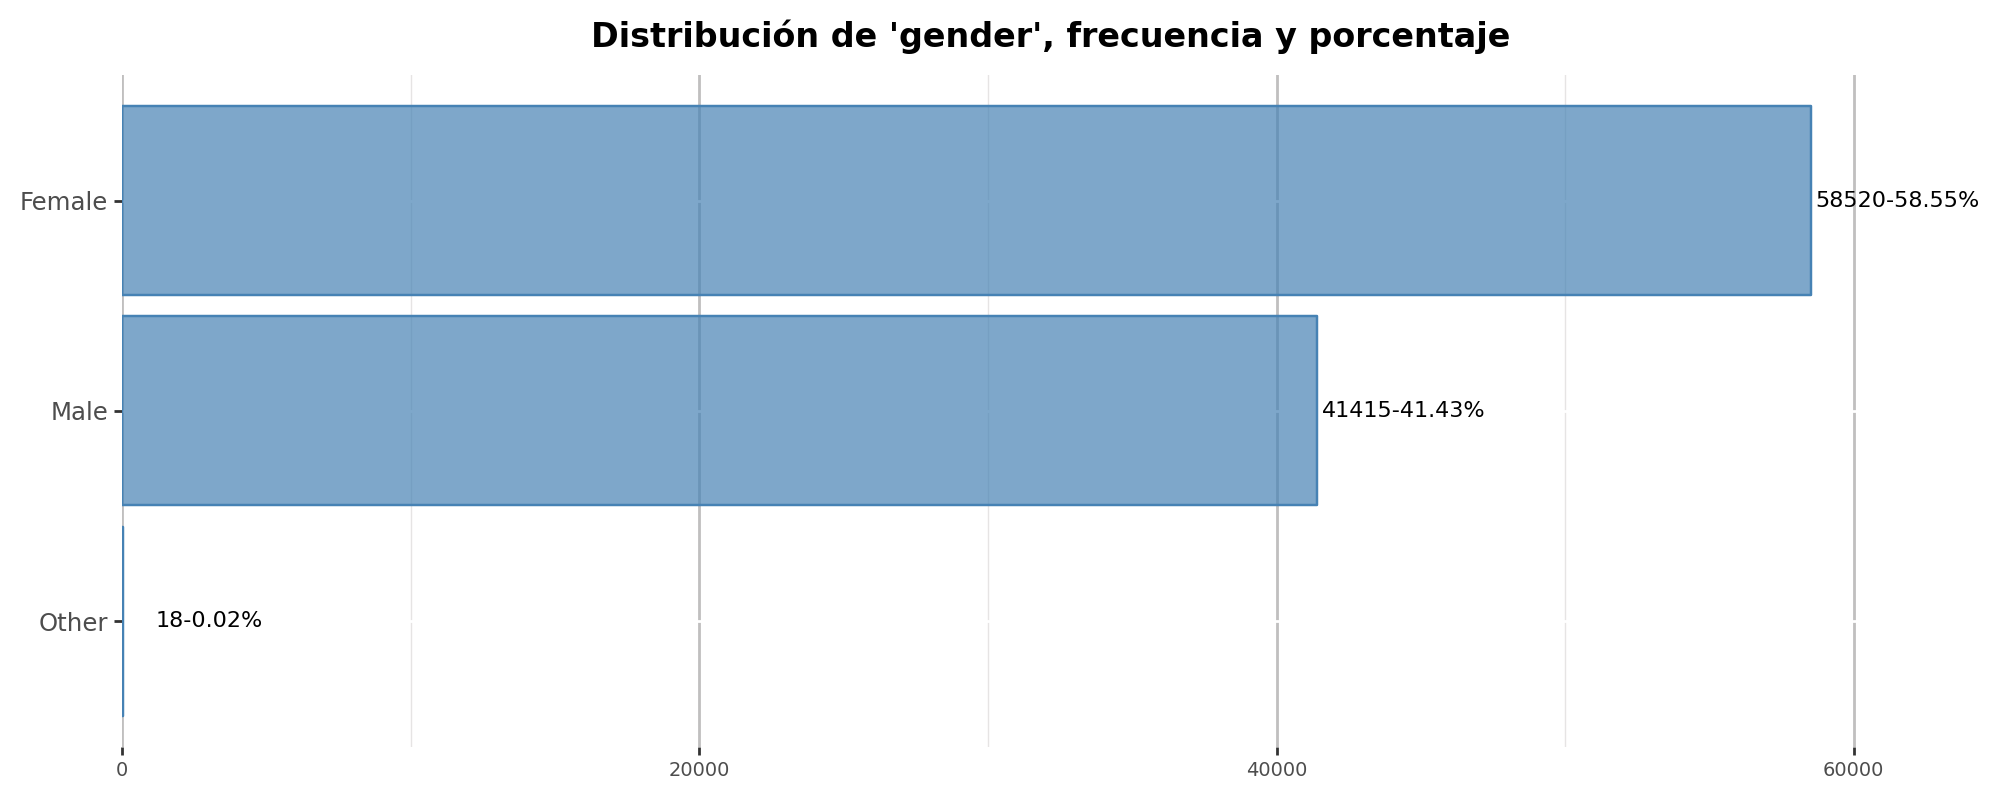

In [244]:
col = categoric_var[0]
bar_plot = ut.bar_plot(data, col,color_general='steelblue',fig_size=(10,4),nudge_y=3000)
bar_plot.show()

Observamos la presencia de un género `Other` cuyas observaciones son irrisorias respecto a los géneros masculino y femenino y por esta razón eliminaremos estas observaciones.

### smoking_history

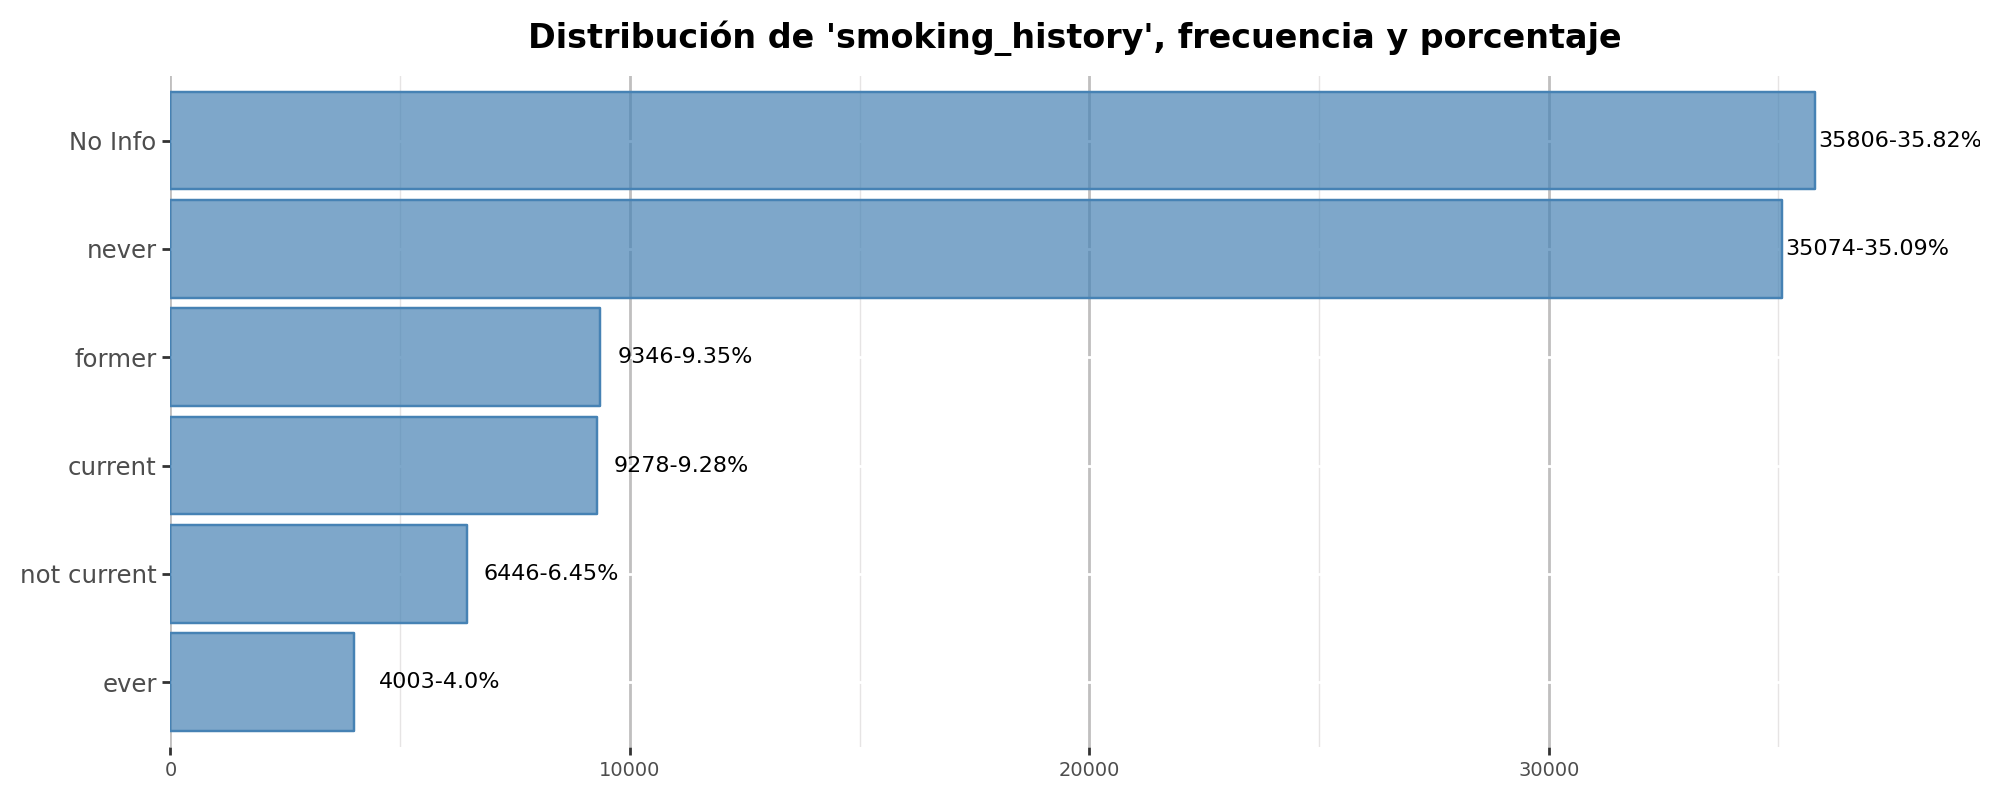

In [245]:
col = categoric_var[1]
bar_plot = ut.bar_plot(data, col,color_general='steelblue',fig_size=(10,4),nudge_y=1850)
bar_plot.show()

Podemos ver que hay una gran cantidad de falta de información. Un tercio de la información de esta variable es desconocida (No info). En cuanto a nuestras variables que son similares, vemos que hay una cierta homogeneidad en el conteo, dentro del mismo orden de magnitud. Sin embargo, sí que vemos claras diferencias entre aquellos que declaran ser fumadores ($\sim 9000$) y los que no han fumado nunca ($\sim 35,000$).

### diabetes (variable objetivo)

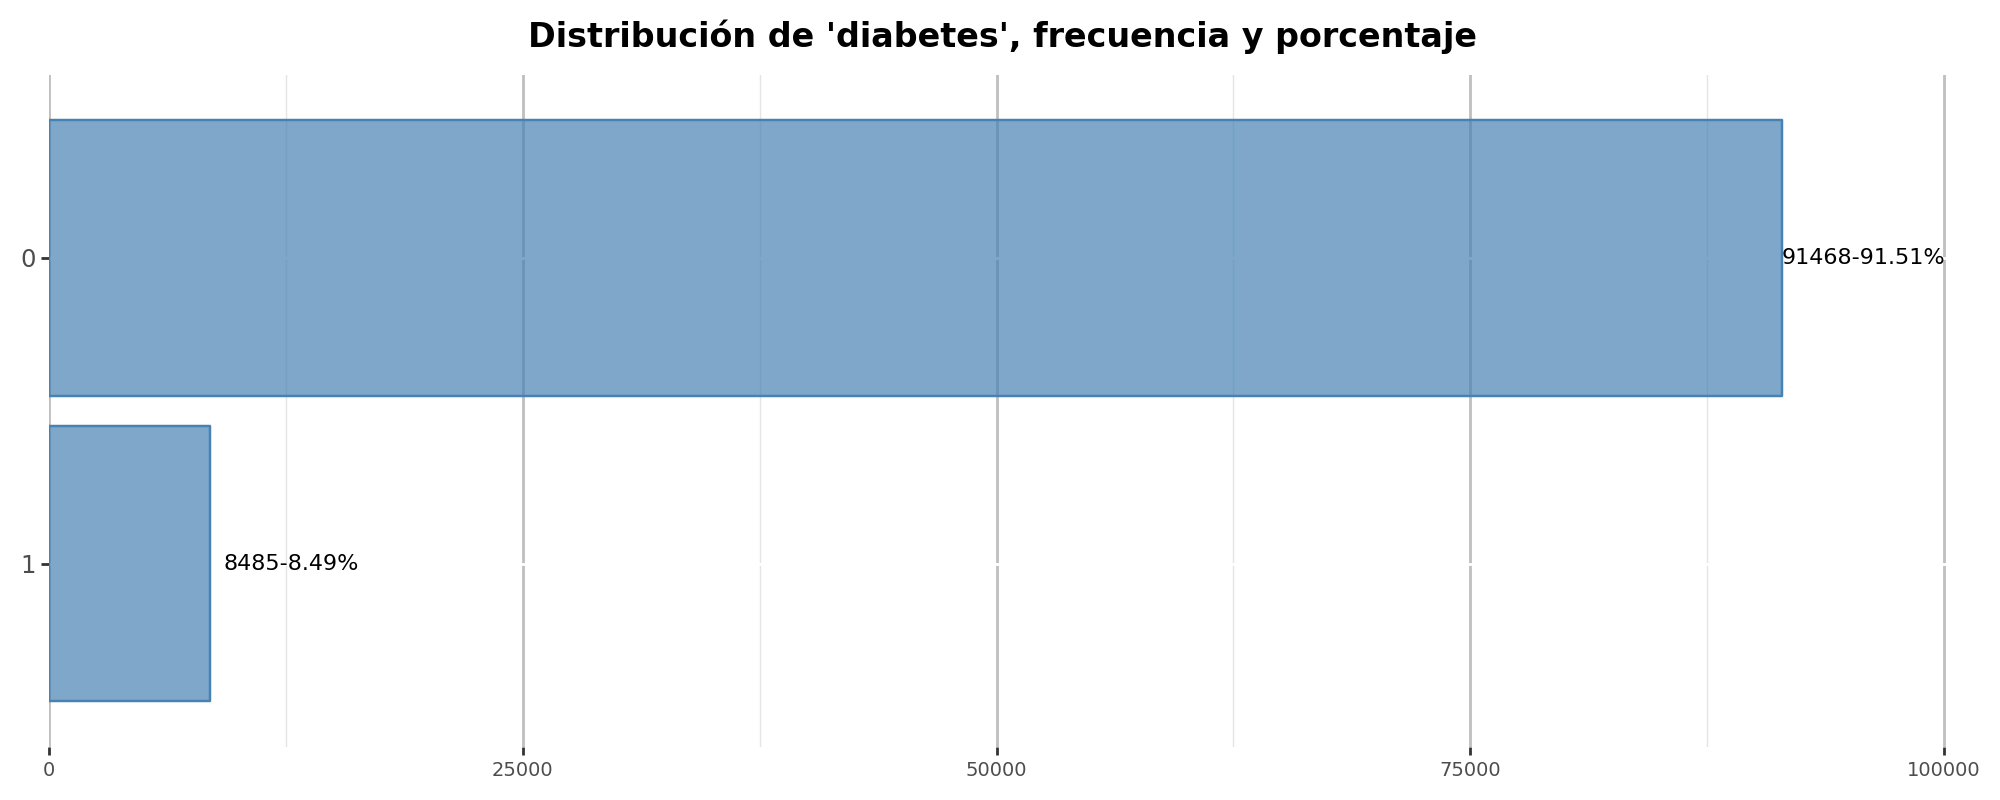

In [246]:
col = categoric_var[2]
bar_plot = ut.bar_plot(data, col,color_general='steelblue',fig_size=(10,4),nudge_y=4300)
bar_plot.show()

- La prevalencia de diabetes en el dataset es baja (~8.5%).
- La variable objetivo está claramente **desbalanceada**, con predominio de no diabéticos.
- La distribución es coherente con un escenario de cribado poblacional.

### hypertension

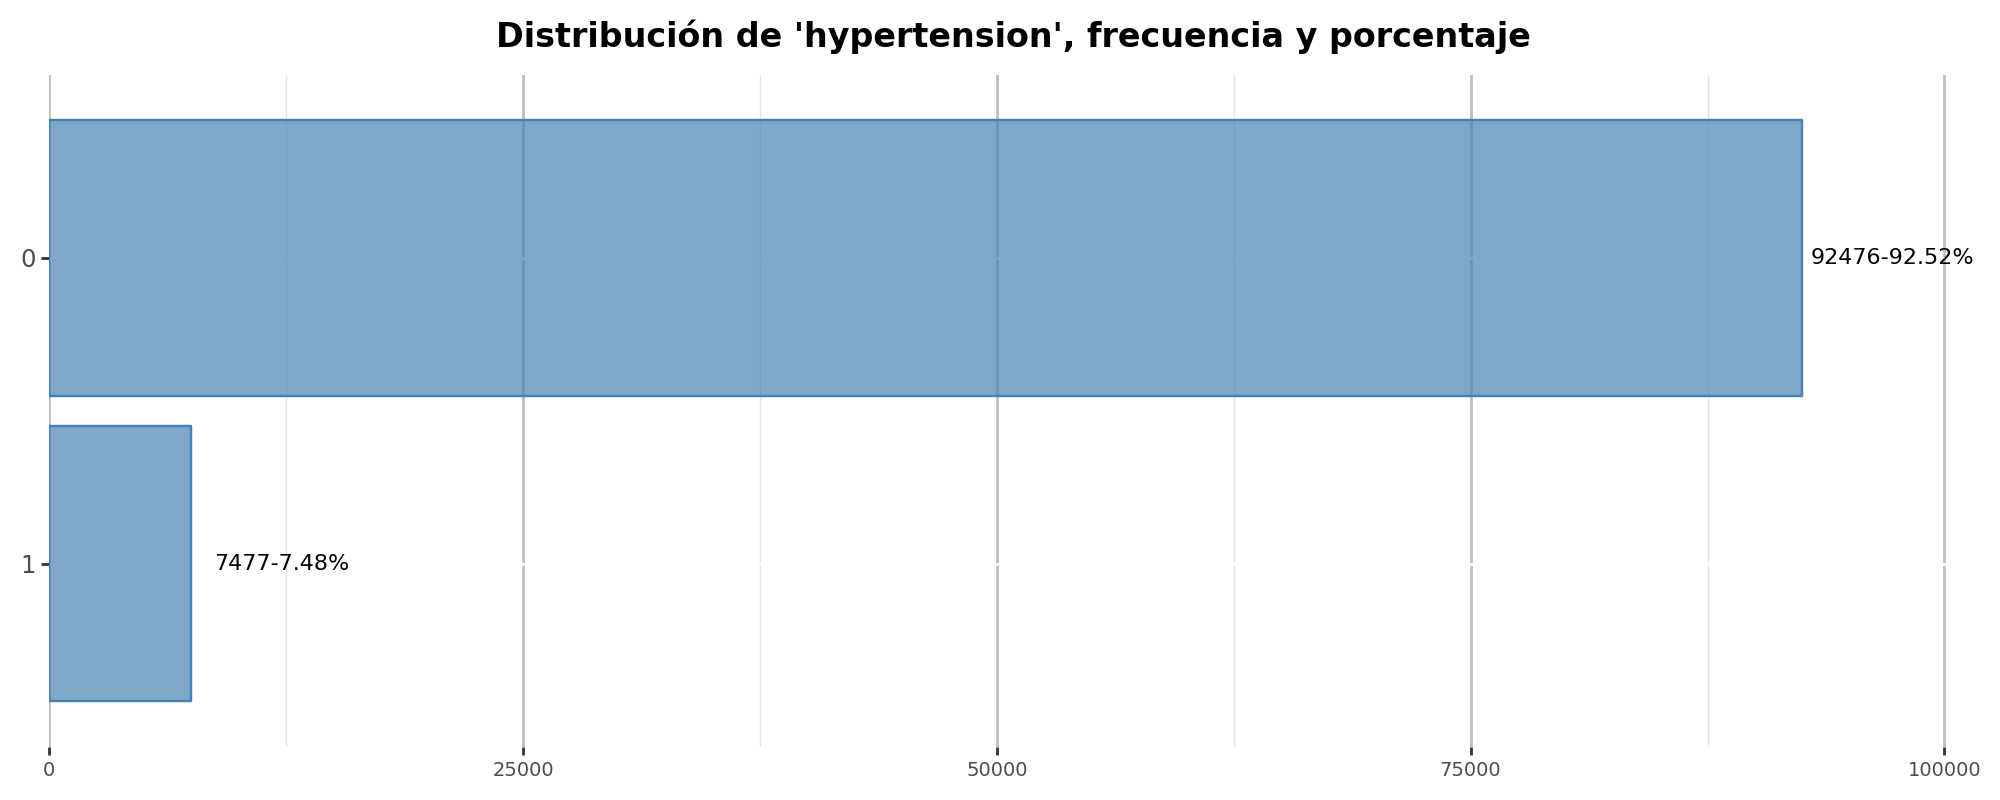

In [247]:
col = categoric_var[3]
bar_plot = ut.bar_plot(data, col,color_general='steelblue',fig_size=(10,4),nudge_y=4800)
bar_plot.show()

- La hipertensión presenta una prevalencia baja (~7.5%) en el dataset.
- La variable está **desbalanceada**, con clara mayoría de individuos sin hipertensión.
- La frecuencia observada es clínicamente plausible para una población general.
- La baja prevalencia sugiere que la hipertensión puede actuar como **factor de riesgo**, no como característica dominante.
- La variable es informativa, pero su efecto deberá evaluarse en combinación con otras variables en el análisis bi-variante.

### heart_disease

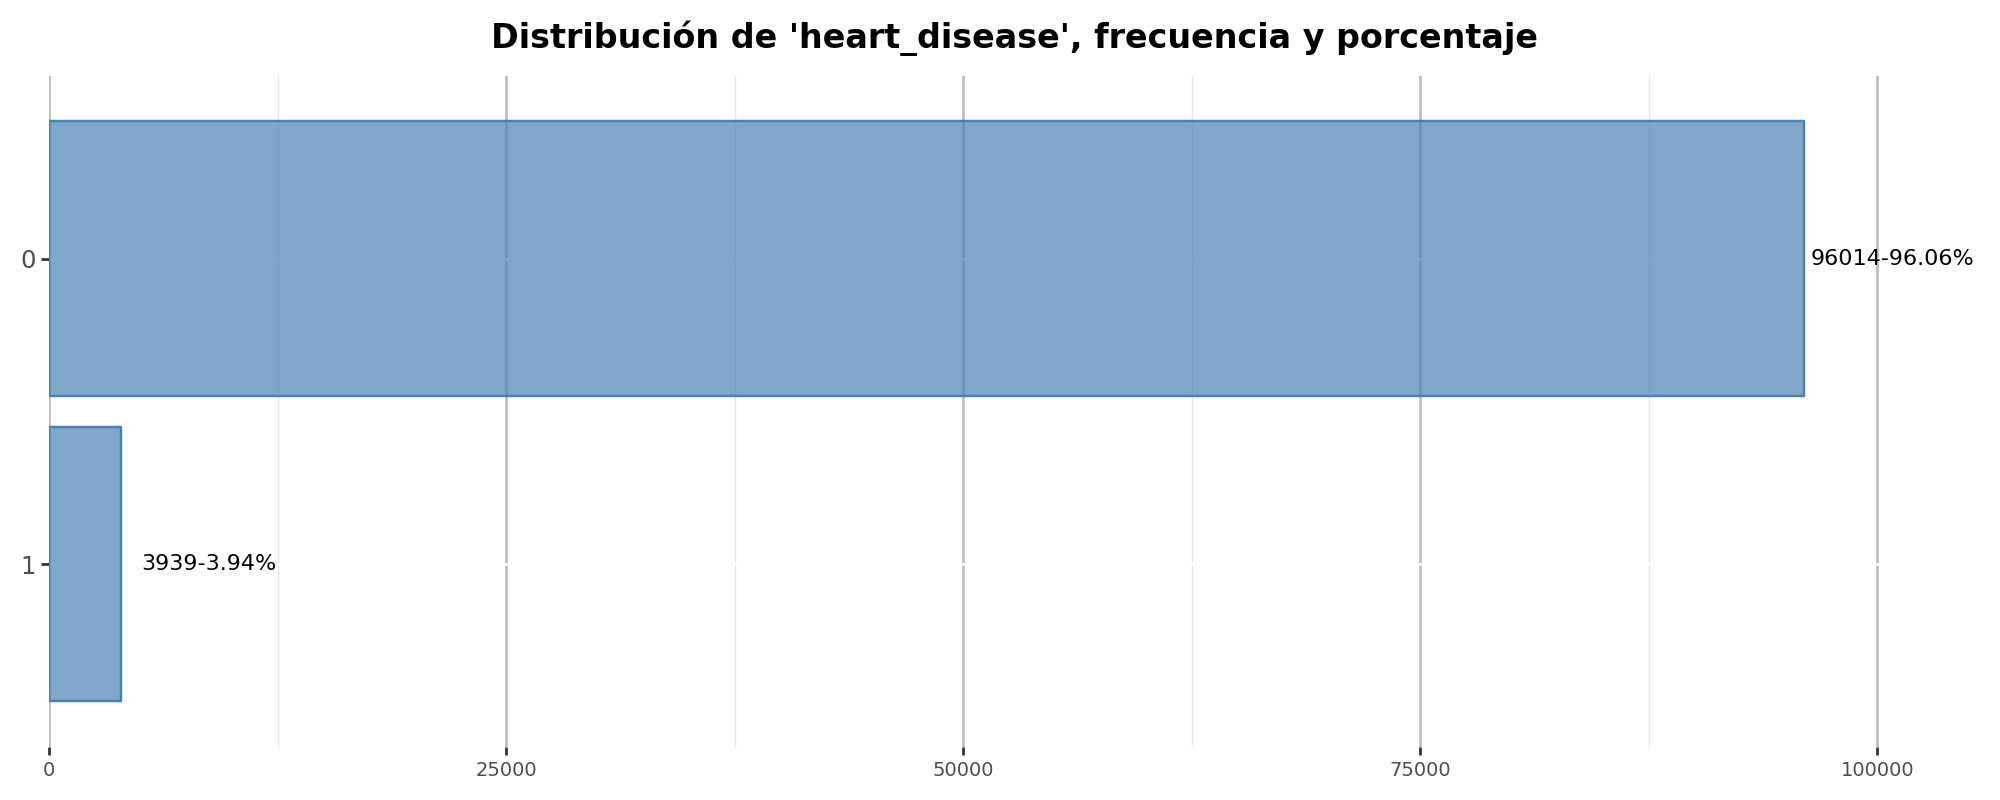

In [248]:
col = categoric_var[4]
bar_plot = ut.bar_plot(data, col,color_general='steelblue',fig_size=(10,4),nudge_y=4800)
bar_plot.show()

- La enfermedad cardíaca presenta una **prevalencia muy baja** (~3.9%) en el dataset.
- La variable está fuertemente **desbalanceada**, con una clara mayoría de individuos sin patología cardíaca.
- La frecuencia observada es coherente clínicamente para una población general.
- Al tratarse de una condición poco frecuente, su impacto aislado puede ser limitado, pero **puede aportar señal relevante en combinación con otras variables**.
- Será importante vigilar posibles celdas con baja frecuencia en análisis bivariantes y tests estadísticos.


### Acciones a realizar posterior al análisis univariante.

En consecuencia de lo observado, se toman las siguientes decisiones
- Eliminar la clase **Other** en la variable de gender, ya que las observaciones son muy pocas 0.02%.
- Se discretizaran las variables HbA1c_level y blood_glucose_level utilizando optimal binning, ya que al no ser variables continuas y dada la cantidad de observaciones y el modelo buscar clasificar pacientes con diabetes o sin diabetes.

In [249]:
data = data[data['gender']!='Other'].copy()

#### Discretización blood_glucose_level

In [250]:
col = 'blood_glucose_level'
optbin = OptimalBinning(name=col, dtype='numerical', max_n_bins=4)
optbin.fit(data[col], data['diabetes'])

optbin_df = optbin.binning_table.build()
optbin_df['IV_%'] = (optbin_df['IV']*100/optbin_df.loc['Totals','IV']).round(2)
optbin_df

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0         (-inf, 128.00)  35827   0.358503      35192    635    0.017724   
1       [128.00, 159.50)  45539   0.455686      42300   3239    0.071126   
2       [159.50, 180.00)   7705   0.077100       7009    696    0.090331   
3          [180.00, inf)  10864   0.108711       6949   3915    0.360365   
4                Special      0   0.000000          0      0    0.000000   
5                Missing      0   0.000000          0      0    0.000000   
Totals                    99935   1.000000      91450   8485    0.084905   

             WoE        IV        JS    IV_%  
0       1.637457  0.507586  0.057192   41.65  
1        0.19203  0.015519  0.001937    1.27  
2      -0.067892  0.000366  0.000046    0.03  
3       -1.80371  0.695178  0.076753   57.04  
4            0.0  0.000000  0.000000    0.00  
5            0.0  0.000000  0.000000    0.00  
Totals            1.218648  0.135927  100.00

Creamos una nueva columna con los valores obtenidos, y la agregamos a las variables categóricas.

In [251]:
data['blood_glucose_level_binned'] = optbin.transform(data['blood_glucose_level'], metric='bins')
categoric_var.append('blood_glucose_level_binned')

#### Discretización HbA1c_level

In [252]:
col = 'HbA1c_level'
optbin = OptimalBinning(name=col, dtype='numerical', max_n_bins=5)
optbin.fit(data[col], data['diabetes'])

optbin_df = optbin.binning_table.build()
optbin_df['IV_%'] = (optbin_df['IV']*100/optbin_df.loc['Totals','IV']).round(2)
optbin_df

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 5.75)  46248   0.462781      45547    701    0.015157   
1       [5.75, 6.55)  41268   0.412948      38053   3215    0.077905   
2        [6.55, inf)  12419   0.124271       7850   4569    0.367904   
3            Special      0   0.000000          0      0    0.000000   
4            Missing      0   0.000000          0      0    0.000000   
Totals                99935   1.000000      91450   8485    0.084905   

             WoE        IV        JS    IV_%  
0         1.7965  0.746333  0.082476   47.21  
1        0.09366  0.003484  0.000435    0.22  
2      -1.836273  0.831172  0.091388   52.57  
3            0.0  0.000000  0.000000    0.00  
4            0.0  0.000000  0.000000    0.00  
Totals            1.580989  0.174299  100.00

Creamos una nueva columna con los valores obtenidos, y la agregamos a las variables categóricas.

In [253]:
data['HbA1c_level_binned'] = optbin.transform(data['HbA1c_level'], metric='bins')
categoric_var.append('HbA1c_level_binned')

In [254]:
col = 'age'
optbin = OptimalBinning(name=col, dtype='numerical', max_n_bins=8)
optbin.fit(data[col], data['diabetes'])

optbin_df = optbin.binning_table.build()
optbin_df['IV_%'] = (optbin_df['IV']*100/optbin_df.loc['Totals','IV']).round(2)
optbin_df

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0         (-inf, 5.50)   6271   0.062751       6263      8    0.001276   
1        [5.50, 12.50)   6079   0.060830       6051     28    0.004606   
2       [12.50, 27.50)  17331   0.173423      17157    174    0.010040   
3       [27.50, 38.50)  14355   0.143643      13935    420    0.029258   
4       [38.50, 46.50)  11319   0.113264      10631    688    0.060783   
5       [46.50, 53.50)  10825   0.108320       9819   1006    0.092933   
6       [53.50, 60.50)  10130   0.101366       8686   1444    0.142547   
7         [60.50, inf)  23625   0.236404      18908   4717    0.199661   
8              Special      0   0.000000          0      0    0.000000   
9              Missing      0   0.000000          0      0    0.000000   
Totals                  99935   1.000000      91450   8485    0.084905   

             WoE        IV        JS    IV_%  
0       4.285481  0.289453  0.021567   21.18  
1       2.998282  0.188494  0.017438   13.79  
2       2.213614  0.369904  0.038637   27.07  
3       1.124412  0.115679  0.013743    8.47  
4       0.360248  0.012668  0.001575    0.93  
5      -0.099155  0.001110  0.000139    0.08  
6      -0.583197  0.043857  0.005406    3.21  
7       -0.98908  0.345352  0.041491   25.27  
8            0.0  0.000000  0.000000    0.00  
9            0.0  0.000000  0.000000    0.00  
Totals            1.366516  0.139995  100.00

### 2.4 Análisis bi-variantes, variables numéricas.

### age

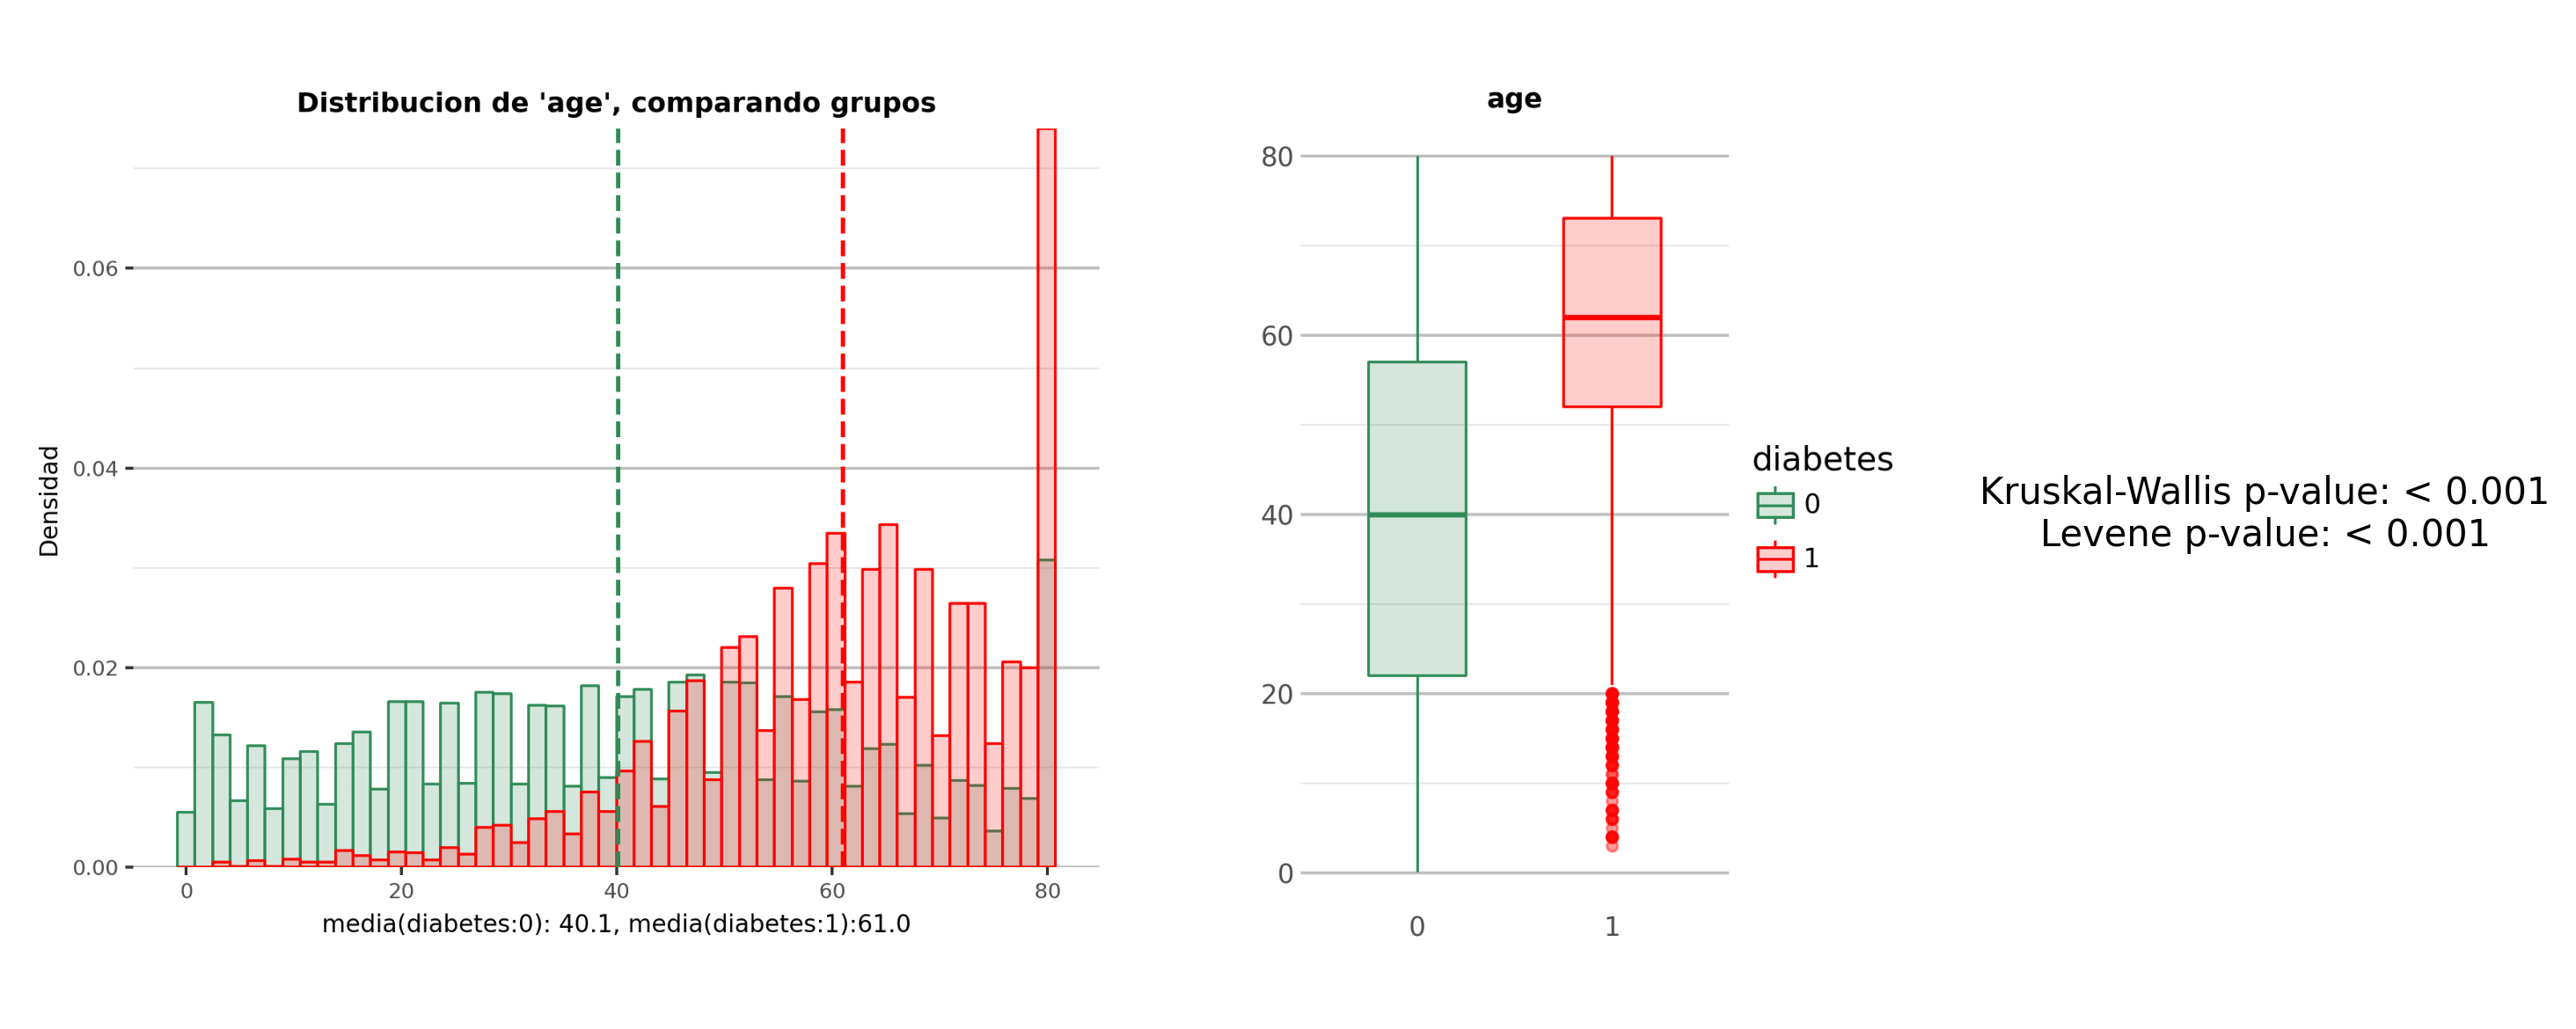

In [255]:
col=numeric_var[0]
hist_per_target_plot = ut.hist_per_target_plot(data,col,'diabetes',
                                               colors_per_group={'0':'seagreen','1':'red'},
                                               fig_size=(5,4))
box_per_target_plot = ut.box_per_target_plot(data,col,'diabetes',
                                             colors_per_group={'0':'seagreen','1':'red'},
                                             fig_size_box_plot=(3,4))
desc_text_per_target = ut.desc_text_per_target(data,'age','diabetes')

plot_var_cuantitative =  ut.join_plots([hist_per_target_plot,box_per_target_plot,desc_text_per_target],
                                       [(5,4),(3,4),(2,4)]
                                    )
plt.tight_layout()
plt.show()

### bmi

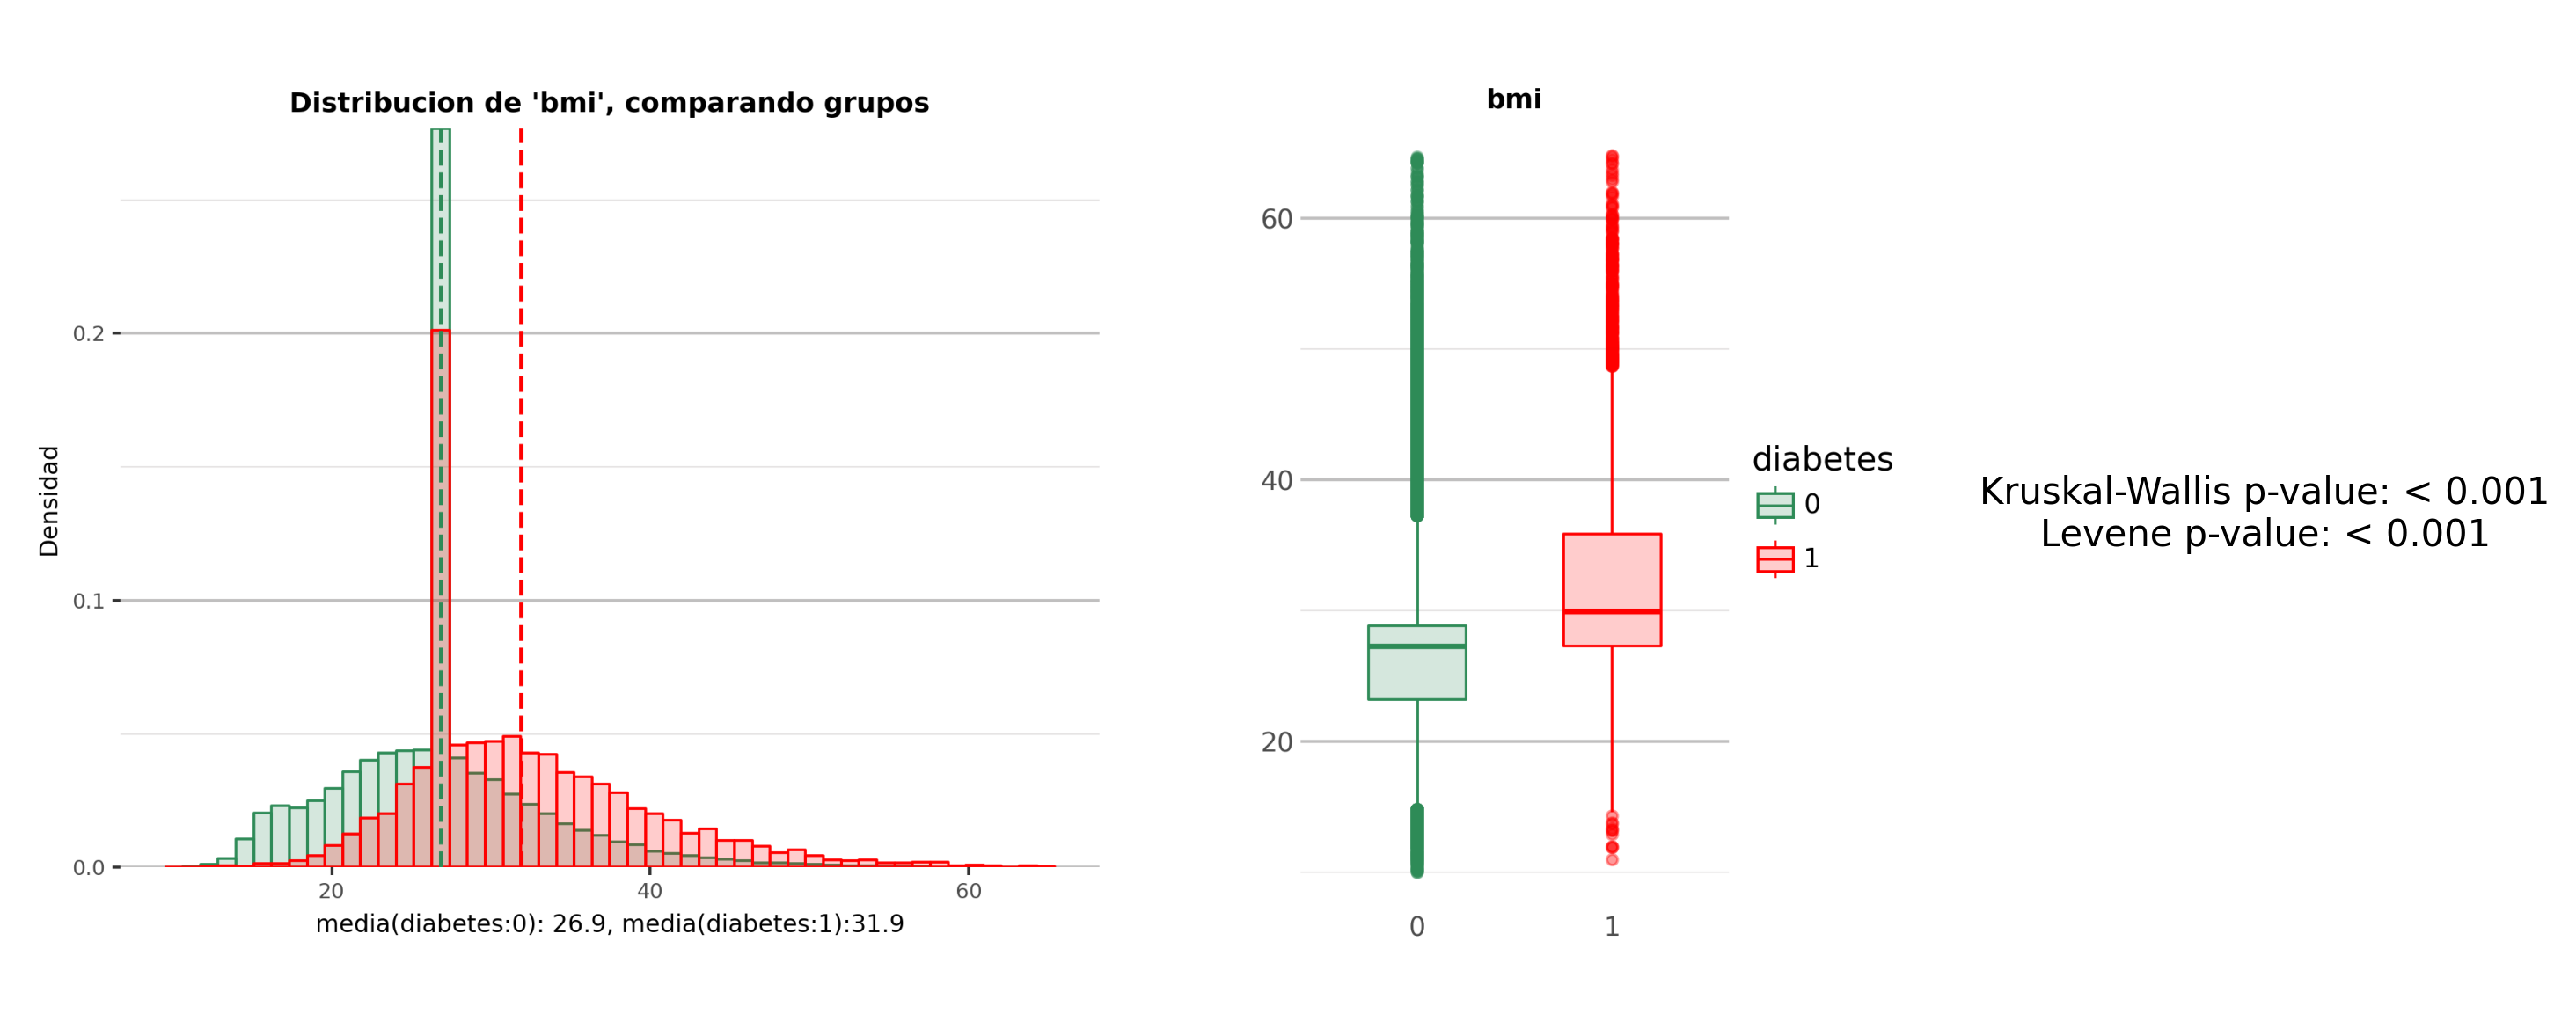

In [256]:
col=numeric_var[1]
hist_per_target_plot = ut.hist_per_target_plot(data,col,'diabetes',
                                               colors_per_group={'0':'seagreen','1':'red'},
                                               fig_size=(5,4))
box_per_target_plot = ut.box_per_target_plot(data,col,'diabetes',
                                             colors_per_group={'0':'seagreen','1':'red'},
                                             fig_size_box_plot=(3,4))
desc_text_per_target = ut.desc_text_per_target(data,'age','diabetes')

plot_var_cuantitative =  ut.join_plots([hist_per_target_plot,box_per_target_plot,desc_text_per_target],
                                       [(5,4),(3,4),(2,4)]
                                    )
plt.tight_layout()
plt.show()

### HbA1c_level

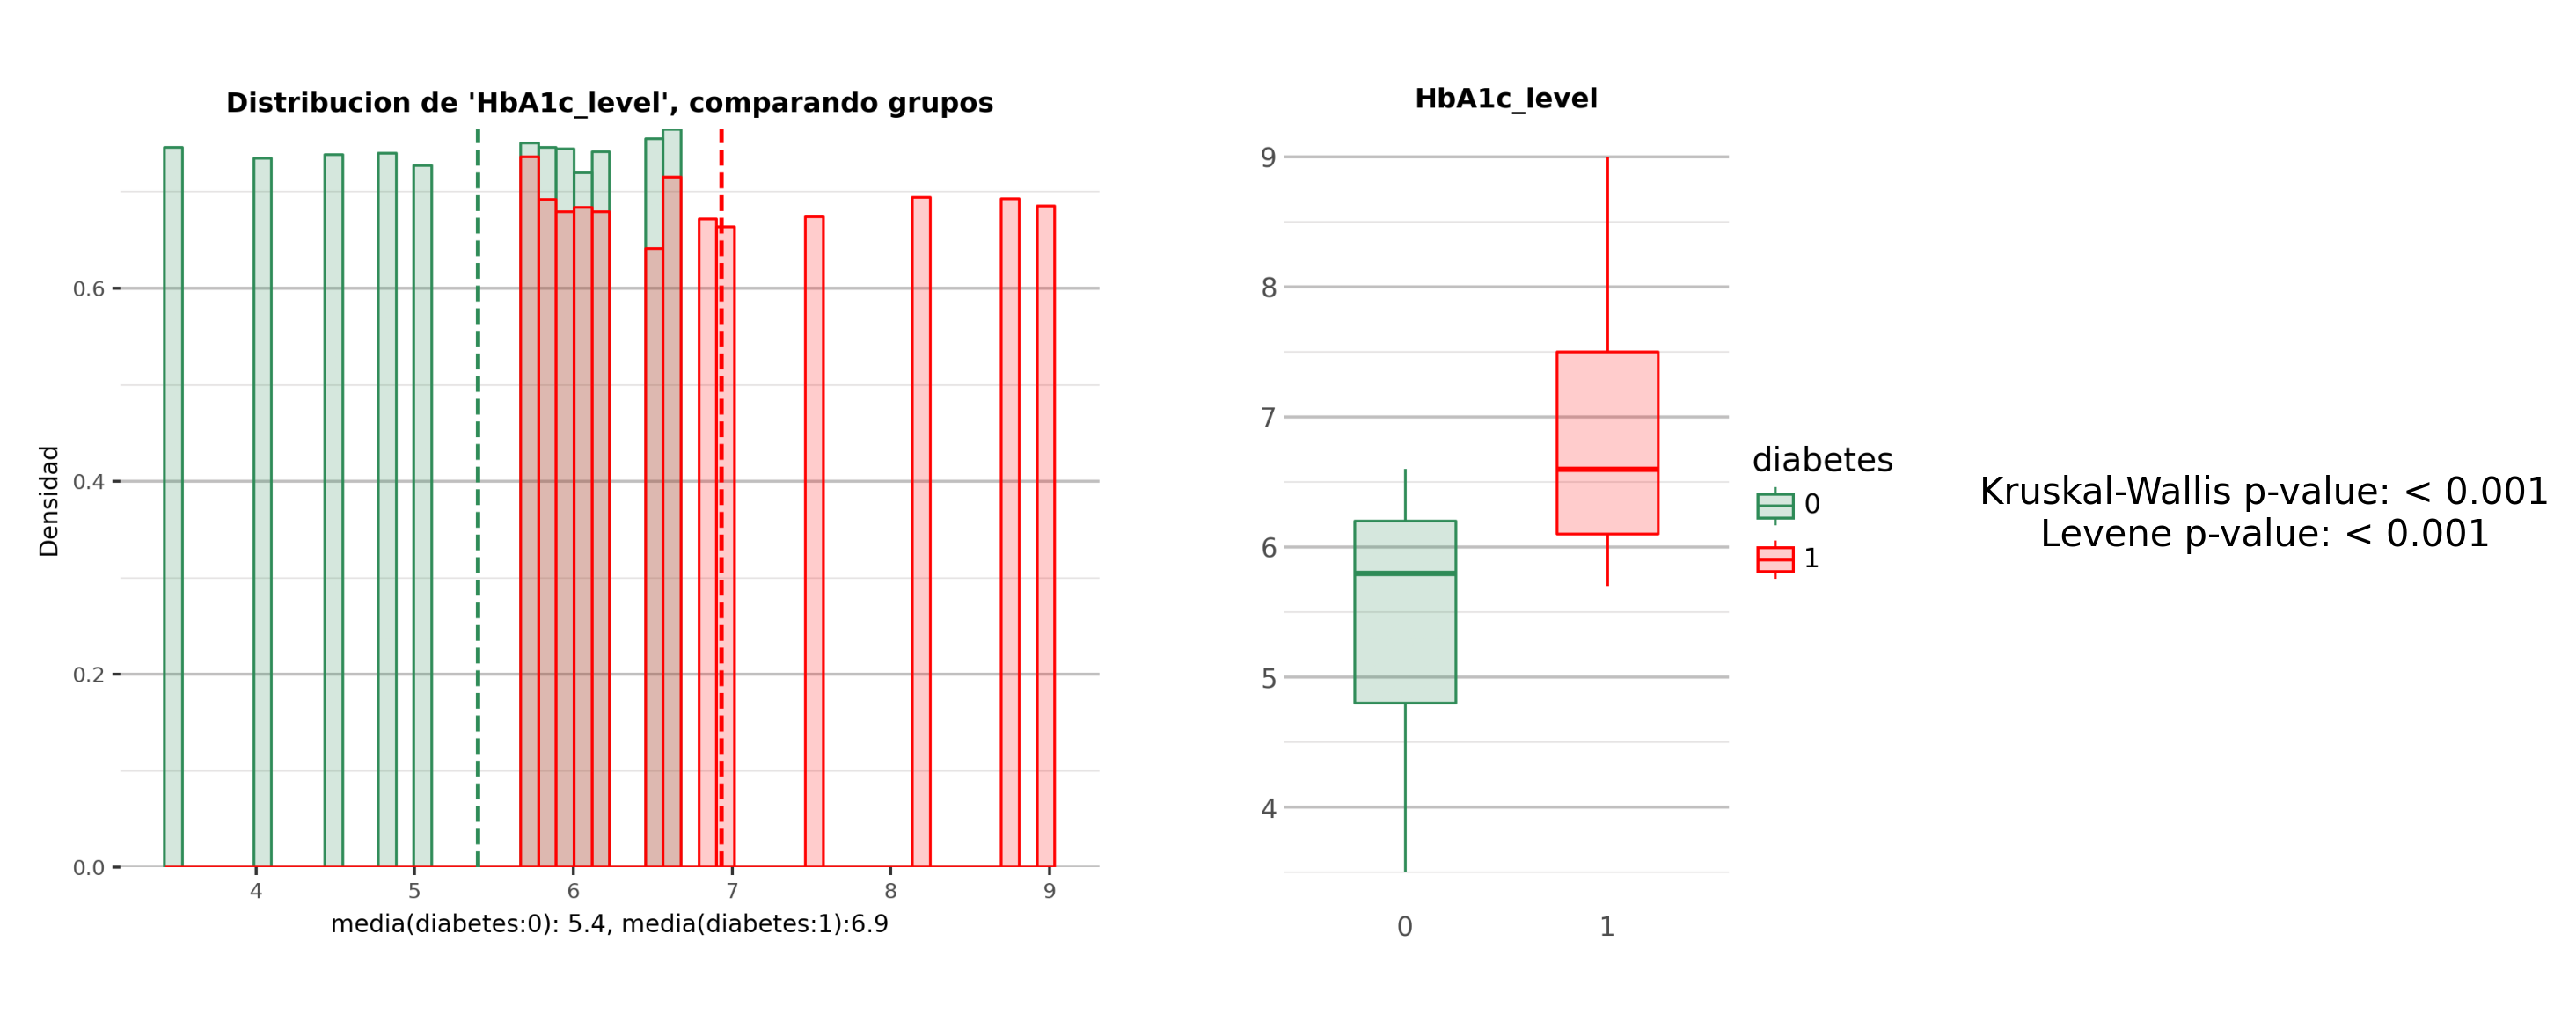

In [257]:
col=numeric_var[2]
hist_per_target_plot = ut.hist_per_target_plot(data,col,'diabetes',
                                               colors_per_group={'0':'seagreen','1':'red'},
                                               fig_size=(5,4))
box_per_target_plot = ut.box_per_target_plot(data,col,'diabetes',
                                             colors_per_group={'0':'seagreen','1':'red'},
                                             fig_size_box_plot=(3,4))
desc_text_per_target = ut.desc_text_per_target(data,'age','diabetes')

plot_var_cuantitative =  ut.join_plots([hist_per_target_plot,box_per_target_plot,desc_text_per_target],
                                       [(5,4),(3,4),(2,4)]
                                    )
plt.tight_layout()
plt.show()

### blood_glucose_level

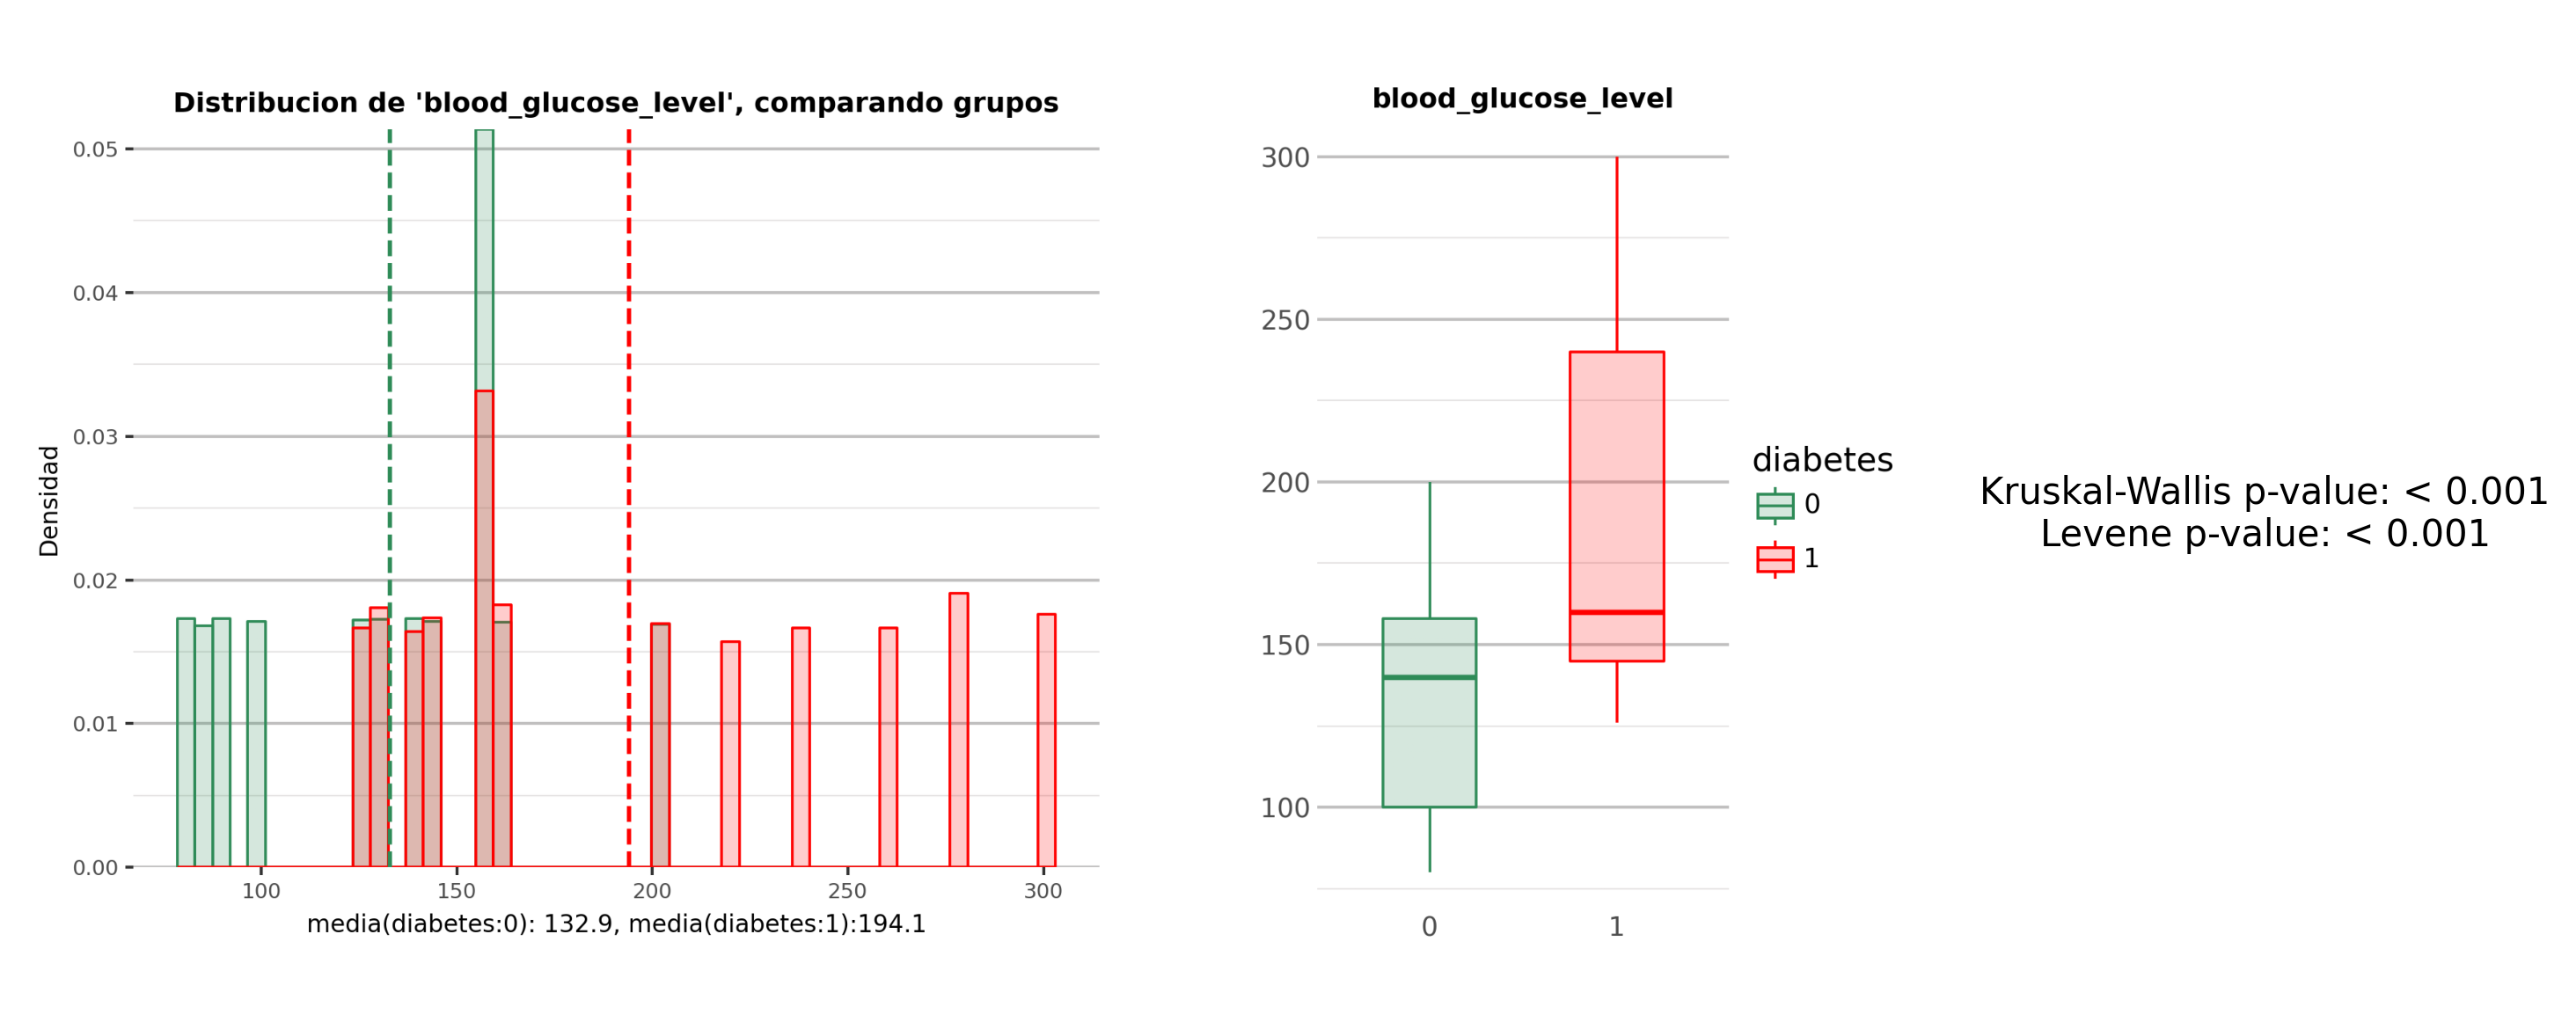

In [258]:
col=numeric_var[3]
hist_per_target_plot = ut.hist_per_target_plot(data,col,'diabetes',
                                               colors_per_group={'0':'seagreen','1':'red'},
                                               fig_size=(5,4))
box_per_target_plot = ut.box_per_target_plot(data,col,'diabetes',
                                             colors_per_group={'0':'seagreen','1':'red'},
                                             fig_size_box_plot=(3,4))
desc_text_per_target = ut.desc_text_per_target(data,'age','diabetes')

plot_var_cuantitative =  ut.join_plots([hist_per_target_plot,box_per_target_plot,desc_text_per_target],
                                       [(5,4),(3,4),(2,4)]
                                    )
plt.tight_layout()
plt.show()

#### Contrastes estadísticos entre grupos (variables cuantitativas)

Para todas las variables cuantitativas analizadas (edad, BMI, HbA1c y nivel de glucosa), los contrastes estadísticos muestran resultados consistentes. El test de Kruskal–Wallis (p < 0.001) permite rechazar la hipótesis nula de igualdad de distribuciones, indicando diferencias estadísticamente significativas entre individuos con y sin diabetes. Asimismo, el test de Levene (p < 0.001) rechaza la hipótesis de homogeneidad de varianzas, evidenciando una dispersión distinta de estas variables entre ambos grupos.

### Matriz de correlación variables continuas

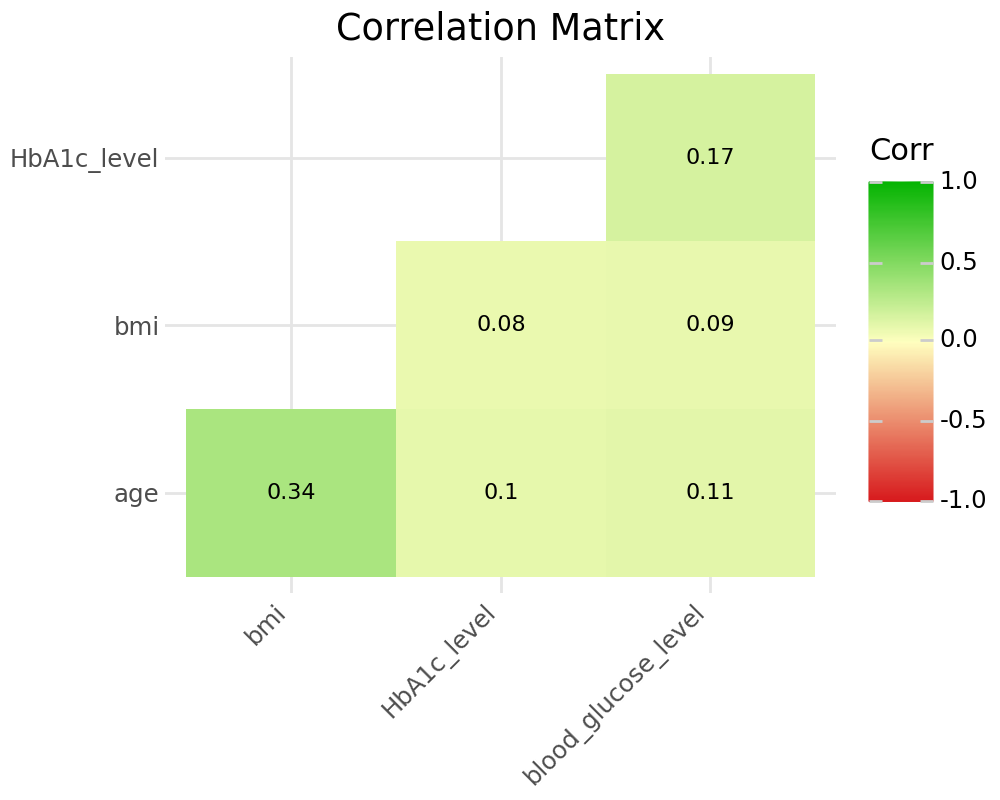

In [259]:
ut.corr_plot(data,numeric_var,(5,4)).show()

No se observan correlaciones relevantes entre variables continuas, se puede afirmar que son linealmente independientes

### 2.5 Análisis bi-variantes, variables categóricas.

In [260]:
# Eliminamos diabetes de las variables categoricas
categoric_var.remove('diabetes')

### gender

Frecuencia                        Porcentaje por clase             
diabetes          0     1 Total Frecuencia                    0     1  Total
gender                                                                      
Female        54071  4449            58520                92.40  7.60  100.0
Male          37379  4036            41415                90.25  9.75  100.0
Total         91450  8485            99935                91.51  8.49  100.0

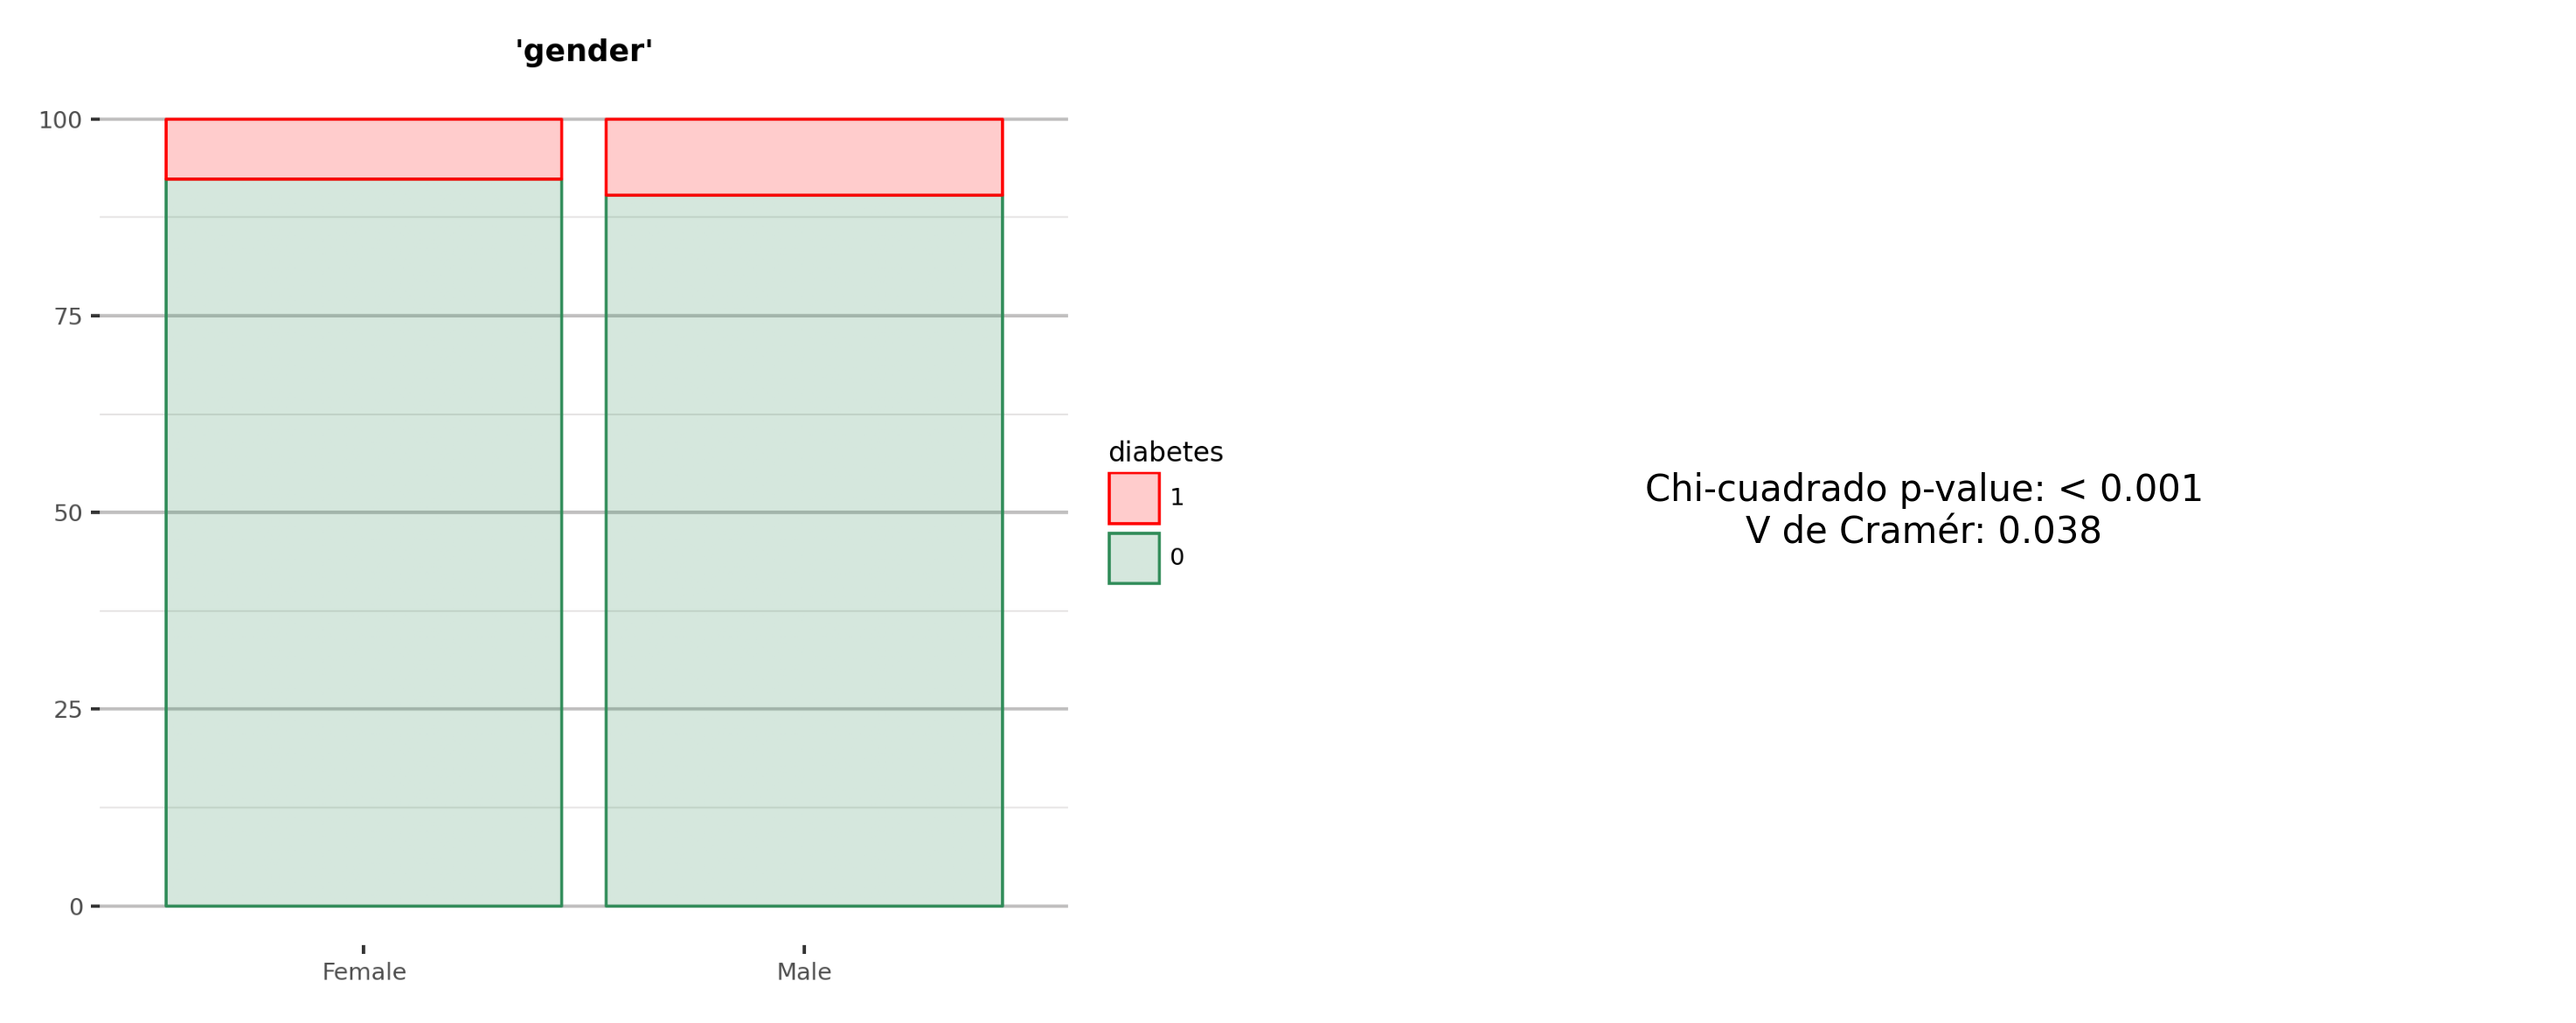

In [261]:
col = categoric_var[0]
cross_tab_per_target = ut.cross_tab_per_target(data,col,'diabetes')
cat_variables_per_group = ut.cat_per_group_plot(data,col,'diabetes',
                                                colors_per_group={'0':'seagreen','1':'red'},
                                                fig_size=(5,4),order='proportion')
desc_text_per_target = ut.desc_text_per_target(data,col,'diabetes')
show_all = ut.join_plots([cat_variables_per_group,desc_text_per_target],[(5,4),(5,4)])
display(cross_tab_per_target)
plt.tight_layout()
plt.show()

### smoking_history

Frecuencia                        Porcentaje por clase         \
diabetes                 0     1 Total Frecuencia                    0      1   
smoking_history                                                                 
No Info              34347  1453            35800                95.94   4.06   
never                31735  3336            35071                90.49   9.51   
current               8333   945             9278                89.81  10.19   
not current           5748   690             6438                89.28  10.72   
ever                  3530   472             4002                88.21  11.79   
former                7757  1589             9346                83.00  17.00   
Total                91450  8485            99935                91.51   8.49   

                        
diabetes         Total  
smoking_history         
No Info          100.0  
never            100.0  
current          100.0  
not current      100.0  
ever             100.0  
former           100.0  
Total            100.0

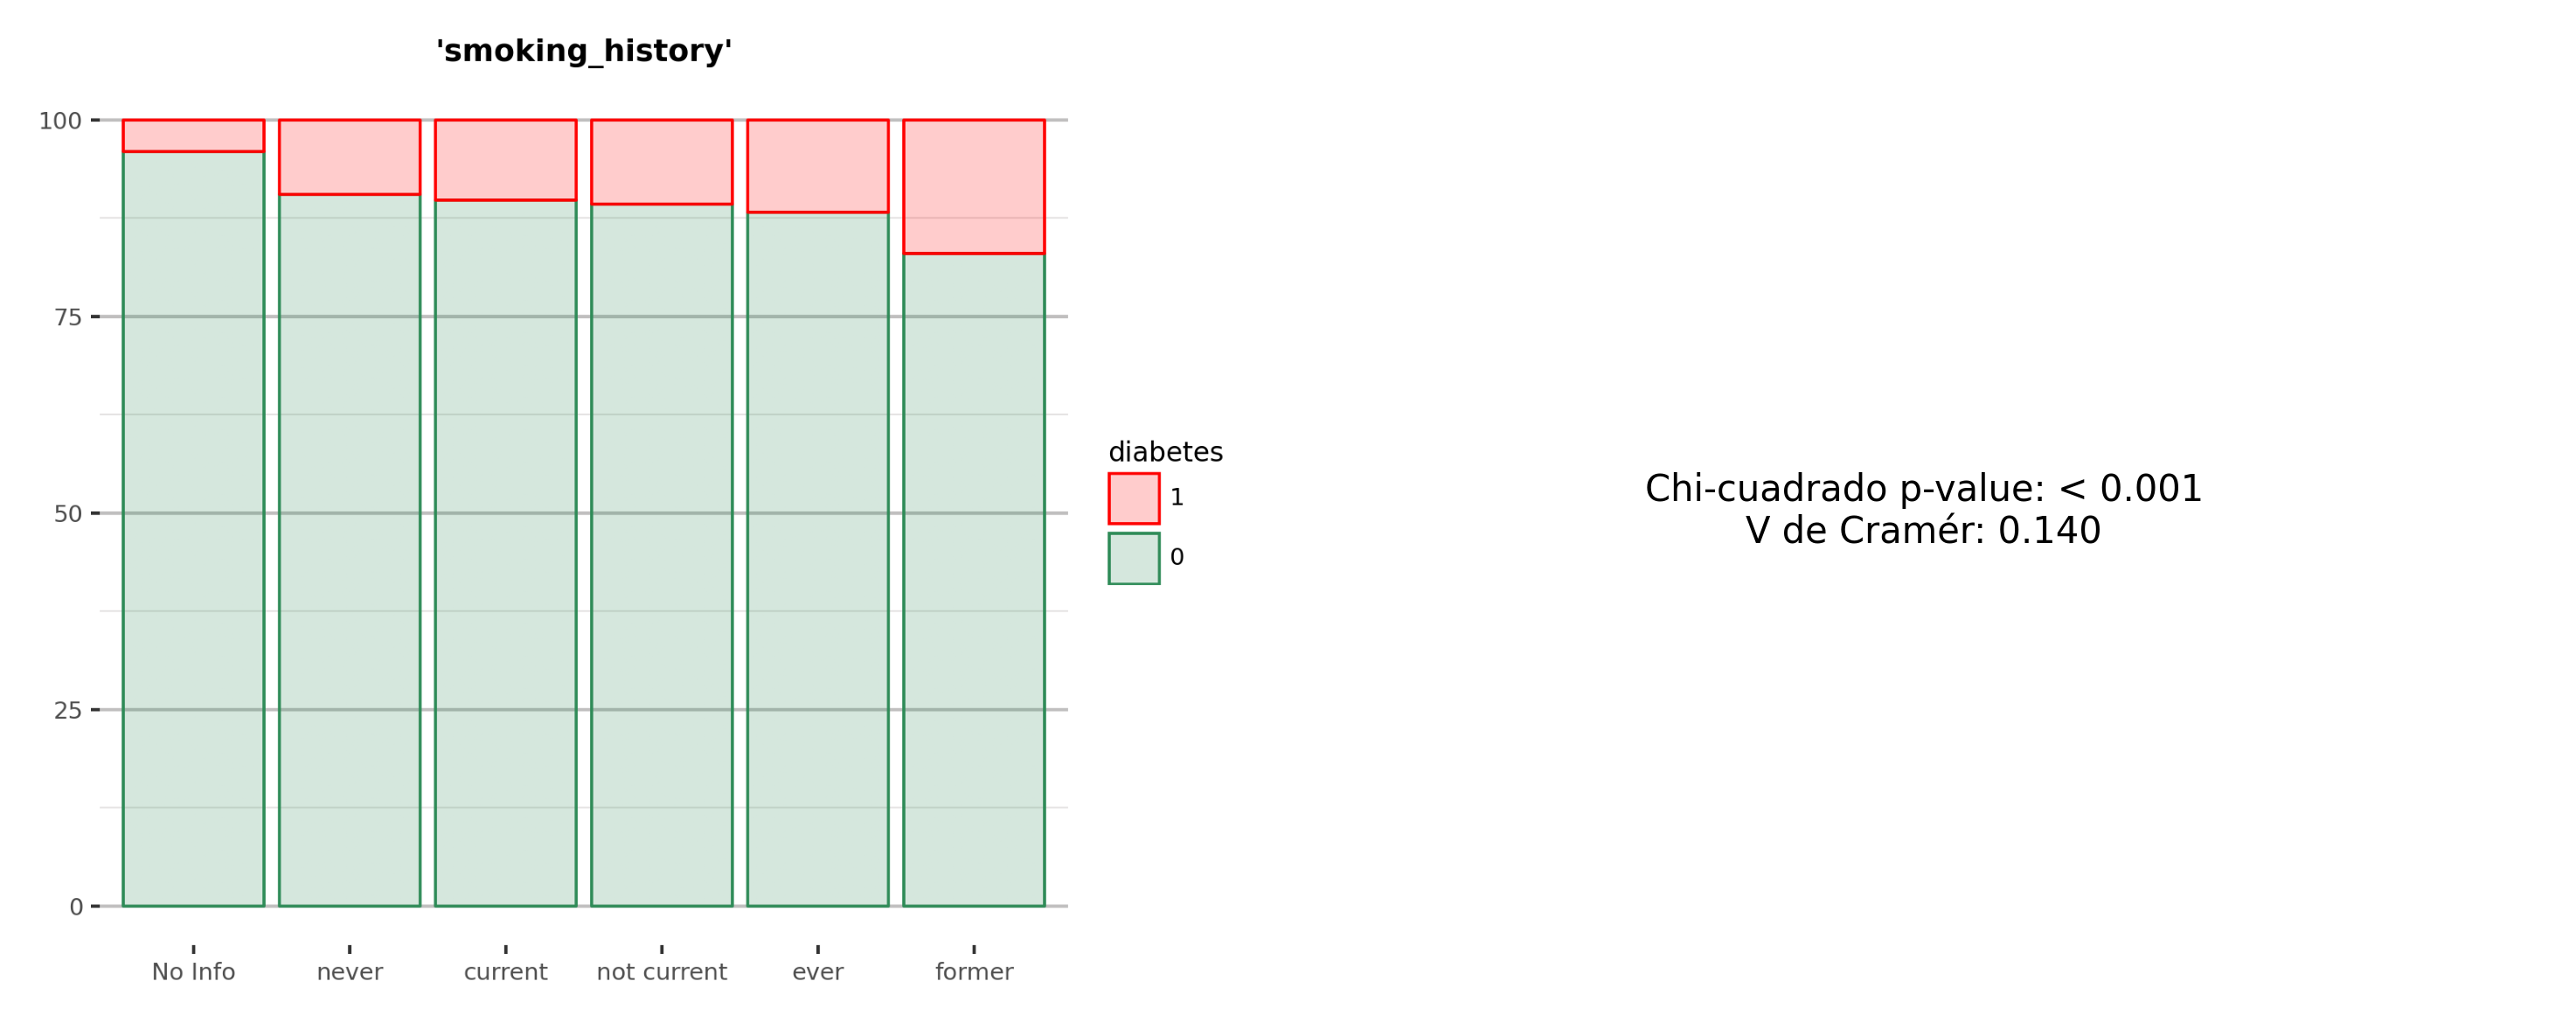

In [262]:
col = categoric_var[1]
cross_tab_per_target = ut.cross_tab_per_target(data,col,'diabetes')
cat_variables_per_group = ut.cat_per_group_plot(data,col,'diabetes',
                                                colors_per_group={'0':'seagreen','1':'red'},
                                                fig_size=(5,4),order='proportion')
desc_text_per_target = ut.desc_text_per_target(data,col,'diabetes')
show_all = ut.join_plots([cat_variables_per_group,desc_text_per_target],[(5,4),(5,4)])
display(cross_tab_per_target)
plt.tight_layout()
plt.show()

### hypertension

Frecuencia                        Porcentaje por clase         \
diabetes              0     1 Total Frecuencia                    0      1   
hypertension                                                                 
0                 86058  6400            92458                93.08   6.92   
1                  5392  2085             7477                72.11  27.89   
Total             91450  8485            99935                91.51   8.49   

                     
diabetes      Total  
hypertension         
0             100.0  
1             100.0  
Total         100.0

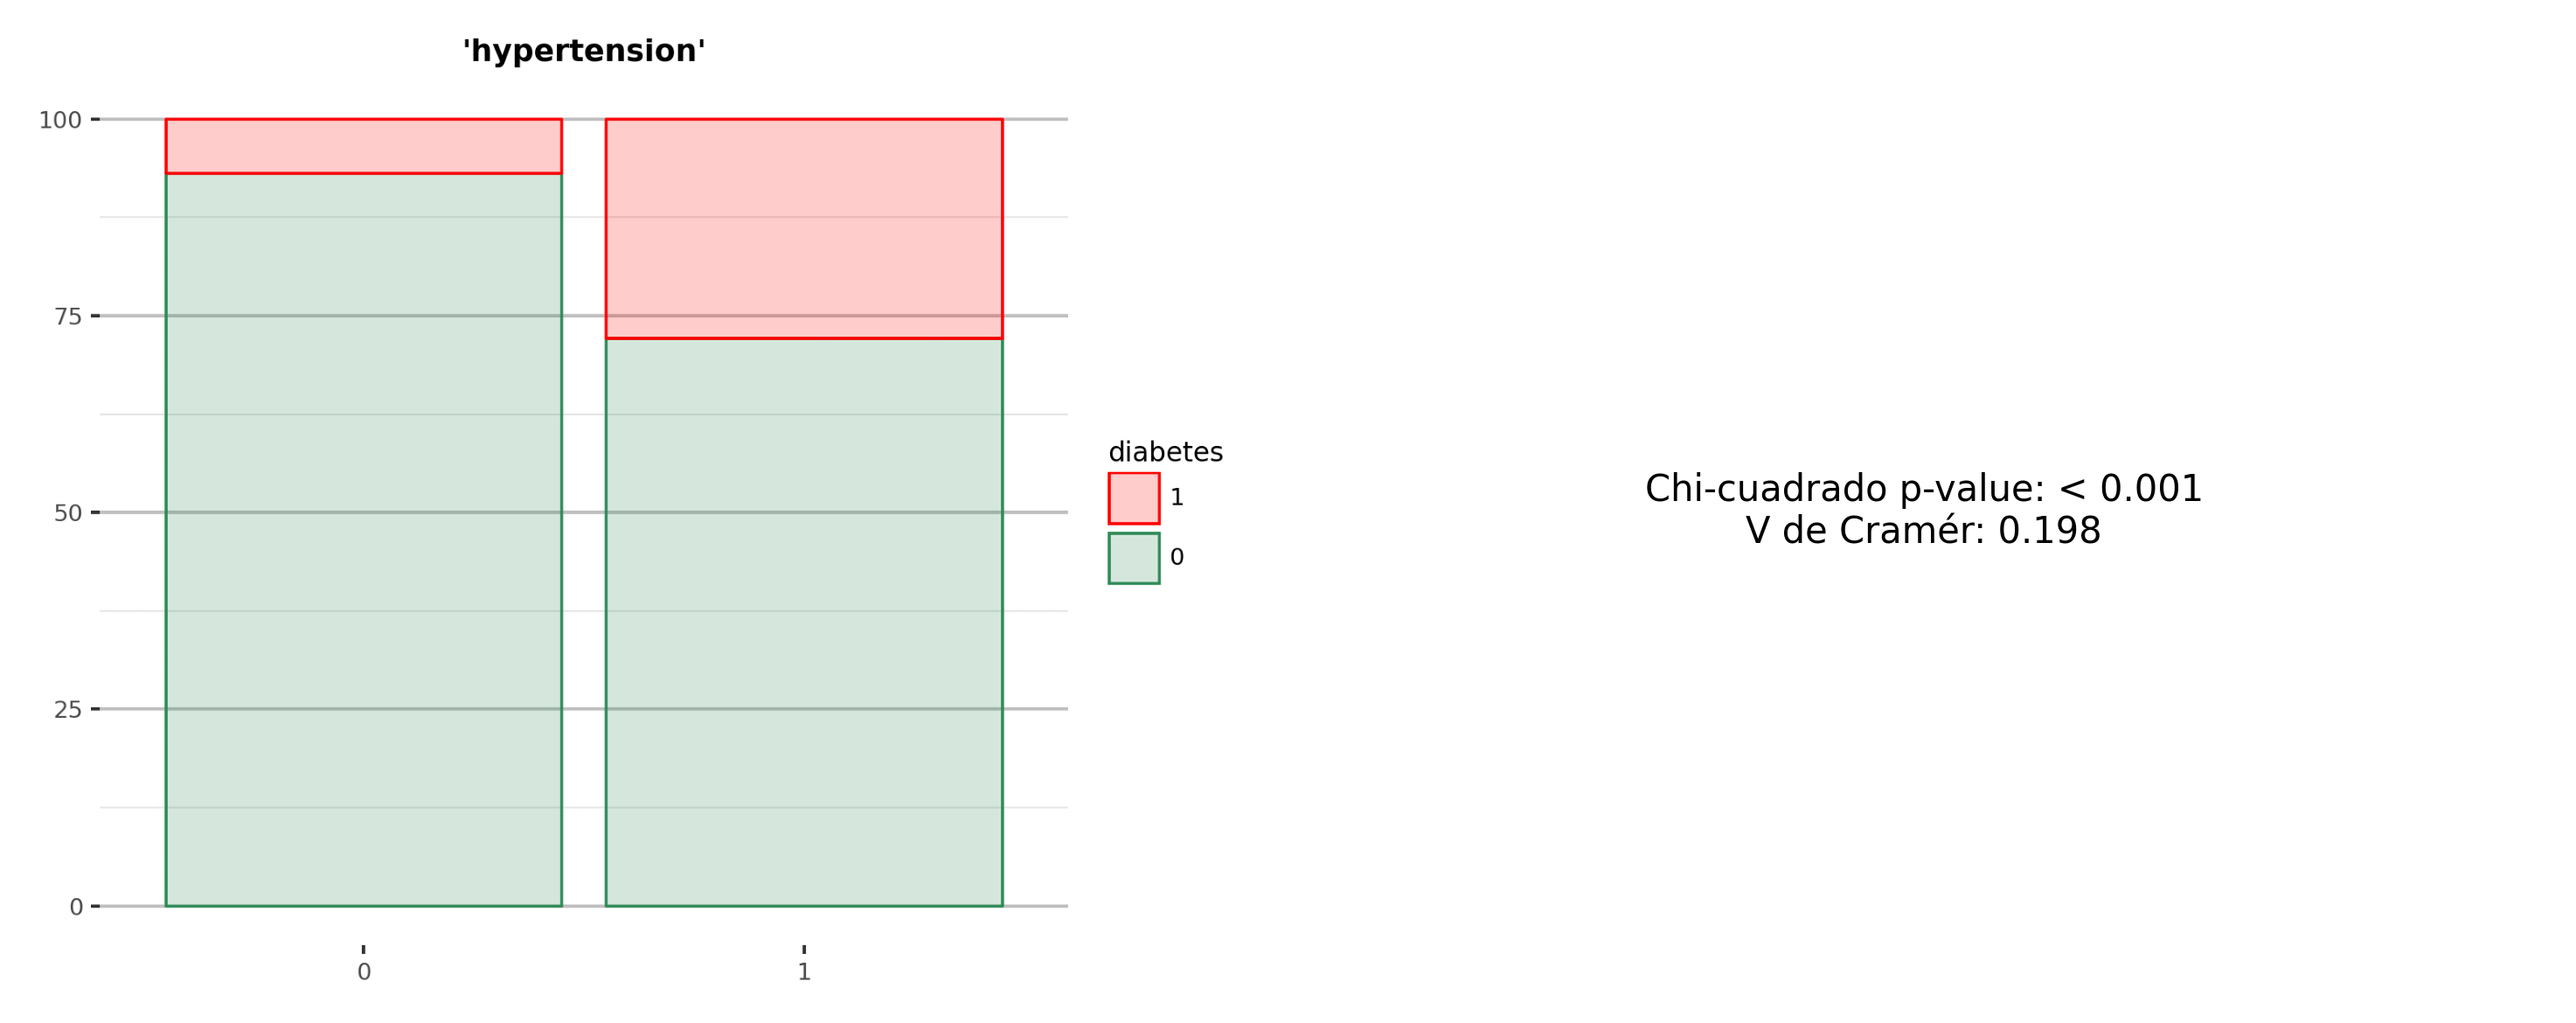

In [263]:
col = categoric_var[2]
cross_tab_per_target = ut.cross_tab_per_target(data,col,'diabetes')
cat_variables_per_group = ut.cat_per_group_plot(data,col,'diabetes',
                                                colors_per_group={'0':'seagreen','1':'red'},
                                                fig_size=(5,4),order='proportion')
desc_text_per_target = ut.desc_text_per_target(data,col,'diabetes')
show_all = ut.join_plots([cat_variables_per_group,desc_text_per_target],[(5,4),(5,4)])
display(cross_tab_per_target)
plt.tight_layout()
plt.show()

### heart_disease

Frecuencia                        Porcentaje por clase         \
diabetes               0     1 Total Frecuencia                    0      1   
heart_disease                                                                 
0                  88778  7218            95996                92.48   7.52   
1                   2672  1267             3939                67.83  32.17   
Total              91450  8485            99935                91.51   8.49   

                      
diabetes       Total  
heart_disease         
0              100.0  
1              100.0  
Total          100.0

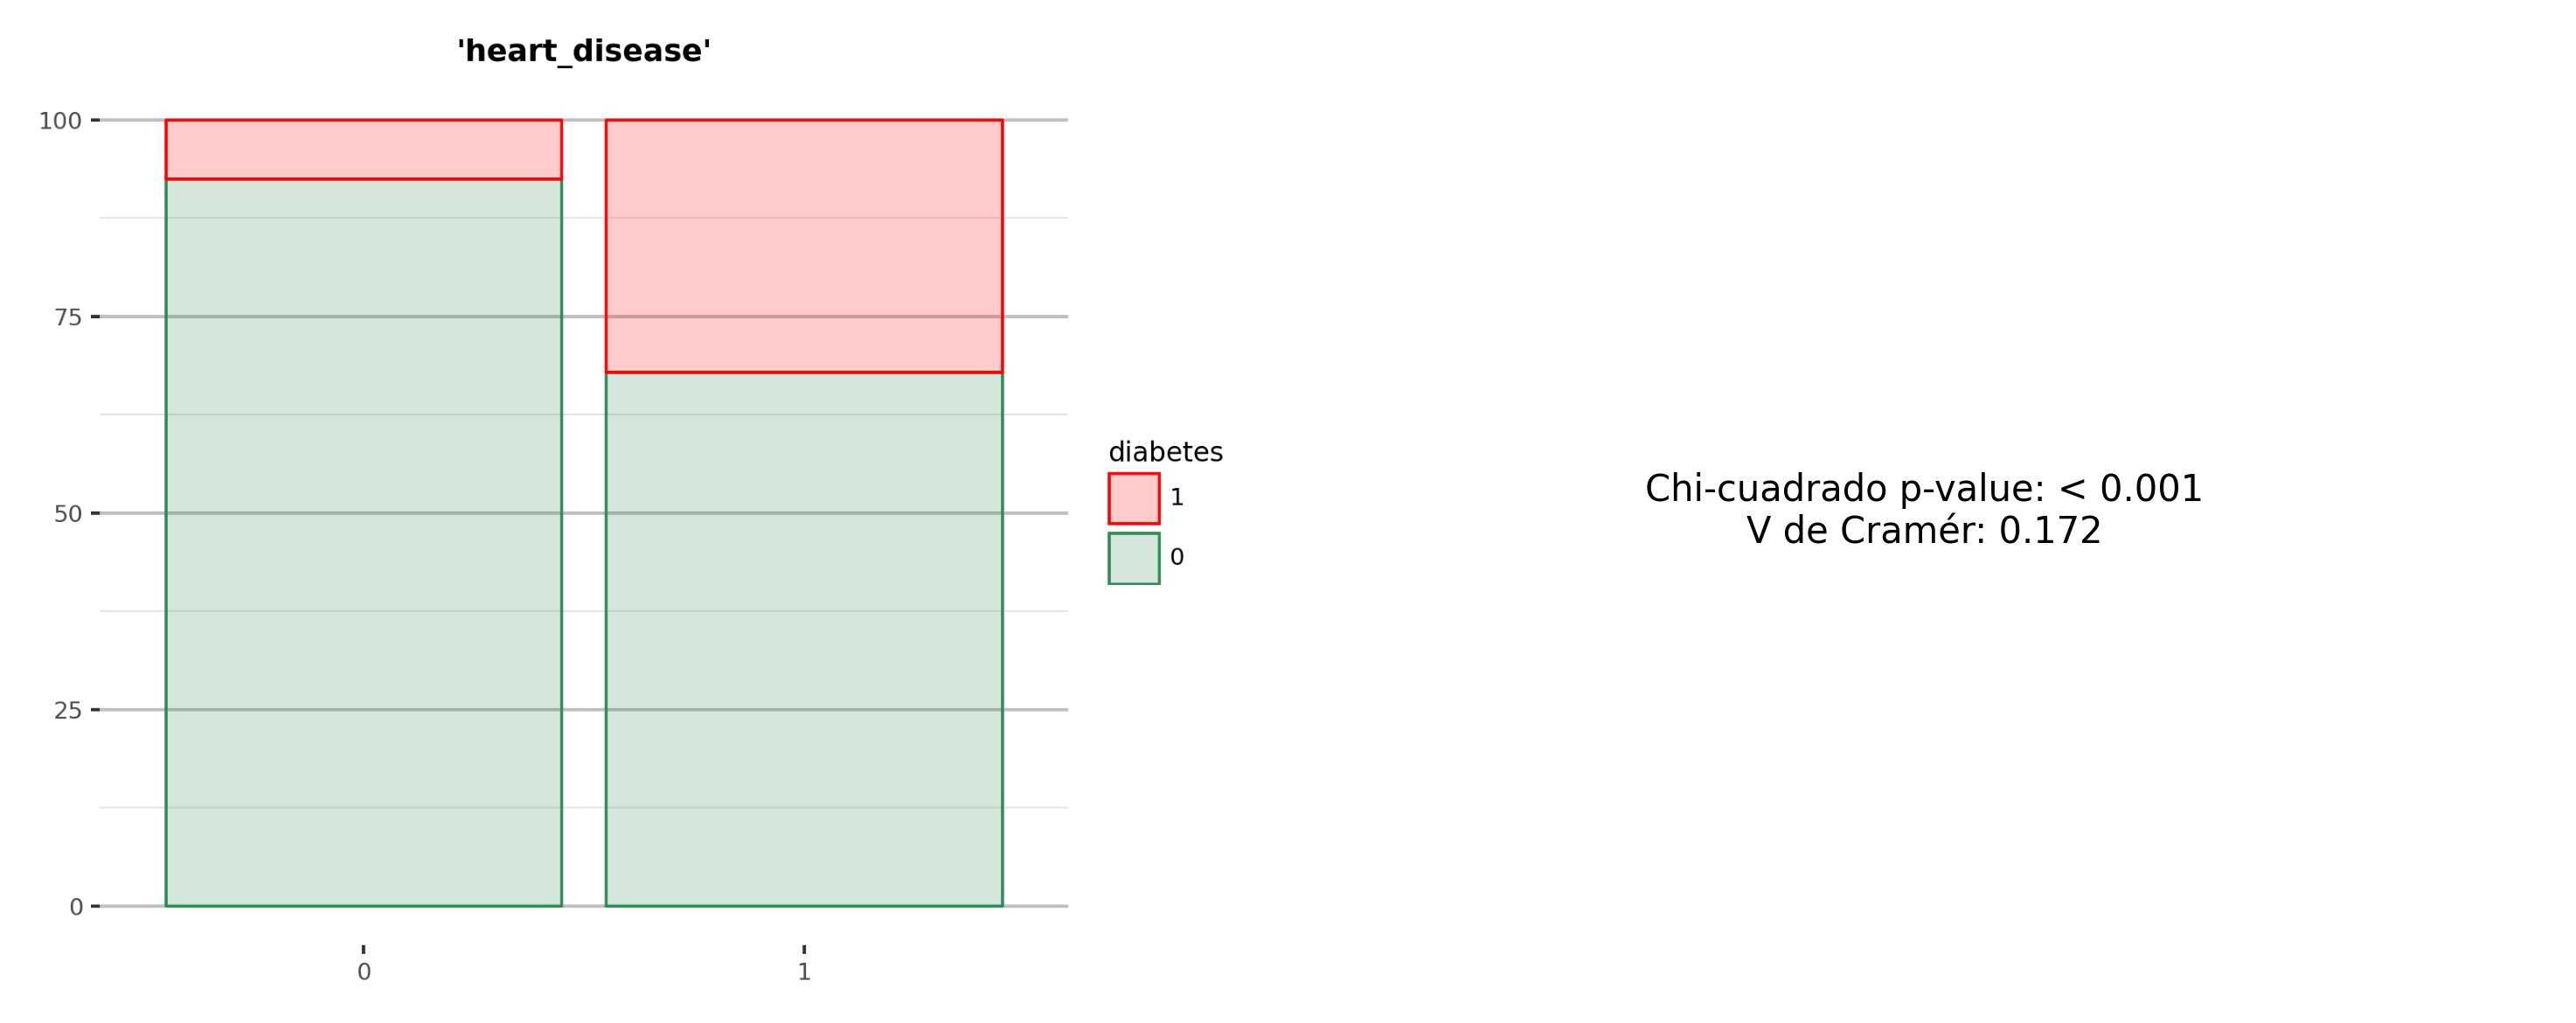

In [264]:
col = categoric_var[3]
cross_tab_per_target = ut.cross_tab_per_target(data,col,'diabetes')
cat_variables_per_group = ut.cat_per_group_plot(data,col,'diabetes',
                                                colors_per_group={'0':'seagreen','1':'red'},
                                                fig_size=(5,4),order='proportion')
desc_text_per_target = ut.desc_text_per_target(data,col,'diabetes')
show_all = ut.join_plots([cat_variables_per_group,desc_text_per_target],[(5,4),(5,4)])
display(cross_tab_per_target)
plt.tight_layout()
plt.show()

### blood_glucose_level_binned

Frecuencia                         \
diabetes                            0     1 Total Frecuencia   
blood_glucose_level_binned                                     
(-inf, 128.00)                  35192   635            35827   
[128.00, 159.50)                42300  3239            45539   
[159.50, 180.00)                 7009   696             7705   
[180.00, inf)                    6949  3915            10864   
Total                           91450  8485            99935   

                           Porcentaje por clase                
diabetes                                      0      1  Total  
blood_glucose_level_binned                                     
(-inf, 128.00)                            98.23   1.77  100.0  
[128.00, 159.50)                          92.89   7.11  100.0  
[159.50, 180.00)                          90.97   9.03  100.0  
[180.00, inf)                             63.96  36.04  100.0  
Total                                     91.51   8.49  100.0

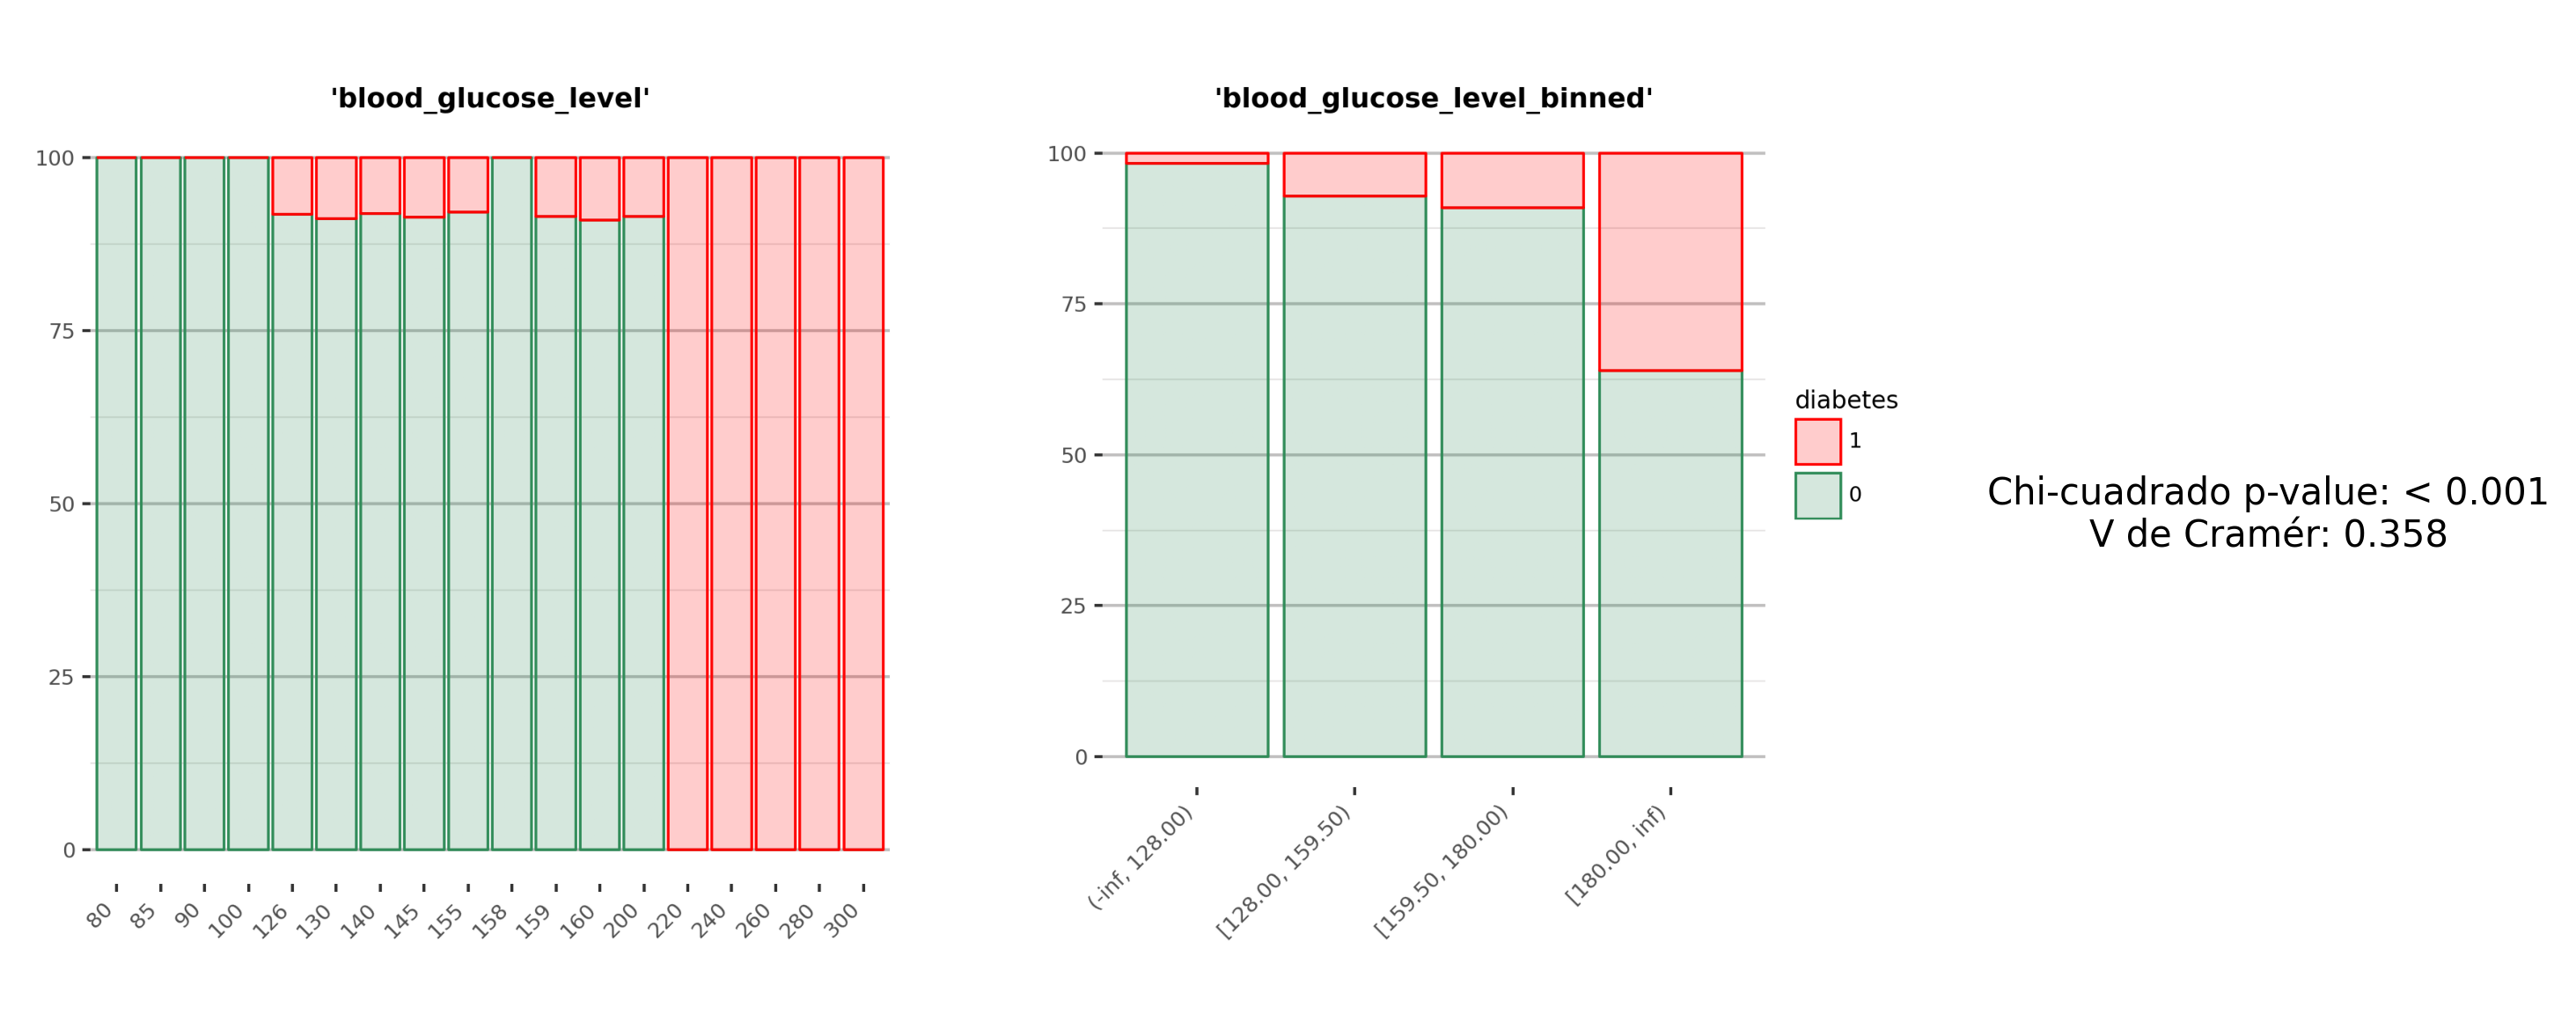

In [265]:
col = categoric_var[4]
cross_tab_per_target = ut.cross_tab_per_target(data,col,'diabetes')
cat_var_per_group_unbinned = ut.cat_per_group_plot(data,col.replace('_binned',''),'diabetes',
                                                   colors_per_group={'0':'seagreen','1':'red'},
                                                   fig_size=(4,4),order='categories',
                                                   legend_pos='none',ticks_x_rot=True)
cat_var_per_group = ut.cat_per_group_plot(data,col,'diabetes',
                                          colors_per_group={'0':'seagreen','1':'red'},
                                          fig_size=(4,4),order='proportion',
                                          legend_pos='right',ticks_x_rot=True)
desc_text_per_target = ut.desc_text_per_target(data,col,'diabetes')
show_all = ut.join_plots([cat_var_per_group_unbinned,cat_var_per_group,desc_text_per_target],
                         [(4,4),(4,4),(2,4)]
                        )
display(cross_tab_per_target)
plt.tight_layout()
plt.show()

### HbA1c_level_binned

Frecuencia                        Porcentaje por clase  \
diabetes                    0     1 Total Frecuencia                    0   
HbA1c_level_binned                                                          
(-inf, 5.75)            45547   701            46248                98.48   
[5.75, 6.55)            38053  3215            41268                92.21   
[6.55, inf)              7850  4569            12419                63.21   
Total                   91450  8485            99935                91.51   

                                  
diabetes                1  Total  
HbA1c_level_binned                
(-inf, 5.75)         1.52  100.0  
[5.75, 6.55)         7.79  100.0  
[6.55, inf)         36.79  100.0  
Total                8.49  100.0

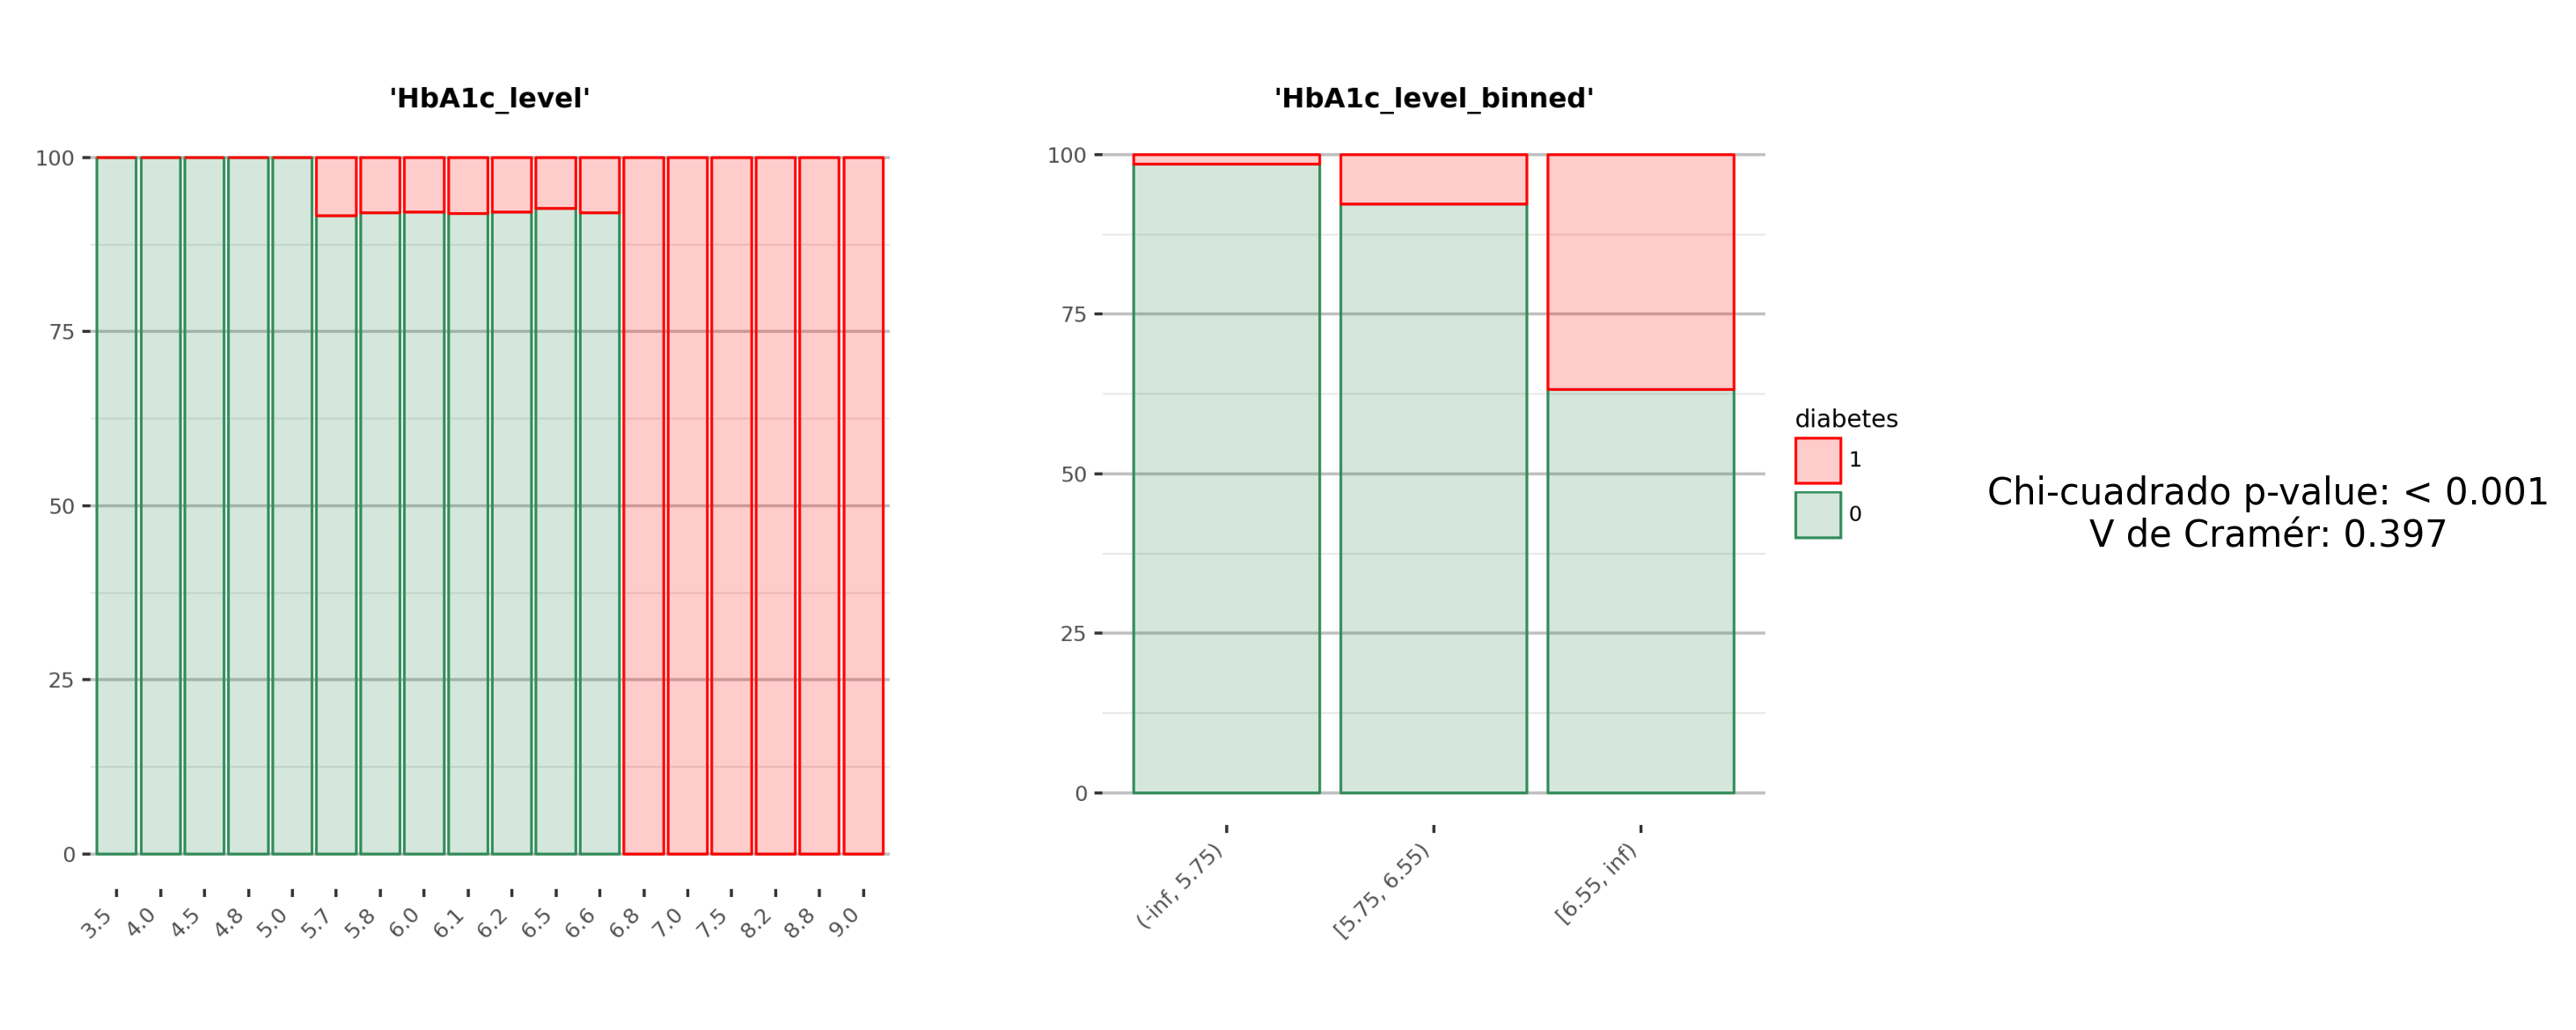

In [266]:
col = categoric_var[5]
cross_tab_per_target = ut.cross_tab_per_target(data,col,'diabetes')
cat_var_per_group_unbinned = ut.cat_per_group_plot(data,col.replace('_binned',''),'diabetes',
                                                   colors_per_group={'0':'seagreen','1':'red'},
                                                   fig_size=(4,4),order='categories',
                                                   legend_pos='none',ticks_x_rot=True)
cat_var_per_group = ut.cat_per_group_plot(data,col,'diabetes',
                                          colors_per_group={'0':'seagreen','1':'red'},
                                          fig_size=(4,4),order='proportion',
                                          legend_pos='right',ticks_x_rot=True)
desc_text_per_target = ut.desc_text_per_target(data,col,'diabetes')
show_all = ut.join_plots([cat_var_per_group_unbinned,cat_var_per_group,desc_text_per_target],
                         [(4,4),(4,4),(2,4)]
                        )
display(cross_tab_per_target)
plt.tight_layout()
plt.show()

#### Contrastes estadísticos entre grupos (variables categóricas)

Para las variables categóricas analizadas se ha aplicado el test Chi-cuadrado de independencia, utilizando el V de Cramér como medida del tamaño del efecto. En todos los casos, el contraste resulta estadísticamente significativo (p < 0.001), lo que indica la existencia de asociación entre las variables consideradas y el estado de diabetes. Sin embargo, la intensidad de dicha asociación difiere entre variables: el género presenta una asociación muy débil (V = 0.038), mientras que el historial de tabaquismo, la hipertensión y la enfermedad cardíaca muestran asociaciones débiles o débil–moderadas (V entre 0.14 y 0.20). Por el contrario, las variables clínicas discretizadas, HbA1c_level_binned y blood_glucose_level_binned, presentan asociaciones fuertes (V = 0.397 y V = 0.358, respectivamente), lo que sugiere que la discretización captura umbrales clínicamente relevantes y refuerza su utilidad para el modelado predictivo posterior.

#### Distribución de las enfermedades según el historial fumador.

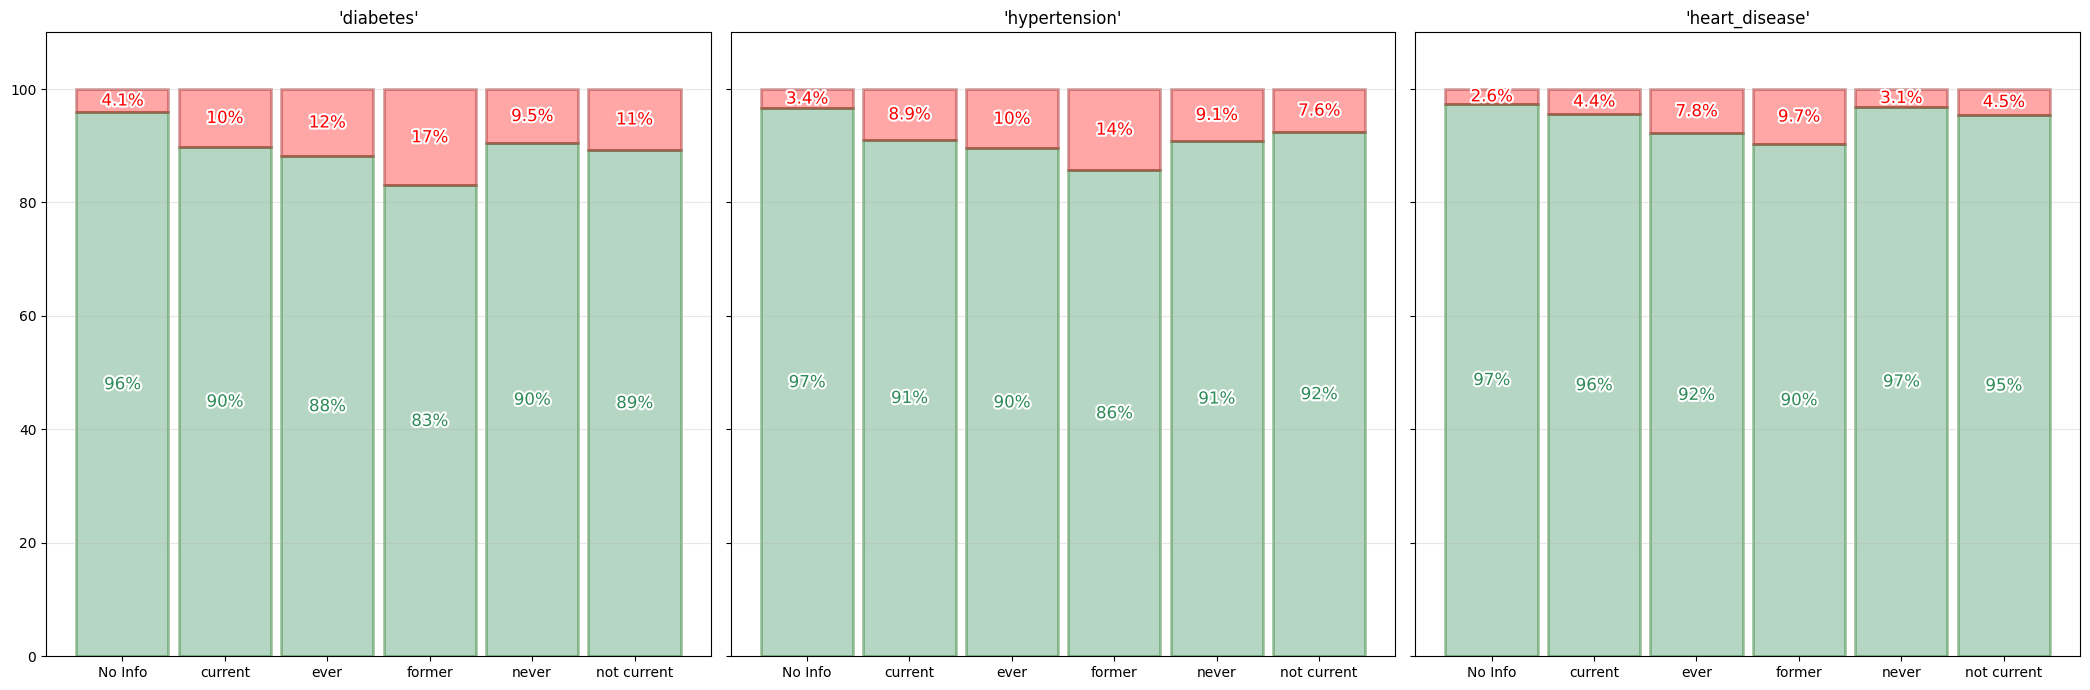

In [267]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

order = ['No Info', 'current', 'ever', 'former', 'never', 'not current']
colors = {'0': 'seagreen', '1': 'red'}  # mismos colores que estabas usando

def plot_stacked_percent(ax, data, group_col, target_col, title,
                         order=None, colors=None, min_show=2.0, fontsize=12):
    # % de clase 1 por grupo
    pct1 = data.groupby(group_col)[target_col].mean() * 100

    # reordenar y asegurar todas las categorías
    if order is not None:
        pct1 = pct1.reindex(order)

    # si hay categorías que no existen en el data, quedarán NaN -> pon 0
    pct1 = pct1.fillna(0.0)
    pct0 = 100 - pct1

    x = np.arange(len(pct1.index))
    w = 0.9

    # barras apiladas
    b0 = ax.bar(x, pct0.values, width=w, color=colors['0'], alpha=0.35,
                edgecolor='darkgreen', linewidth=2)
    b1 = ax.bar(x, pct1.values, width=w, bottom=pct0.values, color=colors['1'], alpha=0.35,
                edgecolor='darkred', linewidth=2)

    # etiquetas %
    def add_labels(bars, values, bottoms=None, color=None):
        for i, rect in enumerate(bars):
            h = values[i]
            if h < min_show:
                continue
            y0 = 0 if bottoms is None else bottoms[i]
            y = y0 + h / 2

            label = f"{h:.1f}%" if h < 10 else f"{h:.0f}%"
            ax.text(
                rect.get_x() + rect.get_width()/2, y, label,
                ha="center", va="center",
                fontsize=fontsize,
                color=color,
                zorder=10,
                path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()]
            )

    add_labels(b0, pct0.values, bottoms=None, color=colors['0'])
    add_labels(b1, pct1.values, bottoms=pct0.values, color=colors['1'])

    # ejes y estilo
    ax.set_title(f"'{title}'")
    ax.set_xticks(x)
    ax.set_xticklabels(pct1.index, fontsize=10)
    ax.set_ylim(0, 110)  # un poco de margen arriba
    ax.grid(axis='y', alpha=0.3)

# --- Figura con 3 paneles ---
fig, axes = plt.subplots(1, 3, figsize=(21, 7), sharey=True)

plot_stacked_percent(axes[0], data, 'smoking_history', 'diabetes', 'diabetes',
                     order=order, colors=colors, min_show=2.0, fontsize=12)

plot_stacked_percent(axes[1], data, 'smoking_history', 'hypertension', 'hypertension',
                     order=order, colors=colors, min_show=2.0, fontsize=12)

plot_stacked_percent(axes[2], data, 'smoking_history', 'heart_disease', 'heart_disease',
                     order=order, colors=colors, min_show=2.0, fontsize=12)

plt.tight_layout()
plt.show()


Si observamos el conteo de personas que sufren y no sufren las diferentes patologías recogidas en el set de datos, nos encontramos resultados que son sorpresivos.

Al contrario de lo que uno podría imaginar, ser fumador actualmente o y no haber fumado nunca tienen comportamientos contraintuitivos. Para las tres patologías, la proporción de enfermos que las sufren es muy similar en estos grupos de historia fumador. Es decir, la gente que actualmente fuma tiene sólo una ligera ventaja en la proporción de enfermos respecto de aquellos que nunca han fumado. Sin embargo, aquellos que tienen como historial `former` aventajan al resto de grupos, incluso a aquellos que se suponen que son grupos similares como `ever` y `not current`. Lo que podemos intentar ver es si hay alguna otra variable que está afectando a estas proporciones.

Lo que se me ocurre es que no sea solo el hábito de fumar lo que genere este tipo de enfermedades, sino la reiteración del hábito a lo largo del tiempo. Por ello vamos a ver la distribución de las edades en cada uno de los grupos.

### `blood_glucose_level` y `HbA1c_level` en relación a la diabetes.

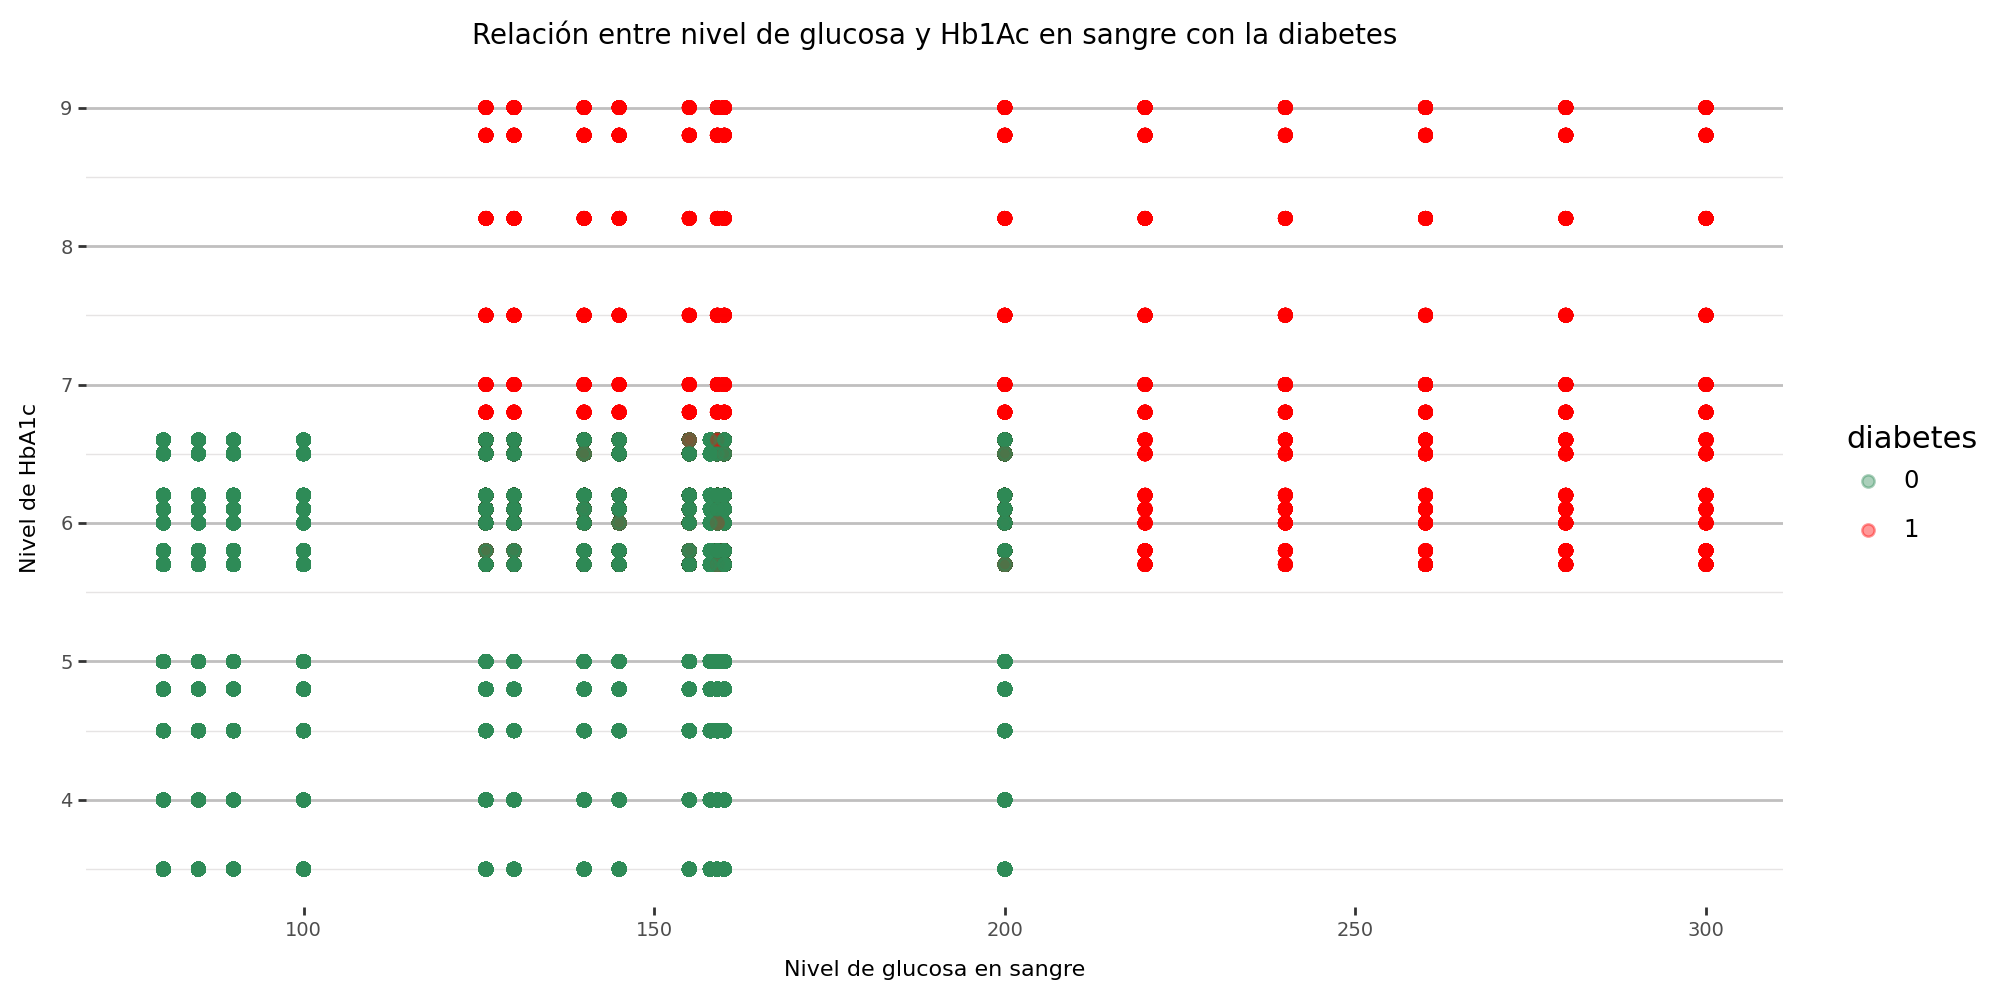

In [268]:
ut.scatter_plot(data,
                x_values='blood_glucose_level',
                y_values='HbA1c_level',
                fig_size=(10,5),
                title='Relación entre nivel de glucosa y Hb1Ac en sangre con la diabetes',
                x_label='Nivel de glucosa en sangre',
                y_label='Nivel de HbA1c',
                col_target='diabetes',
                colors_per_group={'0':'seagreen','1':'red'}
            ).show()

Es evidente en primer lugar que existe una dependencia total entre el valor del nivel de `HbA1c` y el nivel de la glucosa en sangre. Allá donde la glucosa es alta, los niveles bajos de *HbA1c* ni siquiera existen. Por el otro lado, donde la glucosa es baja, los valores mayores de *HbA1c* tampoco existen. Es decir, el nivel de hemoglobina con glucosas adheridad es mayor cuanto mayor es el nivel de glucosa en sangre (como era de esperar).

Pero es que además parece haber un claro nivel de corte en estos niveles a partir de los cuales se considera que una persona tiene diabetes, estos son:


\begin{cases}
\text{blood\_glucose\_level} > 200 \\
\text{HbA1c\_level} > 6.7
\end{cases}


Esto es consistente con las métricas asociadas a **nivel de glucosa (azúcar) en sangre promedio durante los últimos dos o tres meses (prueba A1c)** y a **prueba de tolerancia oral a la glucosa (*blood_glucose_level*)** que se pueden encontrar [aquí]](https://diabetes.org/espanol/diagnostico).

#### Edad contra el BMI.

Vamos a ver como es la relación entre estas variables "contínuas" usando un gráfico de dispersión al uso.

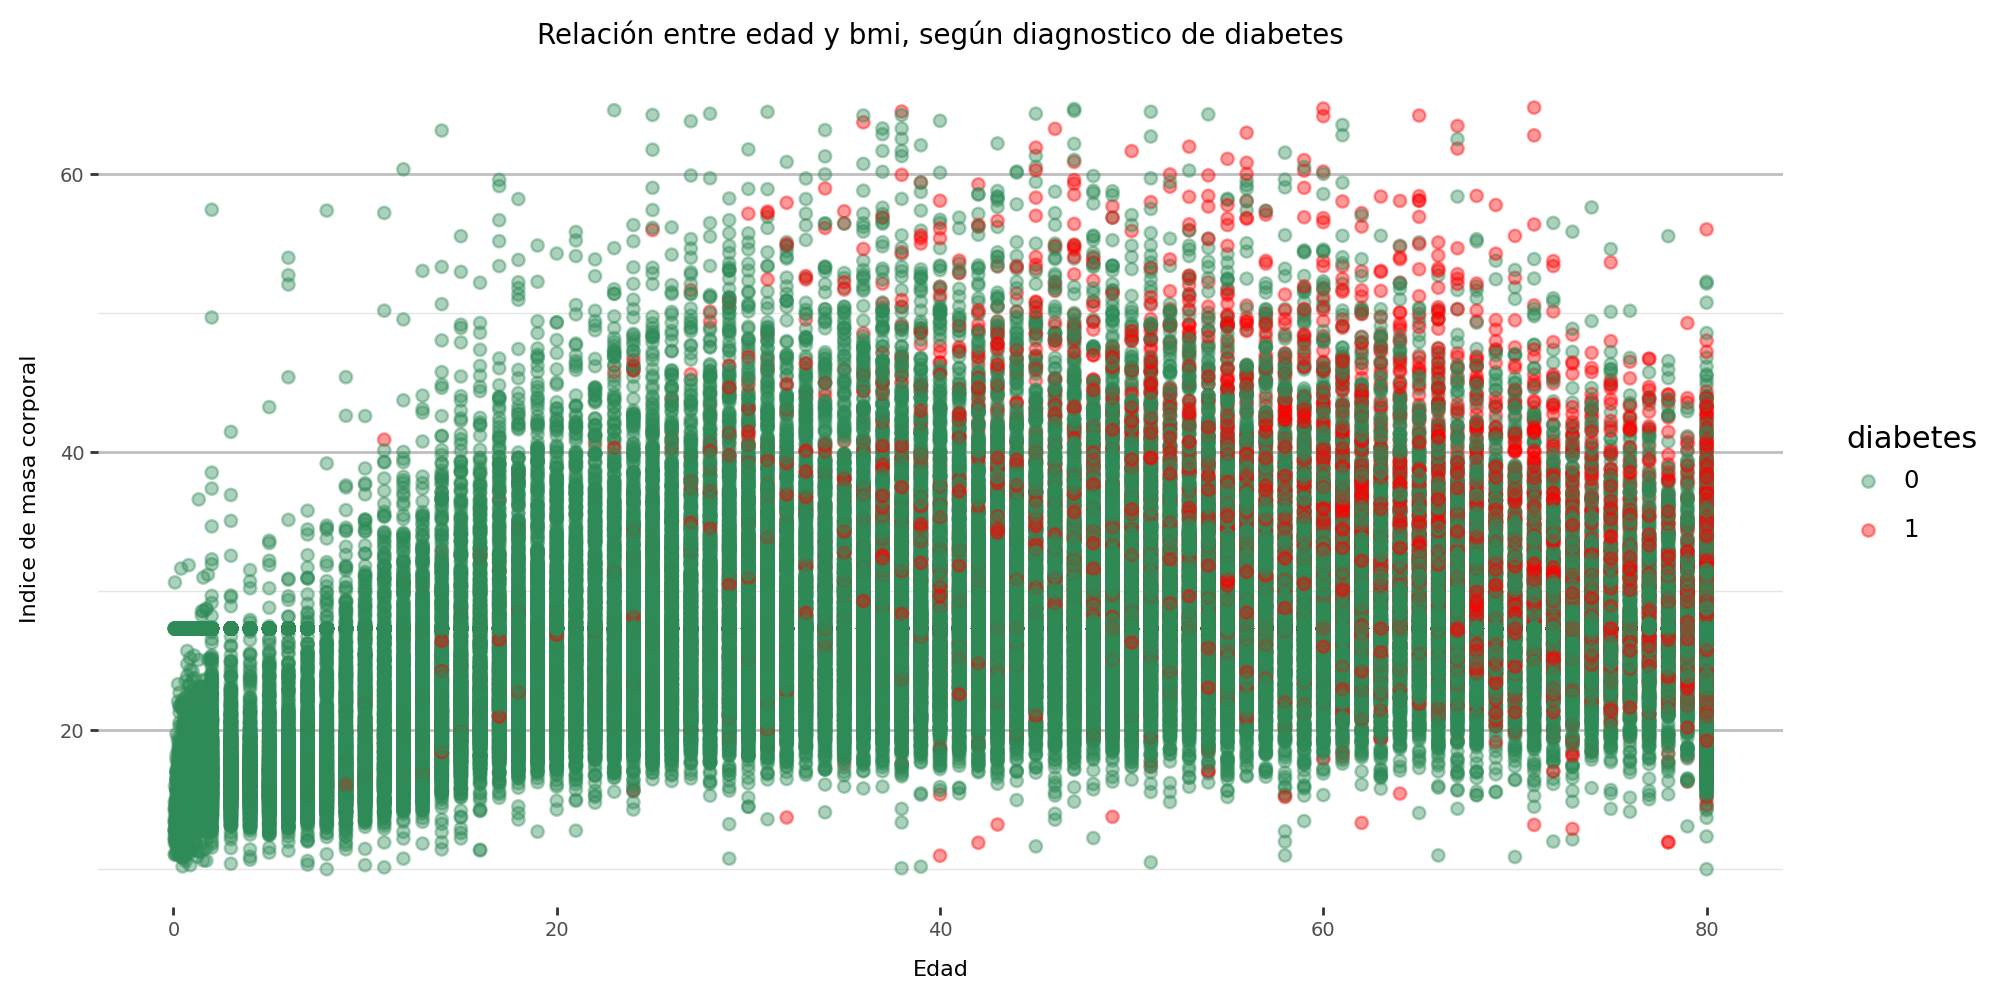

In [269]:
ut.scatter_plot(data,
                x_values='age',
                y_values='bmi',
                fig_size=(10,5),
                title='Relación entre edad y bmi, según diagnostico de diabetes',
                x_label='Edad',
                y_label='Indice de masa corporal',
                col_target='diabetes',
                colors_per_group={'0':'seagreen','1':'red'}
            ).show()

* `BMI`
Como podemos observar, existe una ligera tendencia del IMC a aumentar con la edad como se puede ver en la linea de tendencia. SI observamos el color de cada uno de los puntos, es evidente que aquellos puntos que se encuentran en zonas de edad más longevas y con un *BMI* alto tienen una mayor tendencia a sufrir diabetes. Esto es algoq ue al segregar el *BMI* por la variable diabetes, podemos ver como las distribuciones se separan hasta en $2.5\%$ en mediana.

#### Edad de los sujetos segregados por su historial fumador. 

smoking_history  never  No Info  current  former  not current   ever
mean             43.89    33.54    44.07   57.06        47.72  49.14

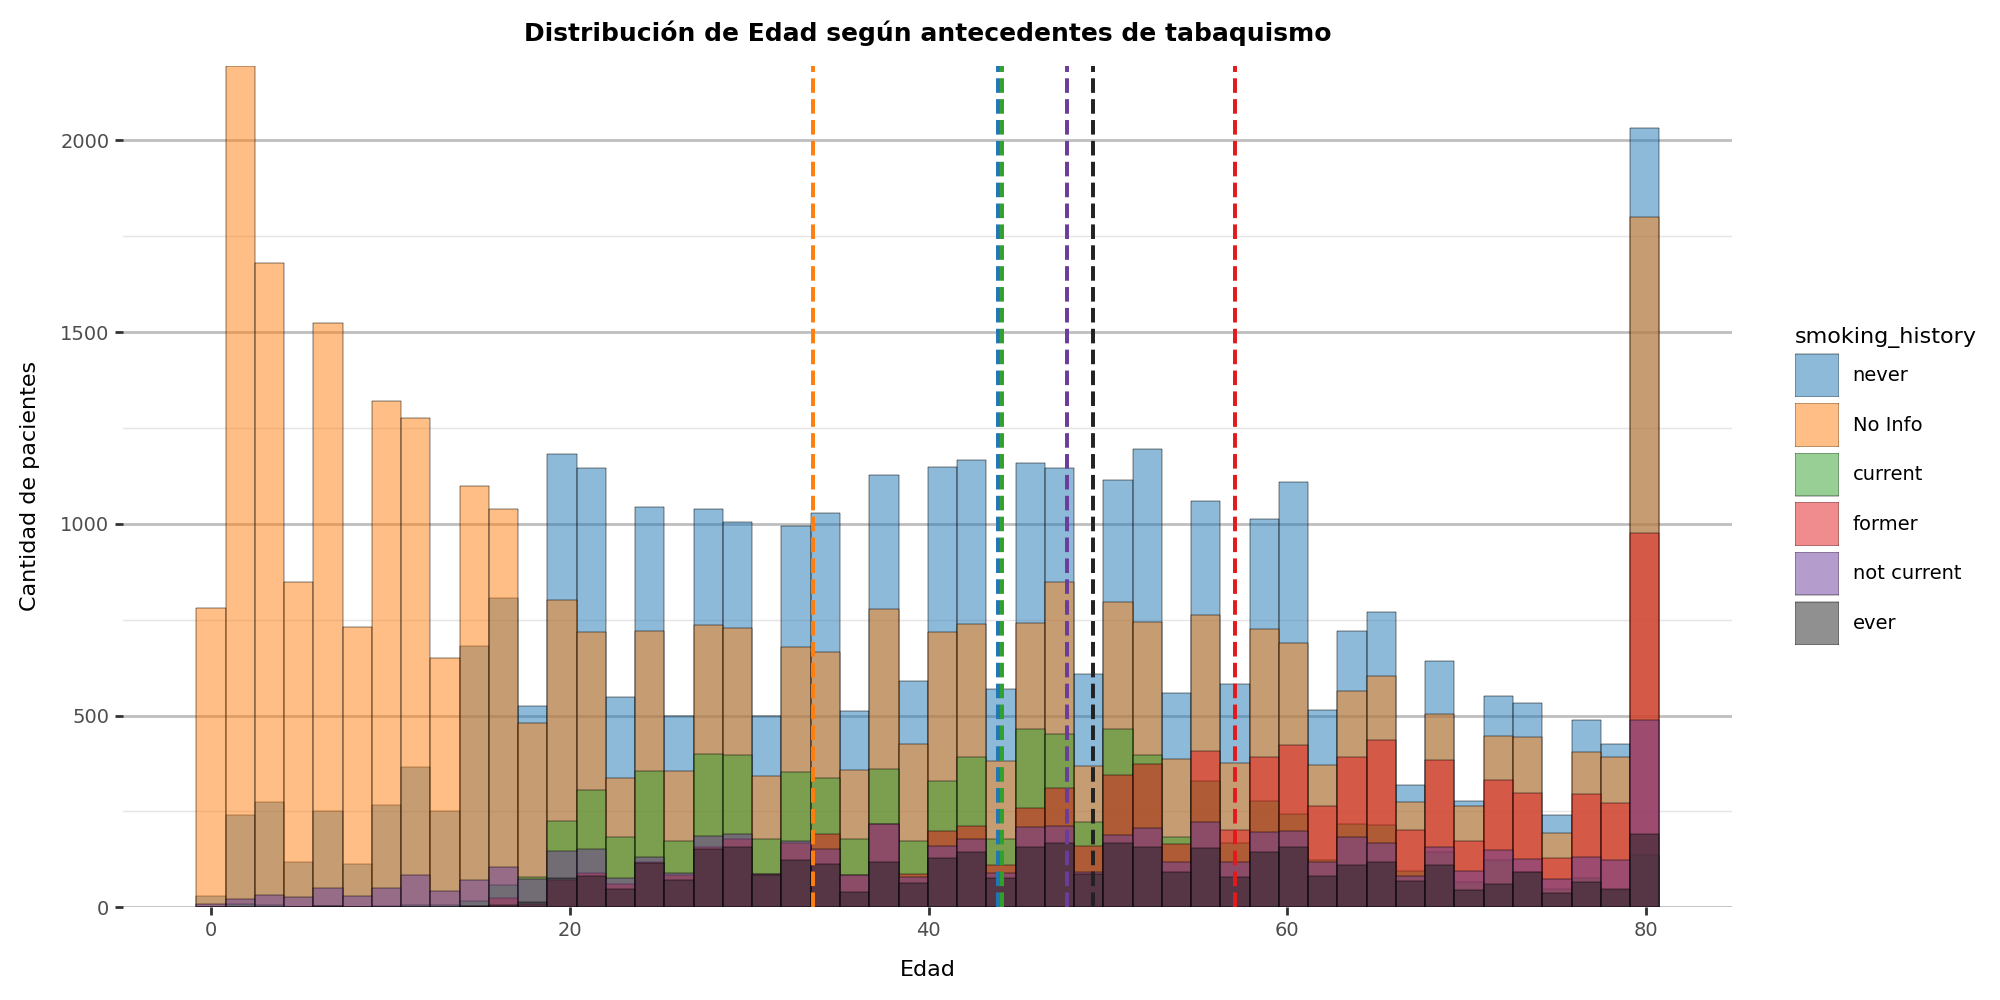

In [270]:
colors = {
    'never'       : '#1F77B4',
    'No Info'     : '#FF7F0E',
    'current'     : '#33A02C',
    'former'      : '#E31A1C',
    'not current' : '#6A3D9A',
    'ever'        : '#222222',
}


order_categories = ['never', 'No Info', 'current', 'former', 'not current', 'ever']
plot,means = ut.hist_comparative(
    data,'age','smoking_history',
    order_categories=order_categories,
    colors_per_group=colors,
    fig_size=(10,5)
)

display(means)
plot.show()

Como habíamos intuido, los grupos de distintos tipos de historiales no tienen las mismas medias. Aunque para determinar de manera definitiva esto sería necesario un test estadístico que lo confirmase, a simple vista, podemos ver que los grupos de ``fumadores'' de mayor edad son los *former*, coincidiendo justamente con aquellos que sufren en mayor proporción las patologías estudiadas. 

Por otro lado, a medida que la edad de estos grupos baja, también baja la proporción de sujetos afectados. Esto es un claro indicador de que **la edad es un factor fundamental a la hora de determinar cuán probable es que un individuo sufra alguna de las patologías**. Quizás sería interesante estudiar el efecto combinado de las variables edad con la variable categórica del historial fumador. Esto se puede hacer mediante una serie de cortes artificiales en la edad.

---

## 3. Insights y tests de hipótesis

### 3.1. Unir clases de `smoking_history`

En primer lugar se comprobará si las clases `ever`, `not current` y `former` presentan diferencias significativas en las variables de interés. Para ello, se realizaran pruebas *t de Student* para cada par de grupos en las variables seleccionadas. Si de manera consistente se rechaza la hipótesis de que la diferencia de medias sea nula, entonces se podrá intuir que se tratan de grupos con diferente distribución y, por ende, no habría argumentos para unir las clases.

In [271]:
ever_smoked = data[data.smoking_history == 'ever']
notcurrent_smoked = data[data.smoking_history == 'not current']
former_smoked = data[data.smoking_history == 'former']

ever_smoked.shape[0], notcurrent_smoked.shape[0], former_smoked.shape[0]

(4002, 6438, 9346)

Como cada grupo tiene suficientes observaciones, se puede aplicar el Teorema del límite central. Esto significa que la media poblacional tiende a una normal, como el test (o el _t\_test_ o el de _Welch_) usan la media poblacional, ya tendríamos la normalidad con tal cantidad de observaciones.

In [272]:
for var in ['diabetes', 'heart_disease', 'hypertension' , 'age', 'bmi', 'HbA1c_level', 'blood_glucose_level']:
    print(f"\nT-tests for variable: {var}")    
    print(f' Ever vs Not Current: {ttest_ind(ever_smoked[var], notcurrent_smoked[var], equal_var=False)}')
    print(f' Former vs Not Current: {ttest_ind(former_smoked[var], notcurrent_smoked[var], equal_var=False)}')
    print(f' Ever vs Former: {ttest_ind(ever_smoked[var], former_smoked[var], equal_var=False)}\n\n')


T-tests for variable: diabetes
 Ever vs Not Current: TtestResult(statistic=np.float64(1.6839313265606903), pvalue=np.float64(0.09223293358926565), df=np.float64(8214.751070179458))
 Former vs Not Current: TtestResult(statistic=np.float64(11.480062509030716), pvalue=np.float64(2.2132084337260092e-30), df=np.float64(15289.383330619721))
 Ever vs Former: TtestResult(statistic=np.float64(-8.123196567112332), pvalue=np.float64(5.159202545943348e-16), df=np.float64(8736.123627196053))



T-tests for variable: heart_disease
 Ever vs Not Current: TtestResult(statistic=np.float64(6.604743558836896), pvalue=np.float64(4.276446181376676e-11), df=np.float64(6944.223890004773))
 Former vs Not Current: TtestResult(statistic=np.float64(12.85818210531438), pvalue=np.float64(1.1958755931897308e-37), df=np.float64(15775.373013803222))
 Ever vs Former: TtestResult(statistic=np.float64(-3.5788465436856507), pvalue=np.float64(0.00034708678568155625), df=np.float64(8283.928263891394))



T-tests for variab

De manera general, los resultados de las pruebas rechazan la hipótesis de igualdad de medias, especialmente en aquellas comparaciones que involucran a la clase `former`. En concreto, para la mayoría de variables analizadas (*heart_disease*, *hypertension*, *age*, *bmi*), las diferencias entre former y el resto de clases son altamente significativas (p-values < 0.001). Esto indicaría que existen diferencias significativas entre las clases que estamos comparando y que por lo tanto no debemos unir ninguna de ellas.

Como no está muy clara cuál es la diferencia entre las clases, lo que sí se puede observar es lo siguiente; la clase `former` es la más longeva entre las tres y es precisamente aquella que tiene una mayor incidencia de patologías. Para ello usamos el test de *Tukey* de varias medias que permite identificar de forma controlada qué pares de grupos presentan diferencias significativas tras haber detectado diferencias globales entre ellos:

In [273]:
tukey = sm.stats.multicomp.pairwise_tukeyhsd(
    endog=data.loc[data.smoking_history.isin(['ever','former','not current']), 'age'],
    groups=data.loc[data.smoking_history.isin(['ever','former','not current']), 'smoking_history'],
    alpha=0.05
)
print(tukey)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1    group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------
  ever      former   7.9202    0.0   7.1199  8.7205   True
  ever not current  -1.4276 0.0003  -2.2803 -0.5748   True
former not current  -9.3477    0.0 -10.0339 -8.6616   True
----------------------------------------------------------


Los resultados del test de *Tukey* muestran que existen diferencias estadísticamente significativas en la edad media entre todos los pares de grupos considerados (p-ajustado < 0.05 en todos los casos). En particular, la clase `former` presenta una edad media significativamente mayor que la clase `ever` (diferencia media ≈ 7.9 años) y que la clase `not current` (diferencia media ≈ 9.4 años).

Además, ahora usando el test de *chi cuadrado*, podemos analizar si la variable de grupo de historial fumador es significativa para determinar la proporción de patologías. Para ello, se construyen tablas de contingencia entre el historial de tabaquismo y las variables *diabetes*, *hypertension* y *heart_disease*, con el objetivo de evaluar si la distribución de estas patologías depende del grupo al que pertenece cada individuo.

Este análisis se complementa con la tabla de proporciones, que permite observar de forma descriptiva cómo varía la incidencia de cada patología entre las distintas clases de historial fumador.

In [274]:
for disease in ['diabetes', 'hypertension', 'heart_disease']:
    data_chi = data[data.smoking_history != 'No Info']
    ct = pd.crosstab(data_chi['smoking_history'], data_chi[disease])
    chi2, p, dof, expected = chi2_contingency(ct)
    print(f"{disease}: chi2={chi2:.2f}, p={p:.4f}")

data_chi.groupby('smoking_history')[['diabetes','hypertension','heart_disease']].mean()*100

diabetes: chi2=433.74, p=0.0000
hypertension: chi2=279.59, p=0.0000
heart_disease: chi2=802.41, p=0.0000


diabetes  hypertension  heart_disease
smoking_history                                        
current          10.185385      8.935115       4.408278
ever             11.794103     10.469765       7.821089
former           17.001926     14.316285       9.693987
never             9.512133      9.130050       3.127940
not current      10.717614      7.579994       4.535570

Observando la tabla de proporciones, se aprecia que la clase `former` presenta de forma consistente la mayor incidencia de patologías. En concreto, este grupo muestra los porcentajes más elevados de *diabetes*, *hypertension* y *heart_disease* en comparación con el resto de clases.